# SEISMO-VRE for a multiparametric and multidisciplinary analysis of an earthquake  
Except where otherwise noted, this Jupyter Notebook is made available under the GPL-3.0 license. For details, please see the `LICENSE` file in the main directory.
# MATLAB Version
## MINI ABSTRACT  

The study presents the development of a Virtual Research Environment (VRE) for analysing an earthquake using a multiparametric and multidisciplinary approach. The case study of the 2016-2017 Amatrice-Norcia (Italy) seismic sequence was selected as an example. Implemented through Jupyter Notebooks, the VRE enables researchers to reproduce analyses, modify parameters, and visualise results interactively. It leverages the European Plate Observing System (EPOS) platform, which integrates diverse geophysical datasets. The system accesses earthquake data via EPOS APIs and could potentially be deployed as software within the EPOS portal in the future.

## IMPLEMENTATION OVERVIEW
### Data 
The VRE at this preliminary stage of implementation uses:
1. **[Lithosphere](#Lithospheric-analysis):** earthquake catalogue retrieved by EPOS; [GNSS station positions retrieved by EPOS](#Analysis-of-vatiations-of-plates-movements-from-EPOS-GNSS-Positions);  
2. **[Atmosphere](#Atmospheric-analysis):** Climatological measurements from the MERRA-2 archive by NASA (parameters: SO_2, dimethyl sulphide, aerosol optical thickness, CO, Surface Air Temperature, relative humidity, Surface Latent Heat Flux, Total Precipitation);
3. **[Ionosphere](#Ionospheric-analysis):**  Swarm three identical satellite magnetic data 

### Analyses workflow 
1. [Lithosphere](#Lithospheric-analysis)  
2. [Atmospheric analysis](#Atmospheric-analysis)
3. [Ionosphere](#Ionospheric-analysis)
4. [Comparison of the three Geo-layers](#Comparison-of-Lithosphere-Atmosphere-and-Ionosphere-analyses).

### Reconfigurable parameters
The VRE is reconfigurable for another target earthquake (possible limitation for events close to -180 or +180 longitude) changing:
1. **Earthquake origin time:** EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second;
2. **earthquake magnitude:** EQ_mag;
3. **Epicentral coordinates:** epilat, epilon.
4. **Hypocentral depth:** EQ_depth
5. **Fault strike:** Fault_strike (this is the angle of orientation of the fault determined from one of the two nodal planes 
It's also possible to change the time to be analysed before and after the target earthquake (in days):
6. **day before the earthquake:** day_before;
7. **day after the earthquake:** day_after

In [41]:
% Global variables initialization

% Earthquake origin time
EQ_year = 2016; EQ_month=8; EQ_day=24; EQ_hour=1; EQ_minute=36; EQ_second = 32;
% Epicenter latitude and longitude
epilat = 42.6980; epilon = 13.2340;
%Mainshock magnitude
EQ_mag = 6.5;
EQ_depth = 10;
Fault_strike = 153; %Here is inserted a mean strike of the two main faults: Amatrice 155 and Norcia 151
%This strike must be a positive value
day_before = 8*30;
day_after = 0;

# Lithospheric analysis 
## step 1
1. Lithospheric analysis
1.1  
we retrieve the seismic catalogue to study the Lithosphere from the EPOS Platform

In [42]:
format compact
% Define the folder for the output products of the VRE
Output_folder = "Outputs";

% Calculus of the origin time of the earthquake
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
%Calculus of time span for analysis
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
%Calculus of the research region border for this study
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = epilat - radius_Dobrovolsky - 5;
max_lat = epilat + radius_Dobrovolsky + 5;
min_lon = epilon - radius_Dobrovolsky - 5;
max_lon = epilon + radius_Dobrovolsky + 5;
%Minimun magnitude to be retrieved by the catalogue
EQ_min_mag= 1.0;

%Cycle to retrieve the earthquake catalogue data from EPOS (EMSC).
EQ = [];
for time_tba = time_start:time_end-1
    time_tba_end = time_tba + (23+59/60.0+59/3600.0)/24;
    weburl_to_retrive_the_data = ['https://www.seismicportal.eu/fdsnws/event/1/query?starttime=', datestr(time_tba, 'yyyy-mm-dd'), 'T',  datestr(time_tba, 'HH'),':', datestr(time_tba, 'MM'), ':', datestr(time_tba, 'SS'),'Z&endtime=', datestr(time_tba_end, 'yyyy-mm-dd'), 'T', datestr(time_tba_end, 'HH'),':', datestr(time_tba_end, 'MM'), ':', datestr(time_tba_end, 'SS'), 'Z&minmagnitude=', num2str(EQ_min_mag, '%.1f'), '&minlatitude=', num2str(min_lat, '%.4f'), '&maxlatitude=', num2str(max_lat, '%.4f'), '&minlongitude=', num2str(min_lon, '%.4f'), '&maxlongitude=', num2str(max_lon, '%.4f'), '&includeallorigins=false&includearrivals=false&limit=480&format=json&nodata=204'];%'&preferredOnly=true&format=text&limit=2500'];
    EQ_p = webread(weburl_to_retrive_the_data);
    EQ = [EQ; EQ_p];
end
disp(EQ)


  240x1 struct array with fields:
    type
    metadata
    features


The following part, convert the earthquake catalogue in an array with the ZMap (Wiemer, 2001) standard, that  is:
longitude | latitude | year | month | day | magnitude | depth | hour | minute | second

<b> References: </b>
Wiemer, S. A Software Package to Analyze Seismicity: ZMAP. Seismological Research Letters 2001, 72, 373–382, doi:10.1785/gssrl.72.3.373.



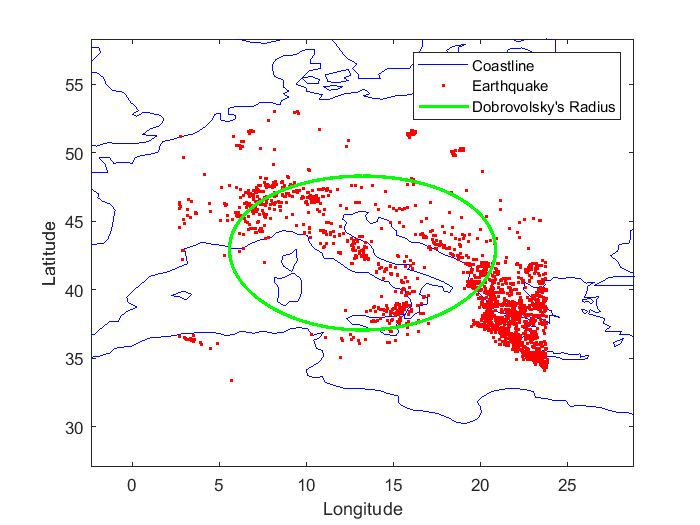

In [43]:
format compact

% The retrieved data are divided into packages. The number of them is provided as an output in the previous cell. 
% The following cycle, unwrap the packages of data retrieved from each request in an array, assuring that each row corresponds to a single earthquake event. 
k=1;
EQ_new = nan(size(EQ,1)*3,10);
for i = 1:size(EQ,1)
    EQ_temp = EQ(i).features;
    for j = 1:size(EQ_temp,1)
        hypocenter = EQ_temp(j).geometry.coordinates;
        EQ_magnitude = EQ_temp(j).properties.mag;
        EQ_origin_time = EQ_temp(j).properties.time;
        EQ_origin_time_1 = datetime([EQ_origin_time(1:10), ' ', EQ_origin_time(12:21)]);
        EQ_origin_time_vector = datevec(EQ_origin_time_1);
        EQ_new(k,:) = [hypocenter(1:2)', EQ_origin_time_vector(1:3), EQ_magnitude, -hypocenter(3), EQ_origin_time_vector(4:6)];
        k = k + 1;
    end
end
EQ_new = EQ_new(1:k-1,:);

%Creation of the map with all the retrieved events and the circle of Dobrovolsky's area to sub-select the new sub-catalog selection
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(EQ_new(:,1), EQ_new(:,2), '.r');
[aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
plot(bbs,aas,'-g', 'LineWidth',2);
axis([min_lon-5 max_lon+5 min_lat-5 max_lat+5]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', ['Dobrovolsky', 39, 's Radius']);

# Selection of earthquakes of interest
In the following lines, only the most interesting earthquakes are selected. In fact, we will consider a circular area defined by Dobrovolsky's Radius (km) = $10^{0.43 \times MAG}$ (Dobrovolsky et al., 1979). This is one of the possible areas that define the preparation of an earthquake, but it's widely used, and it corresponds to the distance where the seismic shaking is equal to the terrestrial tidal deformation.

In addition, we need to select only the earthquakes with a magnitude equal to or greater than the completeness magnitude of the earthquake catalogue.  
Last but not least, a selection of shallow earthquakes can be applied as deeper events are unlikely related to the interactions with the atmosphere and ionosphere. 

<b> References: </b>  
Dobrovolsky, I.P.; Zubkov, S.I.; Miachkin, V.I. Estimation of the Size of Earthquake Preparation Zones. PAGEOPH 1979, 117, 1025–1044, doi:10.1007/BF00876083.


In [44]:
%Calculus of the distance of each earthquake from the target event.
distance_from_target_EQ = distance(epilat, epilon, EQ_new(:,2), EQ_new(:,1));
%sub-selection of  events from the retrieved earthquake catalogue inside the green circle.
EQ_sel = EQ_new(distance_from_target_EQ <= radius_Dobrovolsky, :);
distance_from_target_EQ = distance_from_target_EQ(distance_from_target_EQ <= radius_Dobrovolsky);

Completeness_magnitude = 2.0; % From ZMap using Max curvature criterium
%in a future update, the MC can be calculated inside the VRE
%sub-selection of  events from the previous selection with magnitude equal or greater than MC.
distance_from_target_EQ = distance_from_target_EQ(EQ_sel(:,6) >= Completeness_magnitude);
EQ_sel = EQ_sel(EQ_sel(:,6) >= Completeness_magnitude, :);

max_depth = 50;
%sub-selection of  events from the previous selection with depth minor or equal to the max_depth.
distance_from_target_EQ = distance_from_target_EQ(EQ_sel(:,7) <= max_depth);
EQ_sel = EQ_sel(EQ_sel(:,7) <= max_depth, :);

%Ordering all the events for their origin time (i.e., chronologically)
EQ_sel = sortrows(EQ_sel, [3,4,5,8,9,10]);

%show the final number of earthquakes in the selection for further analyses.
size(EQ_sel,1)

% Save the selected earthquakes in the output folder
save(fullfile(Output_folder, ['EQ_catalogue_target_EQ_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '.txt']), "EQ_sel", '-ascii');


ans =    591

# Calculus of Cumulative Benioff Strain   
The Benioff cumulative strain is computed according to the original formulation of Benioff:  
$S(t) = \sum_{i}^{N}{\sqrt{E_i}}$  
where S is the Benioff Strain at time t and E_i is the earthquake energy calculated with the Richter equation:  
$E_i(J) = 10^{(1.5 \cdot M_i + 4.8)}$  
where M is the magnitude of the event i

<b> Reference: </b>  
Benioff, H. Global Strain Accumulation and Release as Revealed by Great Earthquakes. GSA Bulletin 1951, 62, 331–338, doi:10.1130/0016-7606(1951)62[331:GSAARA]2.0.CO;2.


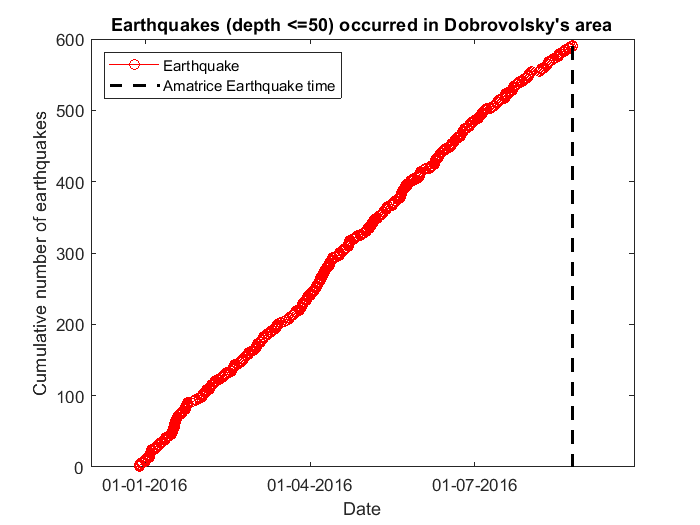

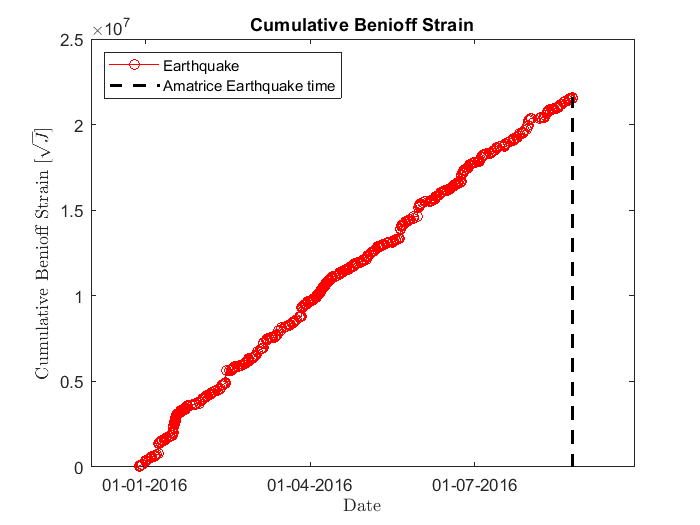

In [45]:
%Calculus of a vector that increases by one for each event.
cumulative_number = (1:size(EQ_sel,1))';
time_EQ_sel = datenum([EQ_sel(:,3:5), EQ_sel(:,8:10)]); 

%plot of the cumulative number of earthquakes over time.
figure;
plot(time_EQ_sel, cumulative_number, '-or');
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 cumulative_number(end)+1], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date')
ylabel('Cumulative number of earthquakes');
title(['Earthquakes (depth <=', num2str(max_depth), ') occurred in Dobrovolsky', 39, 's area']);
legend('Earthquake', 'Amatrice Earthquake time', 'Location', 'NorthWest')
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_EQ_number_vs_time.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_EQ_number_vs_time.fig']), "fig");


%Calculus of Richter earthquake energy released for each event in Joules
EQ_energy = 10.^(1.5*EQ_sel(:,6)+4.8);

%Calculus of the square root of earthquake energy for each event
EQ_sqrt_energy = nan(size(EQ_sel,1),1);
%Calculus of cumulative Benioff Strain as the sum of the square root of energy calculated above.
EQ_sqrt_energy(1,1) = sqrt(EQ_energy(1));
for i=2:size(EQ_sel, 1)
EQ_sqrt_energy(i,1) = EQ_sqrt_energy(i-1,1) + sqrt(EQ_energy(i));
end

%plot of the square root of the energy
figure;
plot(time_EQ_sel, EQ_sqrt_energy, '-or');
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 EQ_sqrt_energy(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Cumulative Benioff Strain [$\sqrt{J}$]', 'Interpreter', 'latex');
title(['Cumulative Benioff Strain']);
legend('Earthquake', 'Amatrice Earthquake time', 'Location', 'NorthWest')
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_Benioff_vs_time.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_Benioff_vs_time.fig']), "fig");



# Earthquake released energy as a function of the distance to the target earthquake
In the following, the earthquake released energy is weighted with the square distance to the incoming earthquake, according to the parameter $E_S$ introduced by prof. Katsumi Hattori (e.g., Hattori et al., 2013):  
$E_S = \sum_i{E_i \over r^2}$  
The parameter $E_S$ is calculated on all i-th events occurred in a single day.  
The concept is that an earthquake that happened closer to the future larger target is more important than one which is far.

<b> References: </b>  
Hattori, K.; Han, P.; Yoshino, C.; Febriani, F.; Yamaguchi, H.; Chen, C.-H. Investigation of ULF Seismo-Magnetic Phenomena in Kanto, Japan During 2000–2010: Case Studies and Statistical Studies. Surv Geophys 2013, 34, 293–316, doi:10.1007/s10712-012-9215-x.


number_of_analysed_days =    241

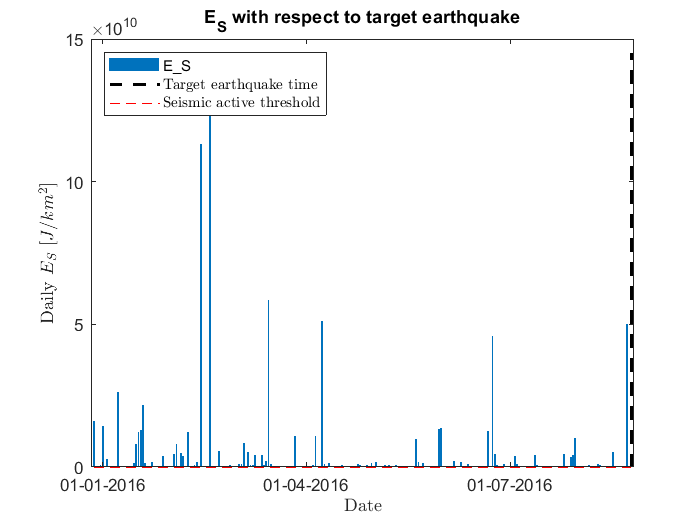

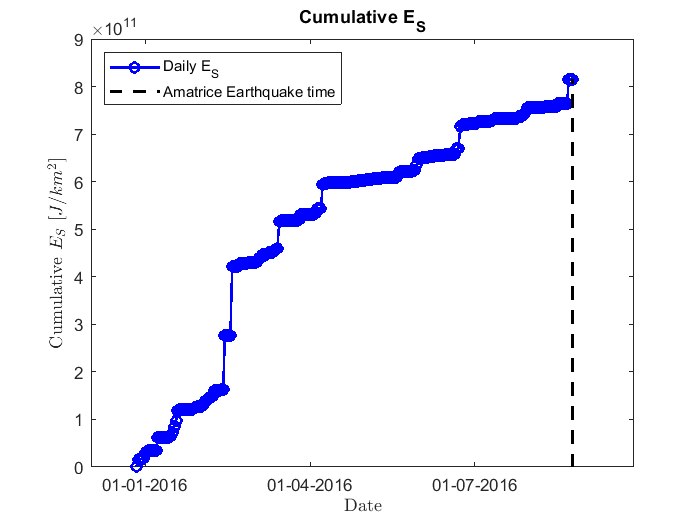

In [46]:
% Calculus of the Energy released by each earthquake divided by the square distance of the target event.
EQ_energy_for_ES = EQ_energy ./ (distance_from_target_EQ.^2);

% Calculus of daily Energy ES. At this purpose, the time span is firstly selected and then sum the energy ES for each event day-by-day
day_start = fix(time_start);
day_end = fix(time_end);
number_of_analysed_days = day_end - day_start + 1
% Creation of vector with daily energy ES basically equal to zero.
ES_Daily = zeros(number_of_analysed_days, 2);
% Calculus of actual daily energy ES.
k = 1;
for day_to_analysed = day_start:day_end
    [year_tba, month_tba, day_tba] = datevec(day_to_analysed);
    ES_Daily(k, :) = [day_to_analysed, sum(EQ_energy_for_ES(EQ_sel(:,3) == year_tba & EQ_sel(:,4) == month_tba & EQ_sel(:,5) == day_tba))];
    k = k + 1;
end

% plot of daily energy ES
figure;
bar(ES_Daily(:,1), ES_Daily(:,2));
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 max(ES_Daily(:,2))], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
line([day_start, day_end], [1e8, 1e8], 'LineStyle', '--', 'LineWidth', 1, 'Color', 'r');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Daily $E_S$ [$J/km^2$]', 'Interpreter', 'latex');
title(['E_S with respect to target earthquake']);
legend('E_S', 'Target earthquake time', 'Seismic active threshold', 'Location', 'NorthWest', 'Interpreter', 'latex')
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_ES_vs_time.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_ES_vs_time.fig']), "fig");

% Calculus of cumulative ES over time
cumulative_ES = zeros(size(ES_Daily,1)+1,2);
cumulative_ES(1,1) = day_start - 1;
k = 2;
for i = 1:size(ES_Daily, 1)
    cumulative_ES(k,:) = [ES_Daily(i,1), cumulative_ES(k-1, 2)+ES_Daily(i,2)];
    k = k + 1;
end

% Plot of the cumulative ES over time
figure
plot(cumulative_ES(:,1), cumulative_ES(:,2), '-ob', 'Linewidth', 1.5);
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 cumulative_ES(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Cumulative $E_S$ [$J/km^2$]', 'Interpreter', 'latex');
title(['Cumulative E_S']);
legend('Daily E_S', 'Amatrice Earthquake time', 'Location', 'NorthWest')
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_Cumulative_ES_vs_time.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_Cumulative_ES_vs_time.fig']), "fig");


# Analysis of vatiations of plates movements from EPOS GNSS Positions 
The following code extract the data from EPOS GNSS data service, searching for available stations inside the square inscribed in the Dobrovolskys's circle and then process the data calculating the differences between eventual GNSS stations along transects of the target fault strike.

number_of_GNSS_stations =    304

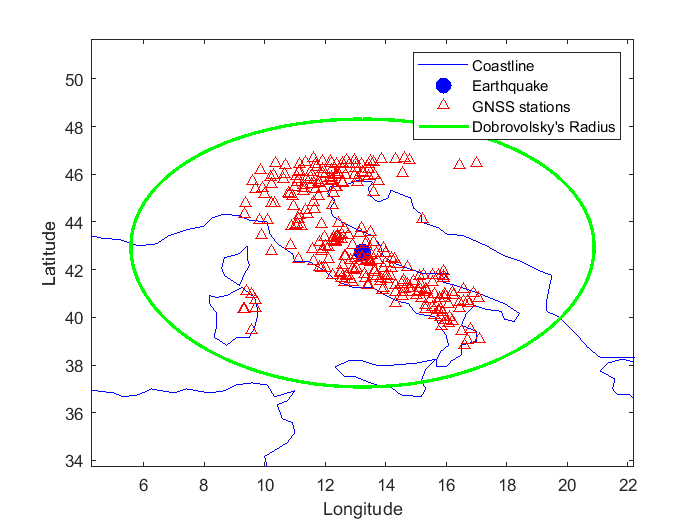

In [47]:
%Calculus of basic scientific parameters to setup the data request
%Calculus of earthquake origin time
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
%Calculus of time start and end of the VRE analysis
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
[year_start, month_start, day_start] = datevec(time_start);
[year_end, month_end, day_end] = datevec(time_end);
%Calculus of the research area and the limits in latitude and longitude to search for GNSS data (square inscribed in Dobrovolsky's area)
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = epilat - radius_Dobrovolsky/sqrt(2);
max_lat = epilat + radius_Dobrovolsky/sqrt(2);
min_lon = epilon - radius_Dobrovolsky/sqrt(2);
max_lon = epilon + radius_Dobrovolsky/sqrt(2);

%Construction of the URL to retrieve GNSS data with the above constraints
weburl_to_retrive_the_GNSS_station_list = ['https://gnssproducts.epos.ubi.pt/glass/products/velocities/geojson/SGO-EPND/', num2str(min_lon, '%.4f'), '/', num2str(min_lat, '%.4f'), '/', num2str(max_lon, '%.4f'), '/', num2str(max_lat, '%.4f'), '/'];
%Request of GNSS station list to EPOS data portal
GNSS_station_list = webread(weburl_to_retrive_the_GNSS_station_list);
%Organisation of the result from the EPOS data portal in a struct with one item for each retrieved stations
data_from_GNSS = {};
k_GNSS = 1;
if size(GNSS_station_list, 1) > 0
    GNSS_station_list = GNSS_station_list.features;
    number_of_GNSS_stations = size(GNSS_station_list, 1)
    if number_of_GNSS_stations > 0
        coordinates_of_GNSS = nan(number_of_GNSS_stations, 2);
        for i = 1:number_of_GNSS_stations
%It's necessary to insert a test of time availability inside the VRE time of interest
            coordinates_of_GNSS(i,1) = GNSS_station_list(i).properties.Longitude;
            coordinates_of_GNSS(i,2) = GNSS_station_list(i).properties.Latitude;
            weburl_to_retrive_the_data = ['https://gnssproducts.epos.ubi.pt/GlassFramework/webresources/products/timeseries/', GNSS_station_list(i).properties.GNSSStationID, '/SGO-EPND/weekly/enu/json/?epoch_start=', num2str(year_start), '-', num2str(month_start, '%02.0f'), '-', num2str(day_start, '%02.0f'), '&epoch_end=', num2str(year_end), '-', num2str(month_end, '%02.0f'), '-', num2str(day_end, '%02.0f')]; 
            GNSS_data = webread(weburl_to_retrive_the_data);
            if strcmp(GNSS_data, 'No data available') == 0
%In this case, there is available data, and we keep this data
                GNSS_data = GNSS_data.results;
%Organise the data from the stations in the array "extracted_data" with each row for a specific epoch:
% timestamp | North component | East component | Up component
                extracted_data = nan(size(GNSS_data,1), 4);
                for k = 1:size(GNSS_data,1)
                    extracted_data(k,1) = datenum(GNSS_data(k).epoch);
                    extracted_data(k,2) = GNSS_data(k).dn; %North GNSS component timeseries
                    extracted_data(k,3) = GNSS_data(k).de; %East GNSS component timeseries
                    extracted_data(k,4) = GNSS_data(k).du; %Up GNSS component timeseries
                end
% Extraction of the coordinates of the specific GNSS station
                data_from_GNSS{k_GNSS, 1}.coordinates = coordinates_of_GNSS(i,:);
                data_from_GNSS{k_GNSS, 1}.data = extracted_data;
                k_GNSS = k_GNSS + 1;
            end                      
        end
    end
end

%Plot of the map of the available GNSS stations from EPOS data portal 
coordinates_for_map = nan(k_GNSS-1, 2);
for i=1:(k_GNSS-1)
    coordinates_for_map(i,:) = data_from_GNSS{i}.coordinates;
end
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(epilon, epilat, 'ob', 'MarkerSize', 10, 'MarkerFaceColor', 'b')
plot(coordinates_for_map(:,1), coordinates_for_map(:,2), '^r');
[aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
plot(bbs,aas,'-g', 'LineWidth',2);
axis([min_lon-5 max_lon+5 min_lat-5 max_lat+5]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', 'GNSS stations', ['Dobrovolsky', 39 ,'s Radius']);

The following block calculates some basic parameters to analyse the data from the GNSS stations.  
In particular, the **angular tolerance** is a parameter to consider aligning two different stations eventually with respect to the fault direction (or its perpendicular direction for transect). The **maximum distance** is the segment, along the fault direction, to be investigated and it's defined as 10 times the broken fault segment.

In [48]:
angular_tollerance = 5; %maximum angular difference to be considered on the same direction
distance_GNSS_station_EQ = distance(coordinates_for_map(:,2), coordinates_for_map(:,1), epilat, epilon)*111;
angle_to_EQ = atan2d((coordinates_for_map(:,2)-epilat),(coordinates_for_map(:,1)-epilon));
Length_of_broken_fault = 3 * EQ_depth; %Proposed in Doglioni et al., Sci. Rep., 2015
Maximum_distance = 10 * Length_of_broken_fault / 2 %searching for a distance of 10 times the broken segment and symmetrical to the epicenter.
%Maximum distance is calculated in km


Maximum_distance =    150

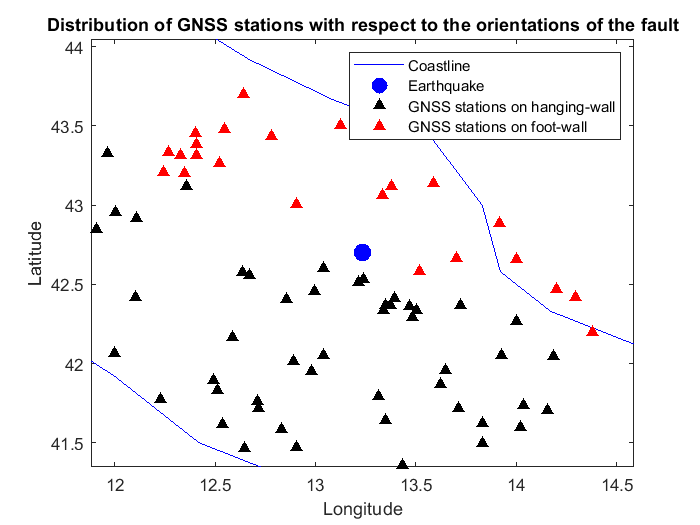

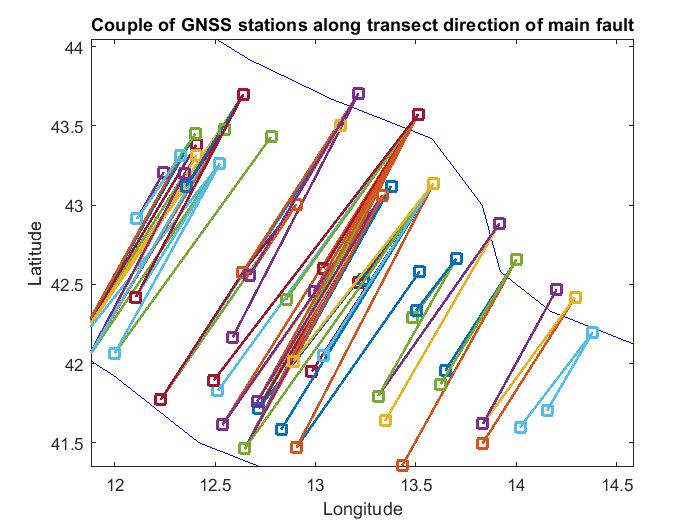

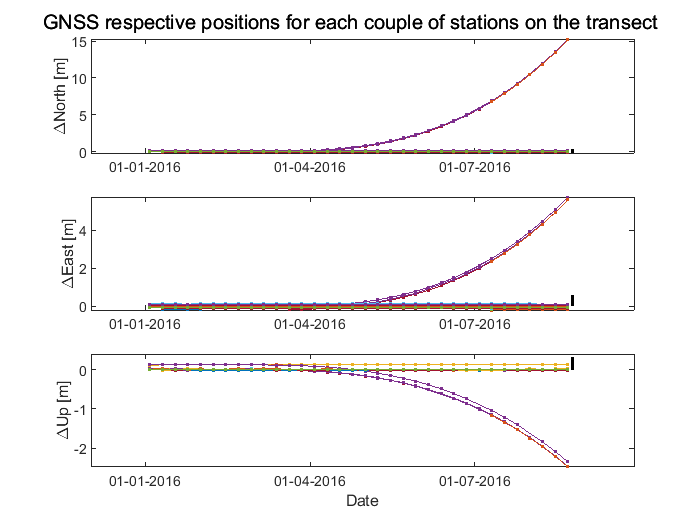

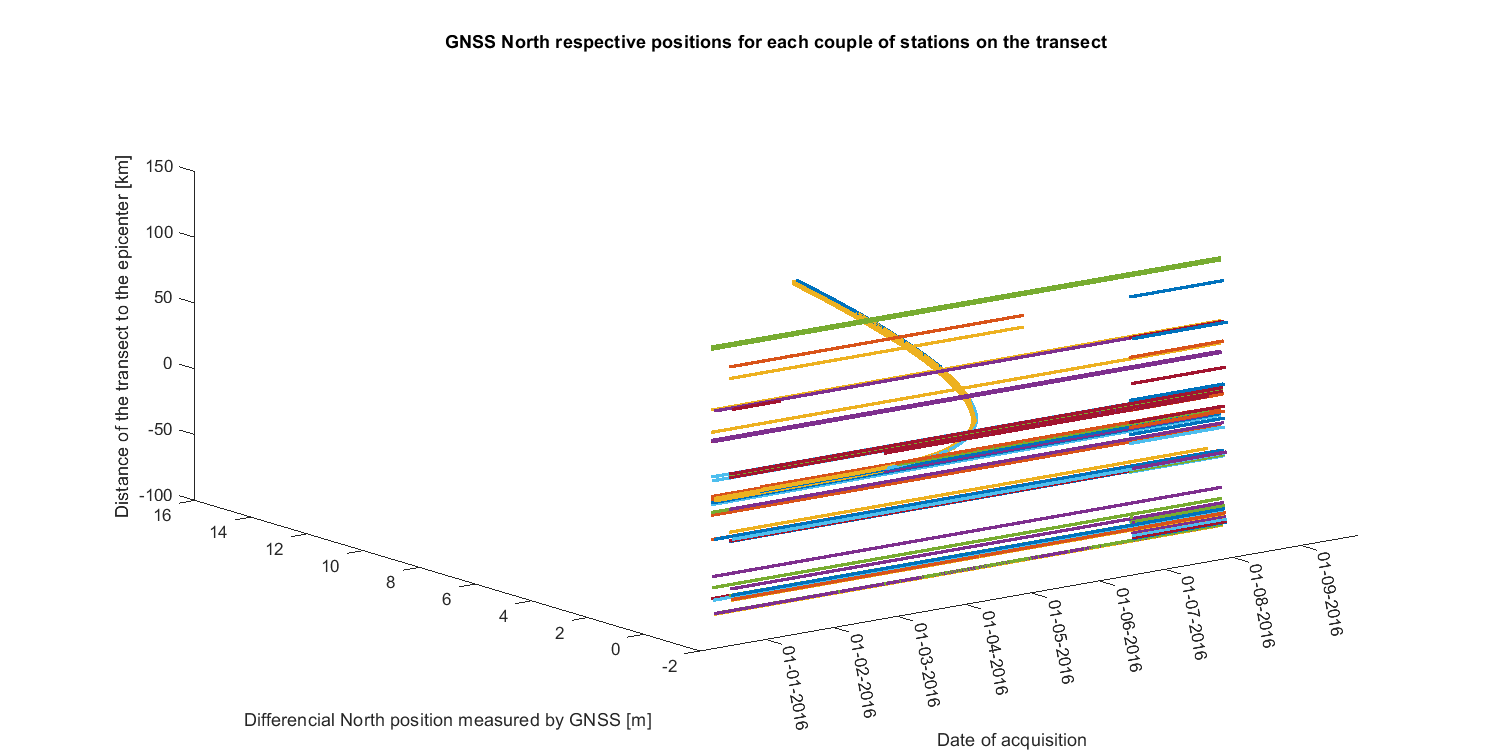

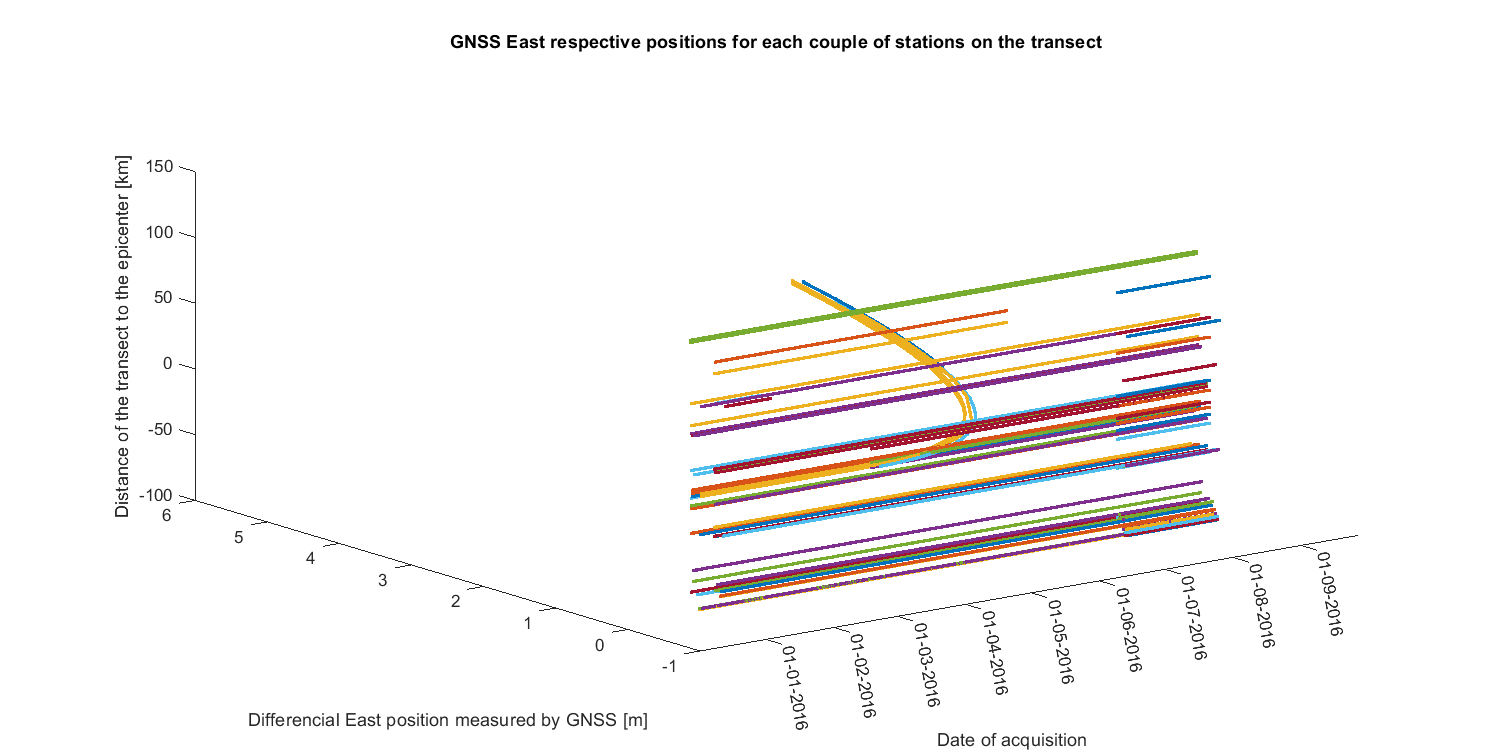

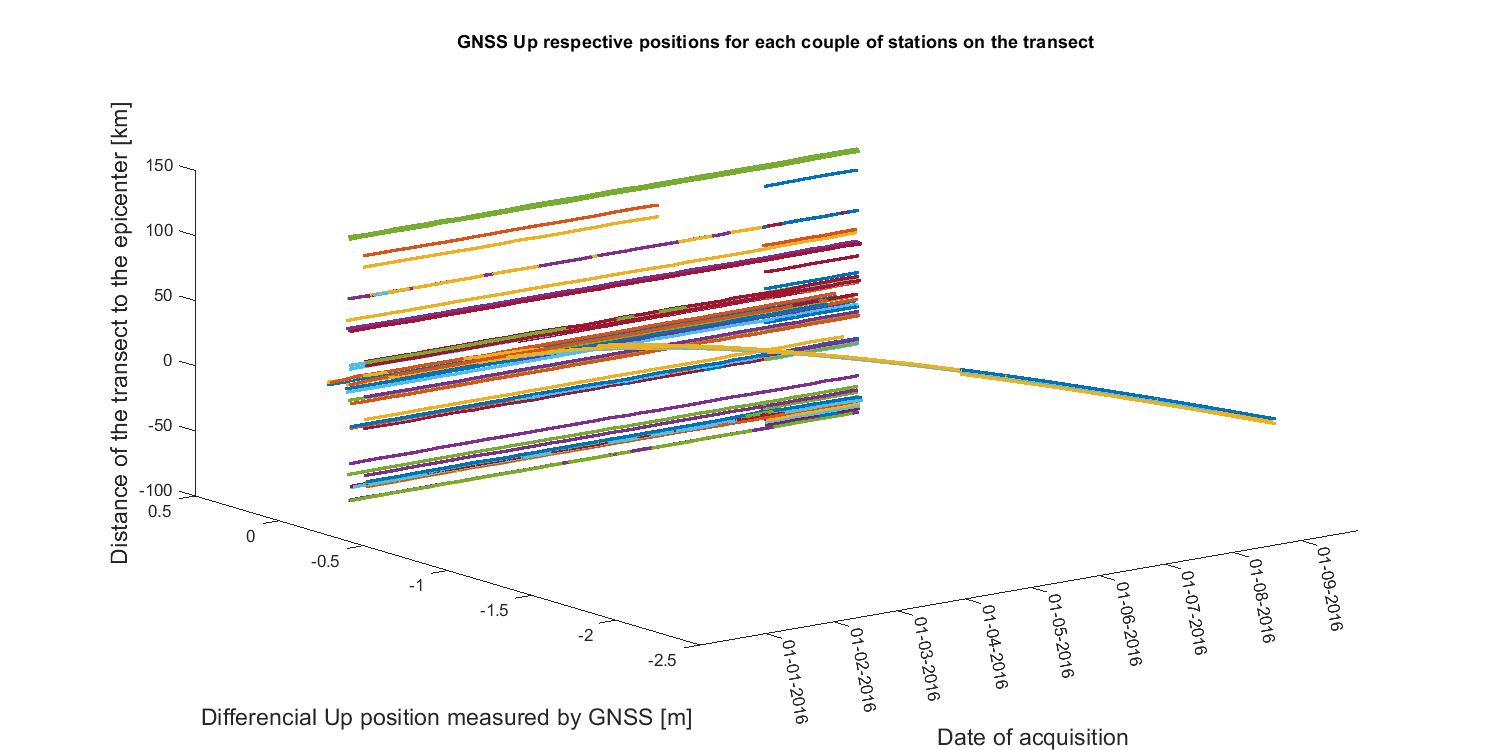

In [49]:
% Calculus of the straight angle of fault strike (same direction opposite verse)
Complementary_strike_angle = Fault_strike - 180;
% Calculus of the perpendicular direction to the one of the fault (transect direction)
Perpendicular_angle = Fault_strike - 90;
% Selection of the GNSS stations that rely on the side of the footwall or hanging wall with respect to the main fault.
% The selection is based on the comparison of the angle of the specific station with respect to the target earthquake.
GNSS_stations_on_footwall = data_from_GNSS((angle_to_EQ > Complementary_strike_angle & angle_to_EQ < Fault_strike) & distance_GNSS_station_EQ <= Maximum_distance);
GNSS_stations_on_hanging = data_from_GNSS((angle_to_EQ < Complementary_strike_angle | angle_to_EQ > Fault_strike) & distance_GNSS_station_EQ <= Maximum_distance);
% Collection of the GNSS coordinates for the two groups of stations
for i = 1:size(GNSS_stations_on_hanging, 1)
    GNSS_stations_on_hanging_coordinates(i,:) = GNSS_stations_on_hanging{i}.coordinates;
end
for i = 1:size(GNSS_stations_on_footwall, 1)
    GNSS_stations_on_footwall_coordinates(i,:) = GNSS_stations_on_footwall{i}.coordinates;
end

% Creation of a map with the division of GNSS stations on the side of the footwall or hanging wall
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(epilon, epilat, 'ob', 'MarkerSize', 10, 'MarkerFaceColor', 'b')
plot(GNSS_stations_on_hanging_coordinates(:,1), GNSS_stations_on_hanging_coordinates(:,2), '^k', 'MarkerFaceColor', 'k');
plot(GNSS_stations_on_footwall_coordinates(:,1), GNSS_stations_on_footwall_coordinates(:,2), '^r', 'MarkerFaceColor', 'r');
axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', 'GNSS stations on hanging-wall', 'GNSS stations on foot-wall');
title('Distribution of GNSS stations with respect to the orientations of the fault');

% Preparation of two figures: one is the map (figure_2_handle) with a couple of GNSS stations whose direction is perpendicular to the fault strike.
% The other figure (figure_1_handle) presents the results of the differential displacement for each couple of GNSS stations
figure_2_handle = figure;
load coastlines
plot(coastlon, coastlat, '-b');
hold on;
axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
xlabel('Longitude')
ylabel('Latitude')
title('Couple of GNSS stations along transect direction of main fault');

figure_1_handle = figure;
%this figure is divided in three panels for each component of GNSS signal in the form of time series.
%North
subplot(3,1,1)
plot([EQ_time, EQ_time], [-0.2, 0.4], '--k', 'LineWidth', 2);
hold on; %Allows to superpose the time series from different couples of GNSS stations    
%East
subplot(3,1,2)
plot([EQ_time, EQ_time], [0, 0.6], '--k', 'LineWidth', 2);
hold on;
%Up
subplot(3,1,3)
plot([EQ_time, EQ_time], [0, 0.4], '--k', 'LineWidth', 2);
hold on;

%the results are also stored in a structure called results_from_perpendicular_stations
results_from_perpendicular_stations = {};
k_stations = 1;
for i = 1:size(GNSS_stations_on_hanging, 1)
    % Calculate the angle of a station on footwall with respect to the i-station on hanging wall 
    angle_to_station = atan2d(GNSS_stations_on_footwall_coordinates(:,2)-GNSS_stations_on_hanging_coordinates(i,2),GNSS_stations_on_footwall_coordinates(:,1)-GNSS_stations_on_hanging_coordinates(i,1));
    % Select only the stations that are perpendicular to fault strike (i.e., they are on a transect).
    index_good_stations_footwall = find(abs(angle_to_station - (Fault_strike-90))  <= angular_tollerance | abs(angle_to_station - (Fault_strike - 270)) <= angular_tollerance);
    if size(index_good_stations_footwall, 1) > 0
        % Extract the data from the first station
        data_from_station_1 = GNSS_stations_on_hanging{i}.data;
        for k=1:size(index_good_stations_footwall, 1)
            % Extract the data from the second station
            data_from_station_2 = GNSS_stations_on_footwall{index_good_stations_footwall(k)}.data;
            % In order to compare the observations the measurements from second station are resampled on the time of the first station that in principle they could be different
            data_from_station_2_resamples = nan(size(data_from_station_1,1), 4);
            data_from_station_2_resamples(:,1) = data_from_station_1(:,1);
            data_from_station_2_resamples(:,2) = interp1(data_from_station_2(:,1),data_from_station_2(:,2), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            data_from_station_2_resamples(:,3) = interp1(data_from_station_2(:,1),data_from_station_2(:,3), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            data_from_station_2_resamples(:,4) = interp1(data_from_station_2(:,1),data_from_station_2(:,4), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            % Differences of GNSS measurements for the three components for a specific couple of GNSS station
            differences_GNSS = (data_from_station_1(:,2:4) - data_from_station_2_resamples(:,2:4));
            % The following calculus computes the distance of the transect from the epicenter.
            %The Heron's  formula is used: area  = sqrt(s(s-a)*(s-b)*(s-c))
            % Calculus of the length of the first side
            distance_st1_st2 = distance(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), ...
            GNSS_stations_on_hanging{i}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(1));
            % Calculus of the length of the second side
            distance_st1_EQ = distance(epilat, epilon, GNSS_stations_on_hanging{i}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(1));
            % Calculus of the length of the third side
            distance_EQ_st2 = distance(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), epilat, epilon); 
            semiperimeter = 0.5 * (distance_st1_st2+distance_st1_EQ+distance_EQ_st2);
            area = sqrt(semiperimeter*(semiperimeter-distance_st1_st2)*(semiperimeter-distance_st1_EQ)*(semiperimeter-distance_EQ_st2));
            height_triangle = 2 * area / distance_st1_st2;
            % Calculus of the distance of transect in km considering that 1 degree is about 111 km on Earth's Surface
            distance_st1_st2_from_EQ = height_triangle * 111;
            % Check if the transect is in one or opposite side of the earthquake
            angle_of_st2_to_EQ = atan2d(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2)-epilat,GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1)-epilon);
            % In case is in the opposite side the distance is converted as negative
            if angle_of_st2_to_EQ > Perpendicular_angle
                distance_st1_st2_from_EQ = - distance_st1_st2_from_EQ;
            end
            % Plot the coordinates of the couple of stations on the map
            figure(figure_2_handle)
            plot([GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), GNSS_stations_on_hanging{i}.coordinates(1)], [GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(2)], 's-', 'LineWidth', 1.5, 'MarkerSize', 8);
            % Store the results
            results_from_perpendicular_stations{k_stations,1}.distance = distance_st1_st2_from_EQ;
            results_from_perpendicular_stations{k_stations,1}.differences_GNSS = differences_GNSS;
            results_from_perpendicular_stations{k_stations,1}.time_differences_GNSS = data_from_station_1(:,1);
            results_from_perpendicular_stations{k_stations,1}.distance_st1_st2 = distance_st1_st2;
            k_stations = k_stations + 1;
            % Plot the time series in the other graph
            figure(figure_1_handle)
            subplot(3,1,1)
            % North GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,1), '.-');
            subplot(3,1,2)
            % East  GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,2), '.-');
            subplot(3,1,3)
            % Up  GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,3), '.-');
        end
    end
end

% Complete the time series graph with labels and convert the time axis into a better visualization
subplot(3,1,1)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
ylabel('\DeltaNorth [m]');
%legend('NumColumns', 3);
subplot(3,1,2)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
ylabel('\DeltaEast [m]');
subplot(3,1,3)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date')
ylabel('\DeltaUp [m]');
sgtitle("GNSS respective positions for each couple of stations on the transect", 'FontSize', 12)


% Repeat the previous graph of the time series in a separated 3D plot for time series with the vertical axis 
% in function of the transect distance to the earthquake 
%Preparation of large figure for North component
figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,1), distance_GNSS*ones(size(time_data_station, 1), 1), '.-', 'LineWidth', 2);
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial North position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');
title("GNSS North respective positions for each couple of stations on the transect")
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_GNSS_timeseries_North.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_GNSS_timeseries_North.fig']), "fig");

% Preparation of large figure for the East component
figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,2), distance_GNSS*ones(size(time_data_station, 1), 1), '.-', 'LineWidth', 2);
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial East position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');
title("GNSS East respective positions for each couple of stations on the transect")
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_GNSS_timeseries_East.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_GNSS_timeseries_East.fig']), "fig");

% Preparation of a large figure for the Up component
figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,3), distance_GNSS*ones(size(time_data_station, 1), 1), '.-', 'LineWidth', 2);
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition', 'FontSize', 14)
ylabel('Differencial Up position measured by GNSS [m]', 'FontSize', 14)
zlabel('Distance of the transect to the epicenter [km]', 'FontSize', 14);
title("GNSS Up respective positions for each couple of stations on the transect")
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_GNSS_timeseries_Up.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_GNSS_timeseries_Up.fig']), "fig");


## Creations of maps of GNSS rate of displacements
The following code calculates the rate of GNSS displacement in the form of maps.  
It first homogenises the data in a three-dimensional vector with time and space positions as coordinates. It fills the missing gaps whenever possible and after it calculates the difference of GNSS positions for each component divided by the time span between the two measurements, which is generally one week.  
It then plots the interpolated maps for the North, East Up component for each time step (generally one week if data are available).

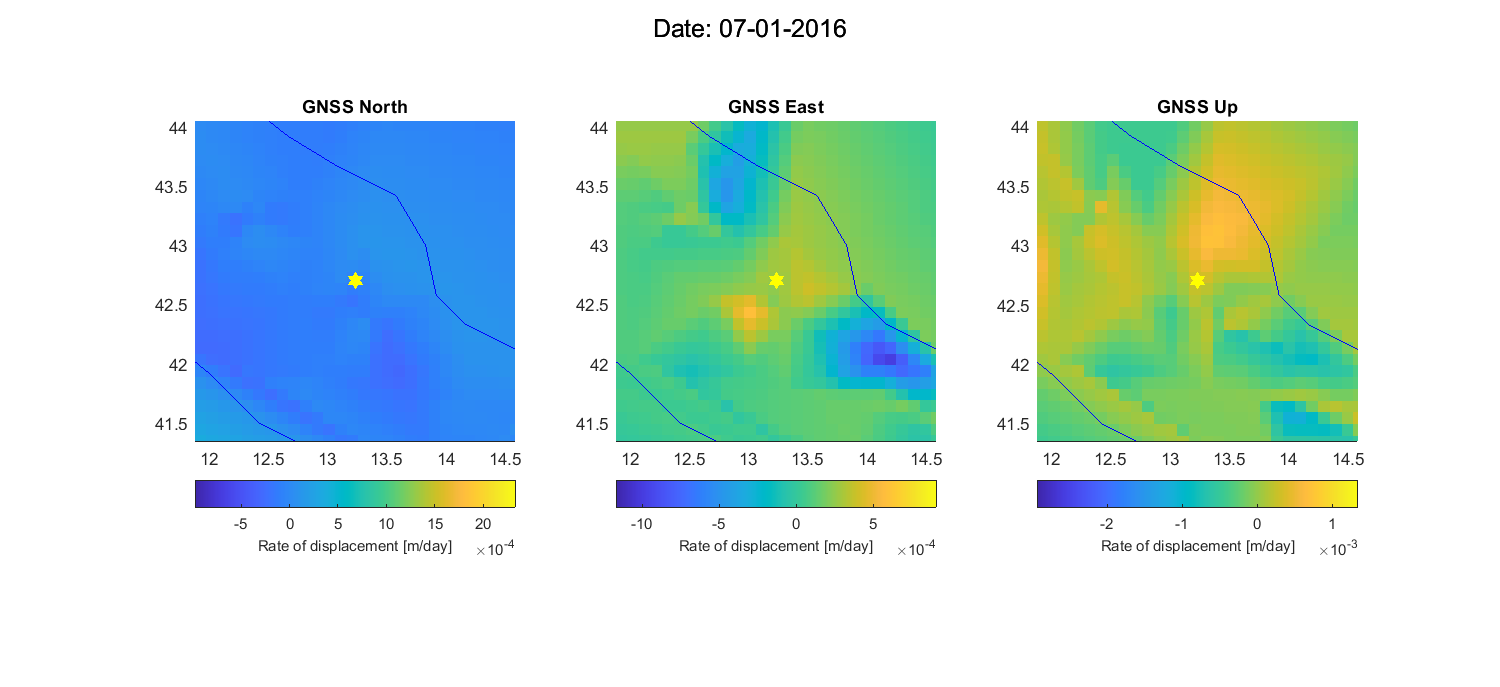

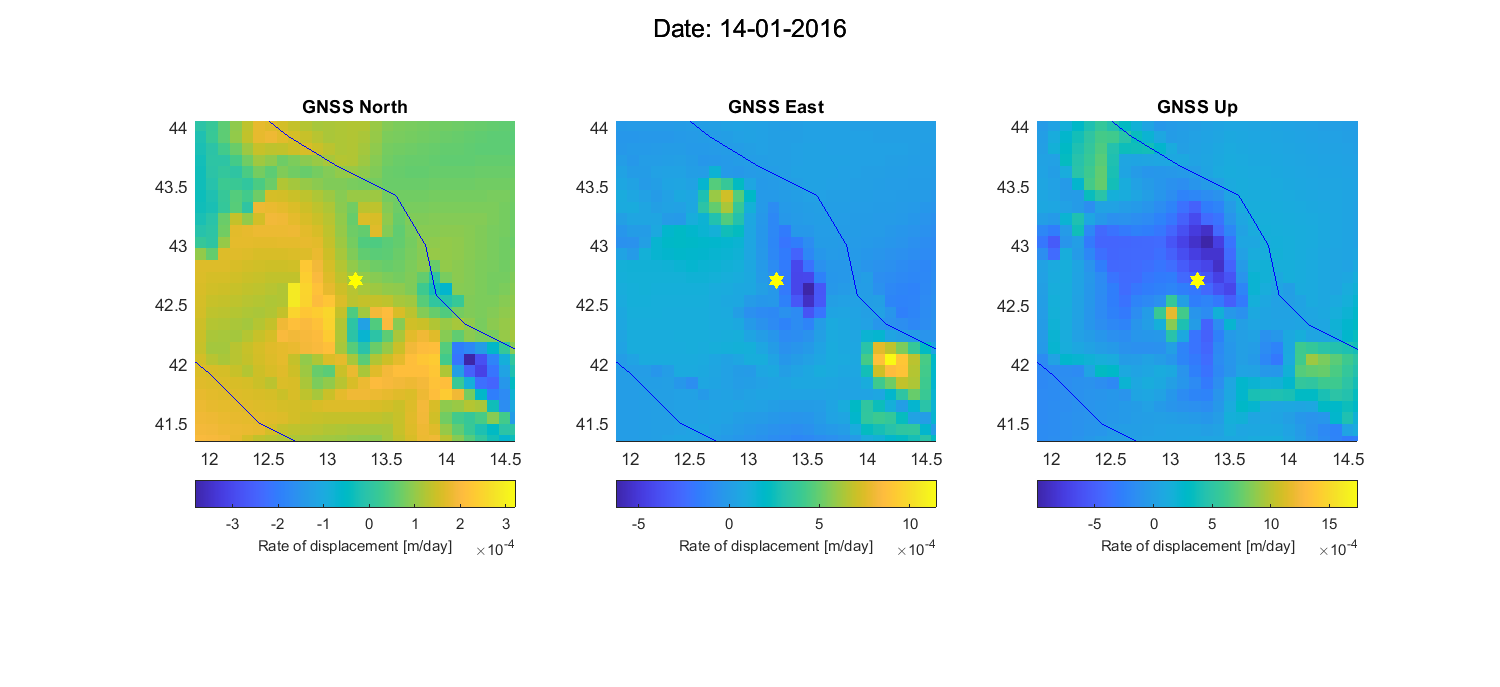

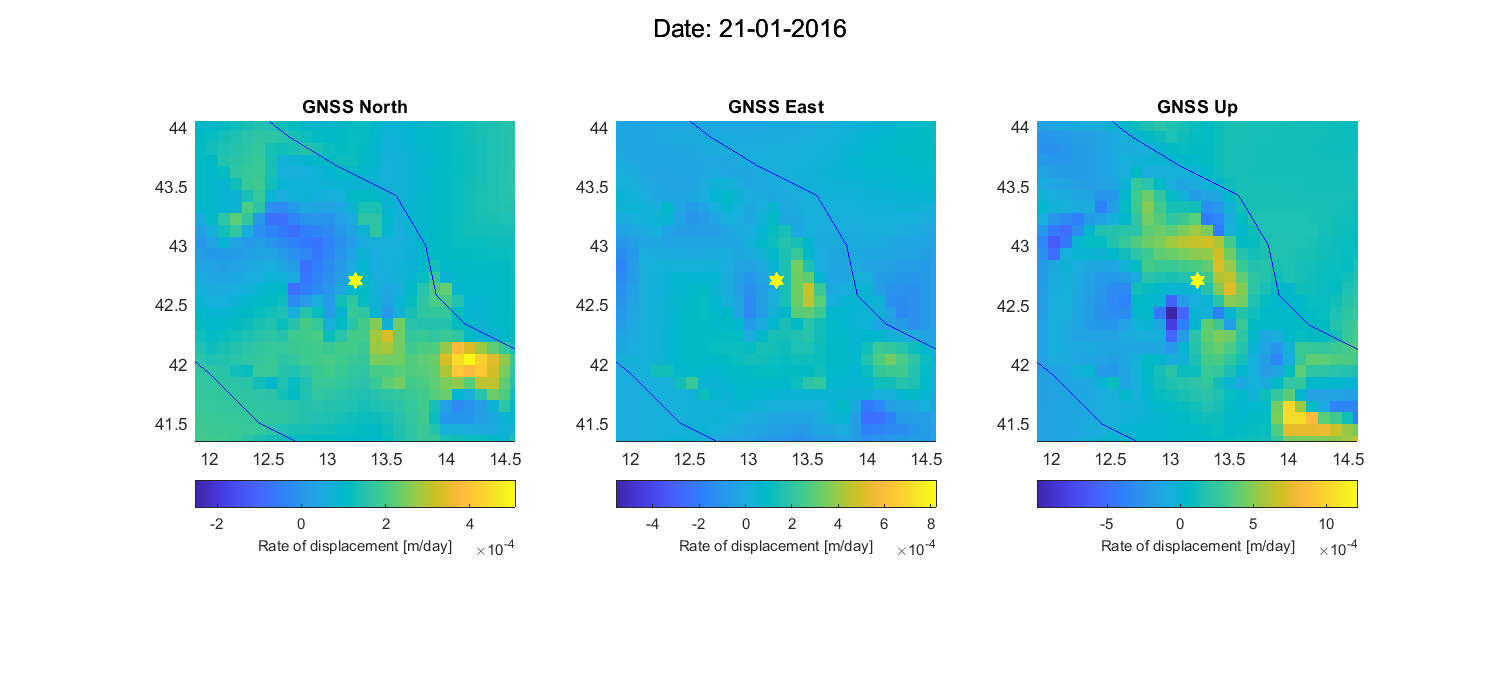

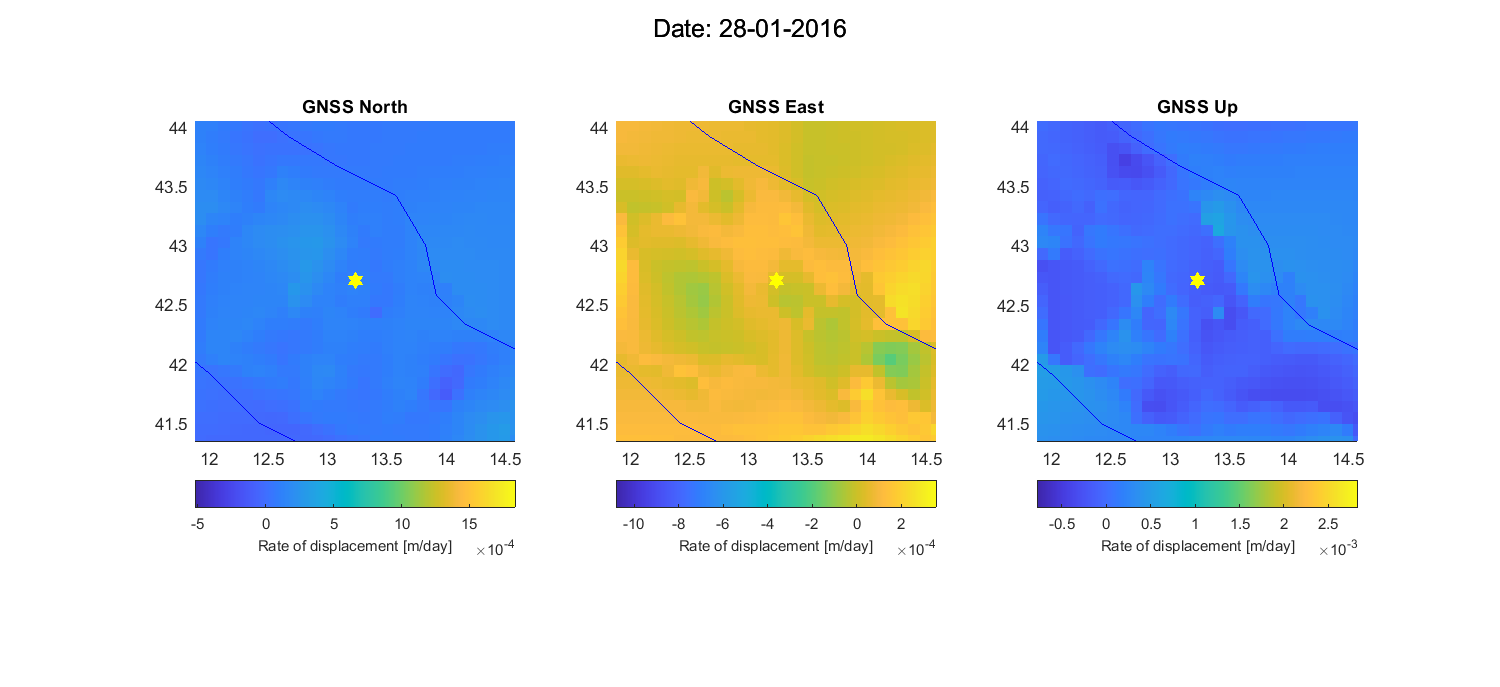

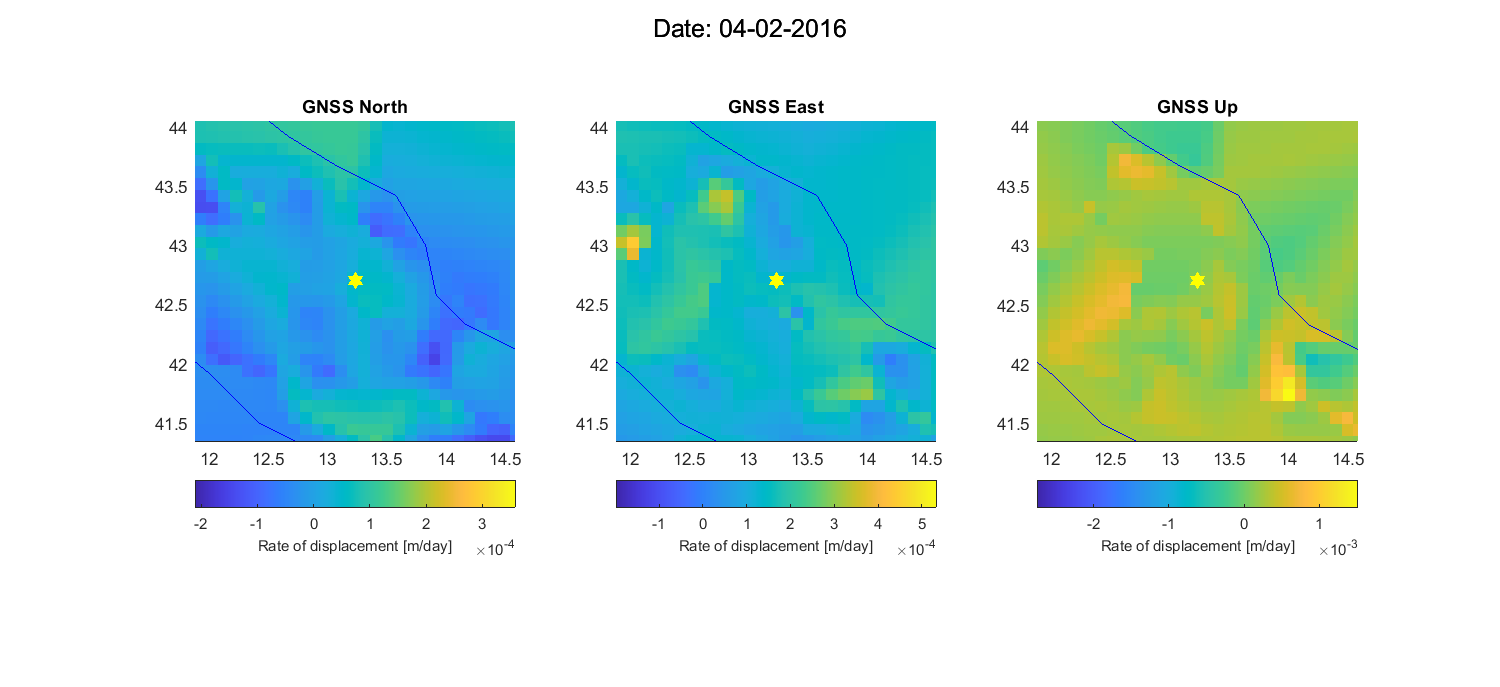

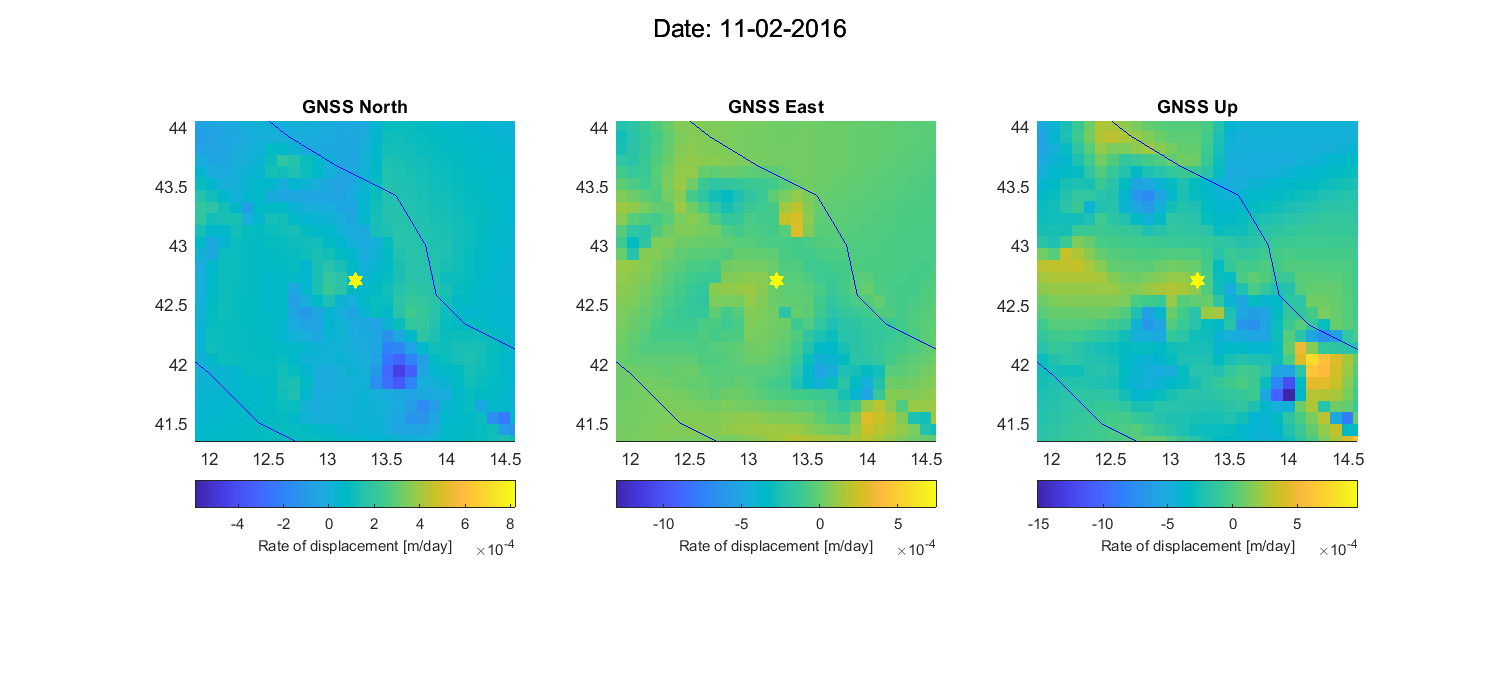

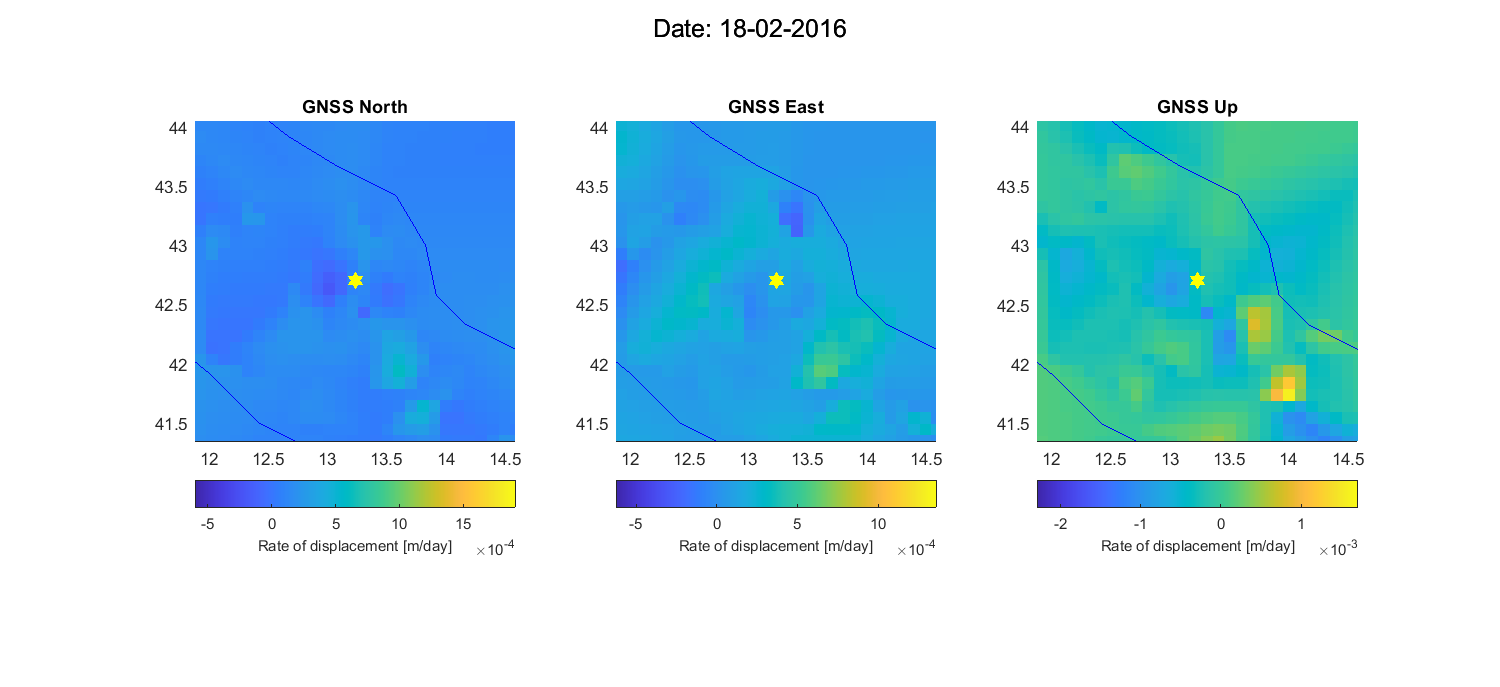

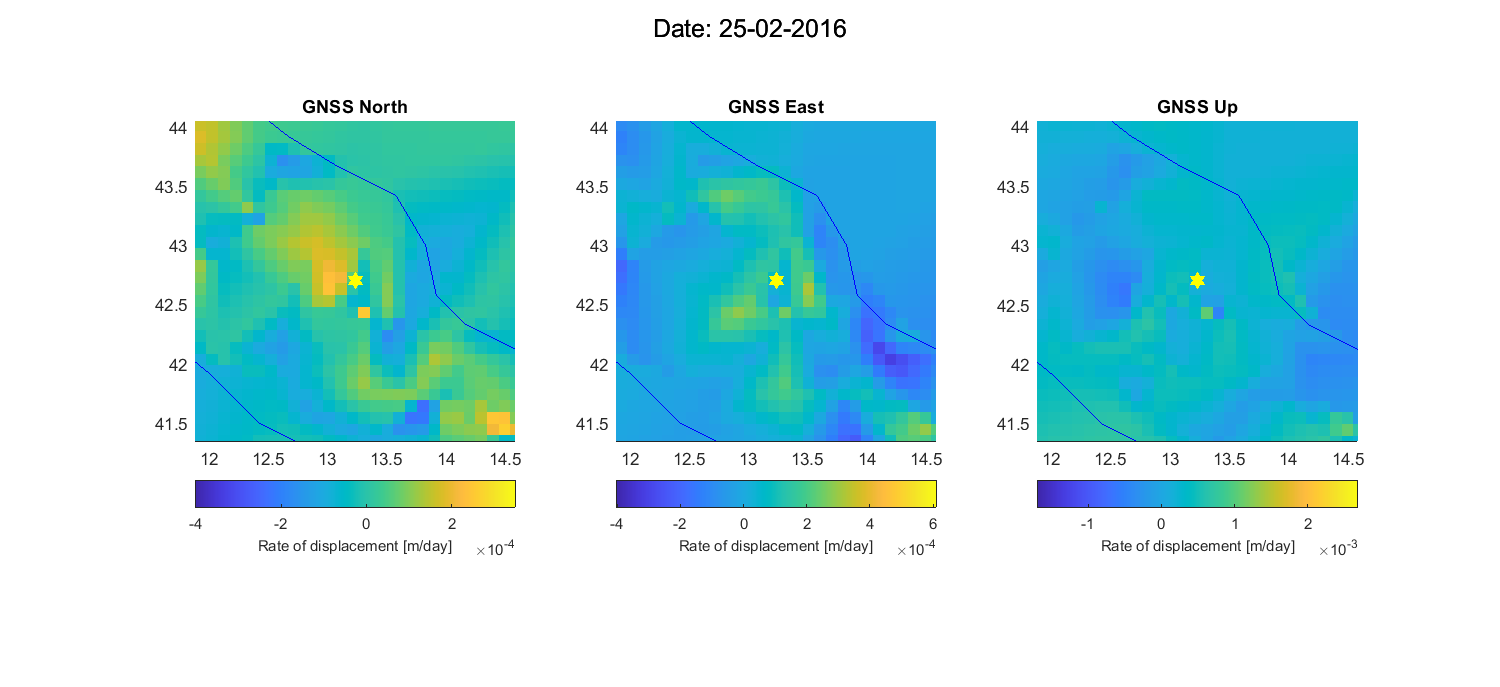

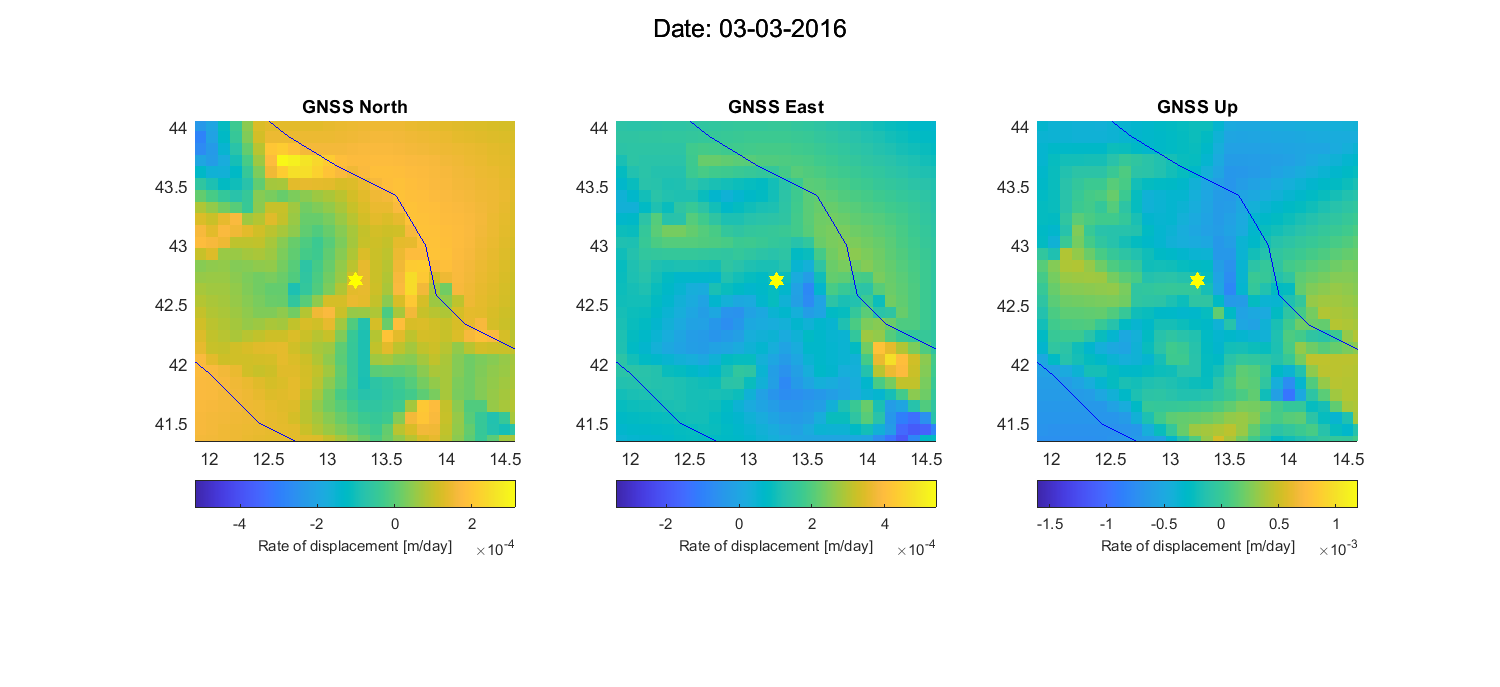

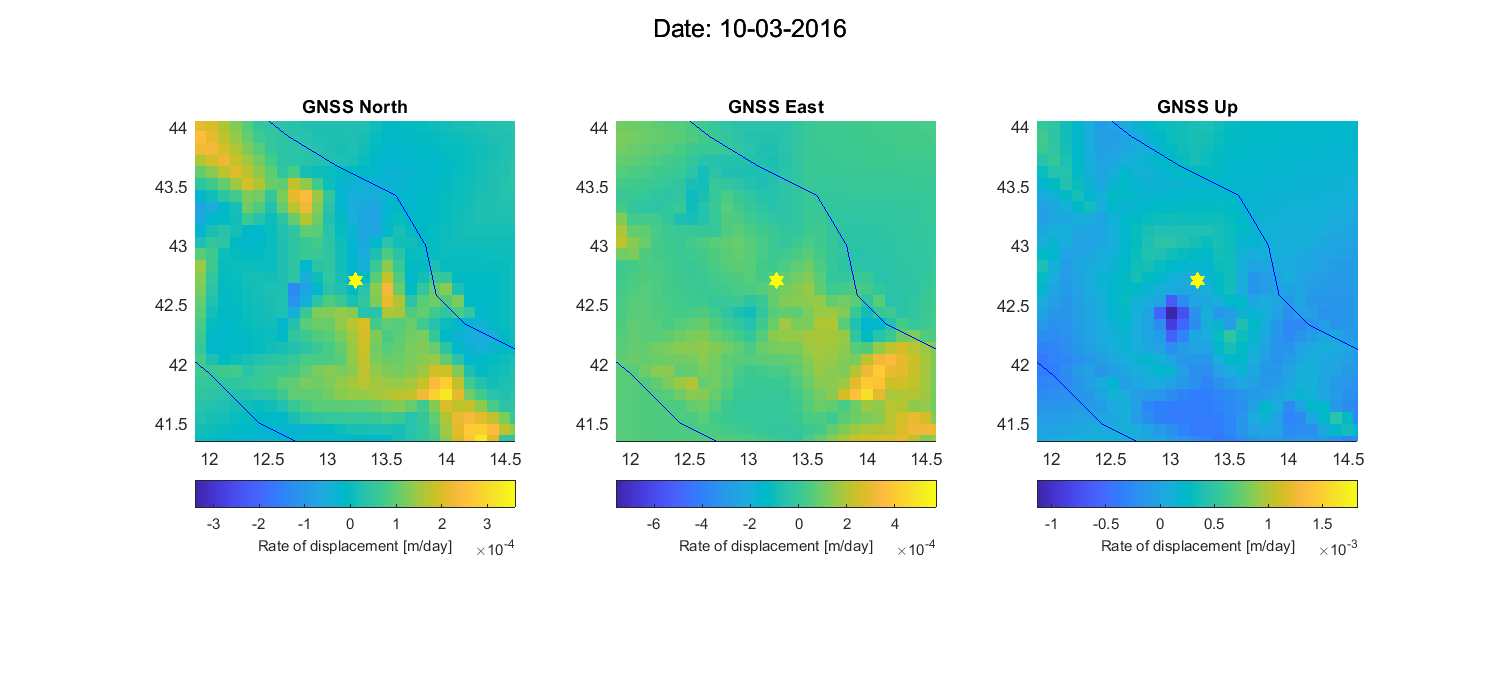

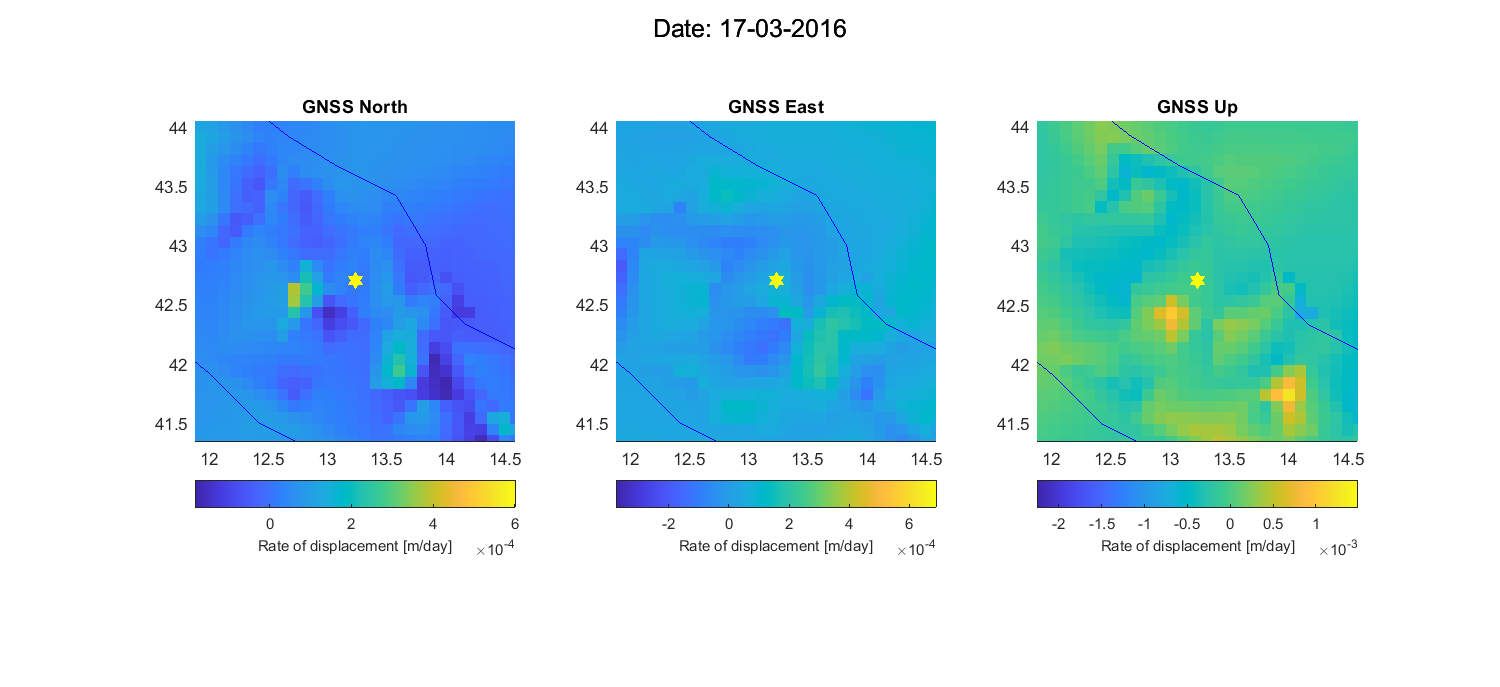

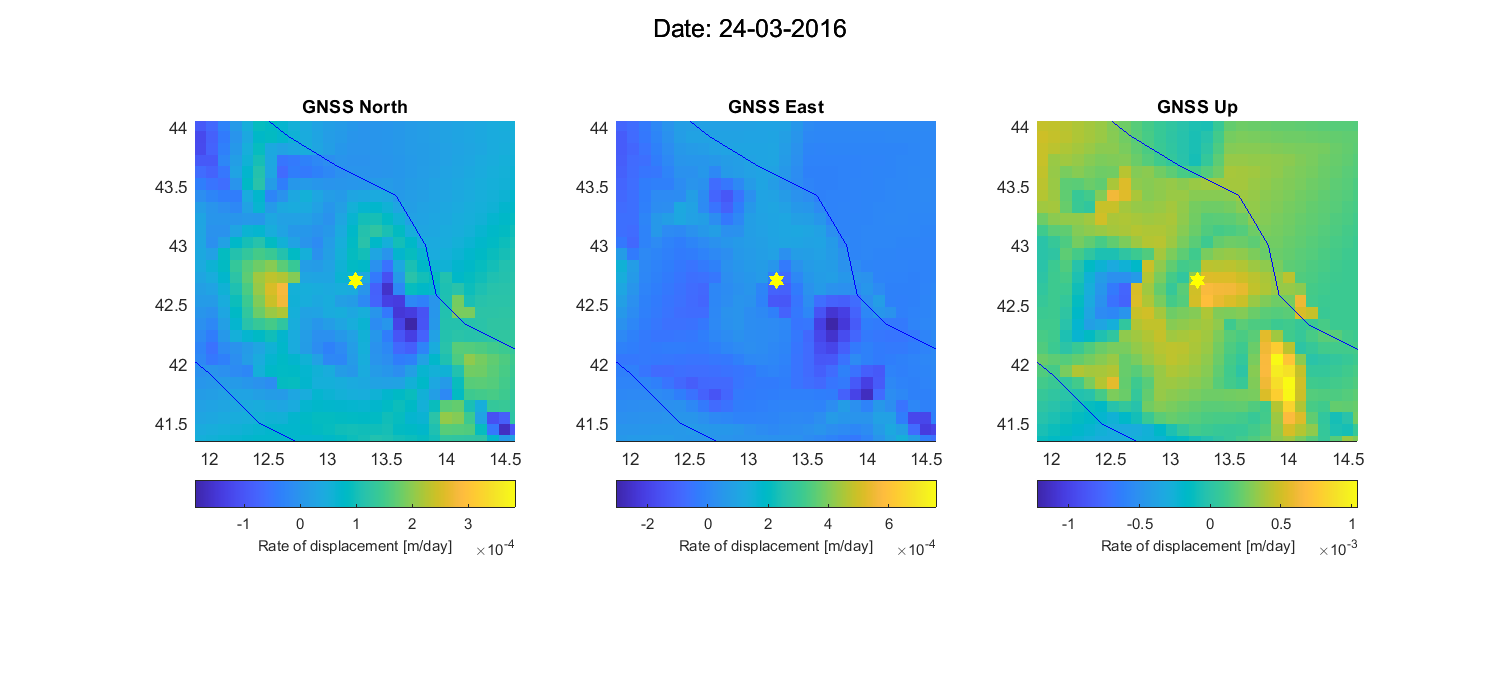

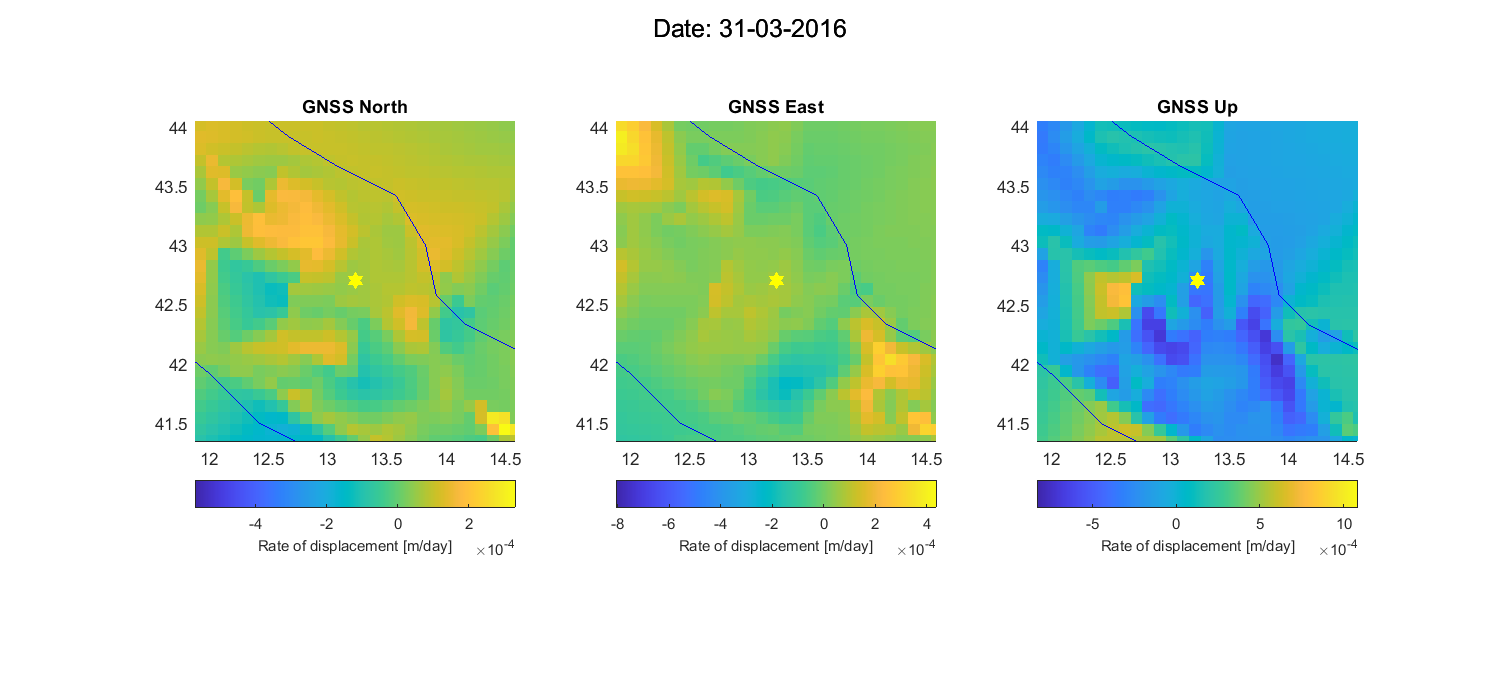

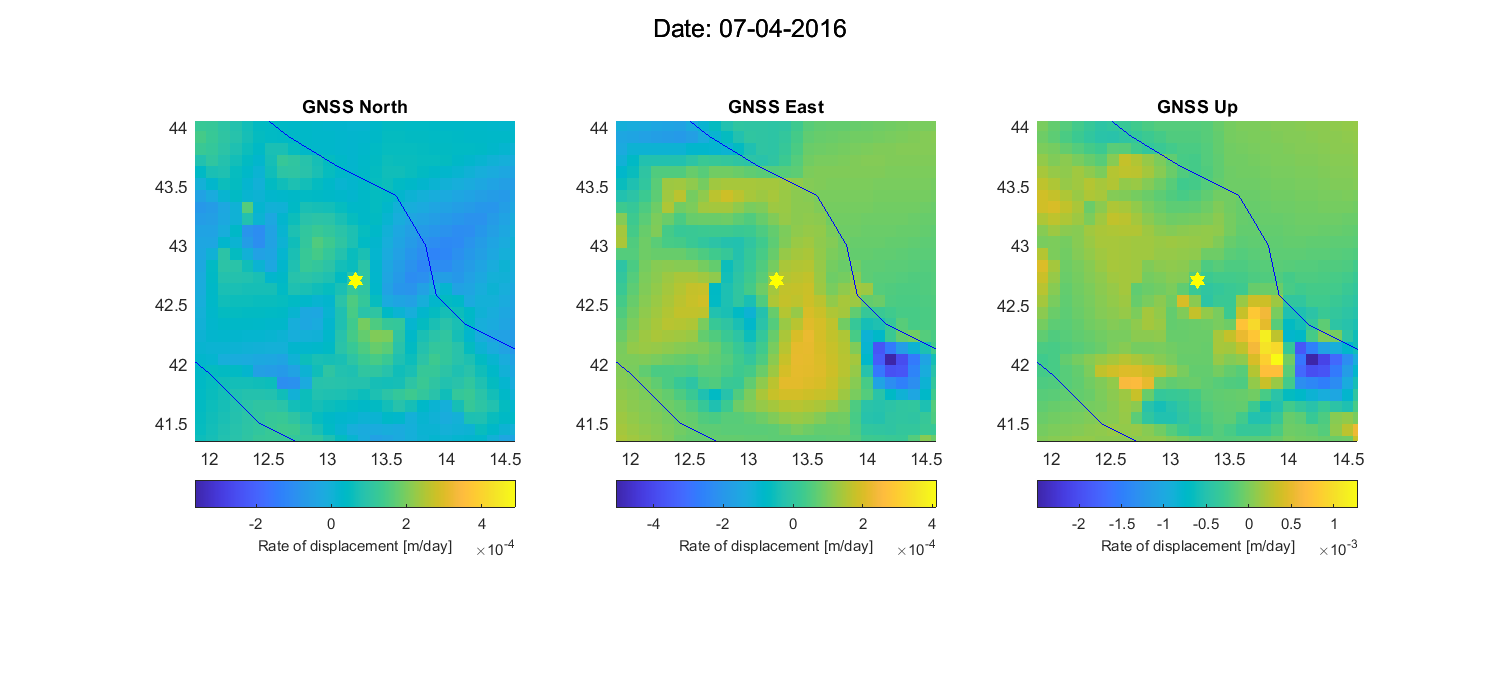

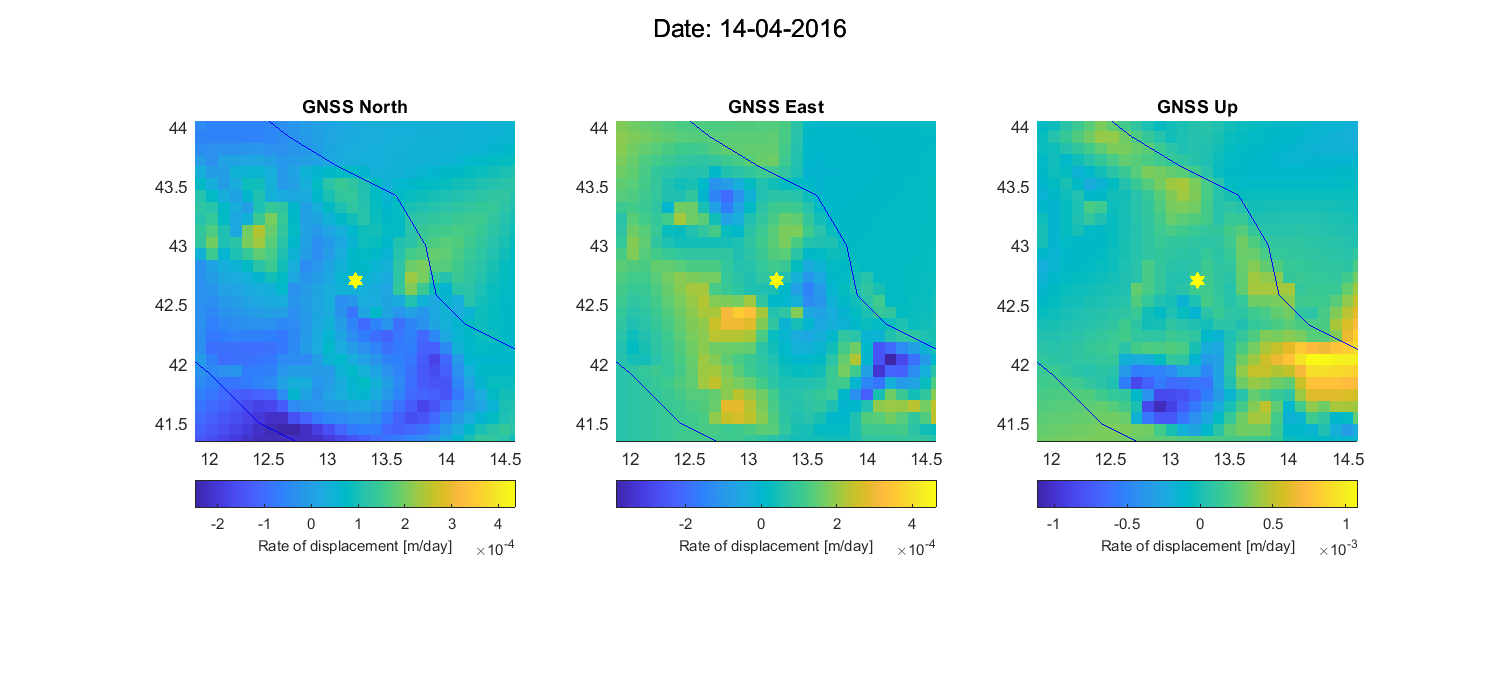

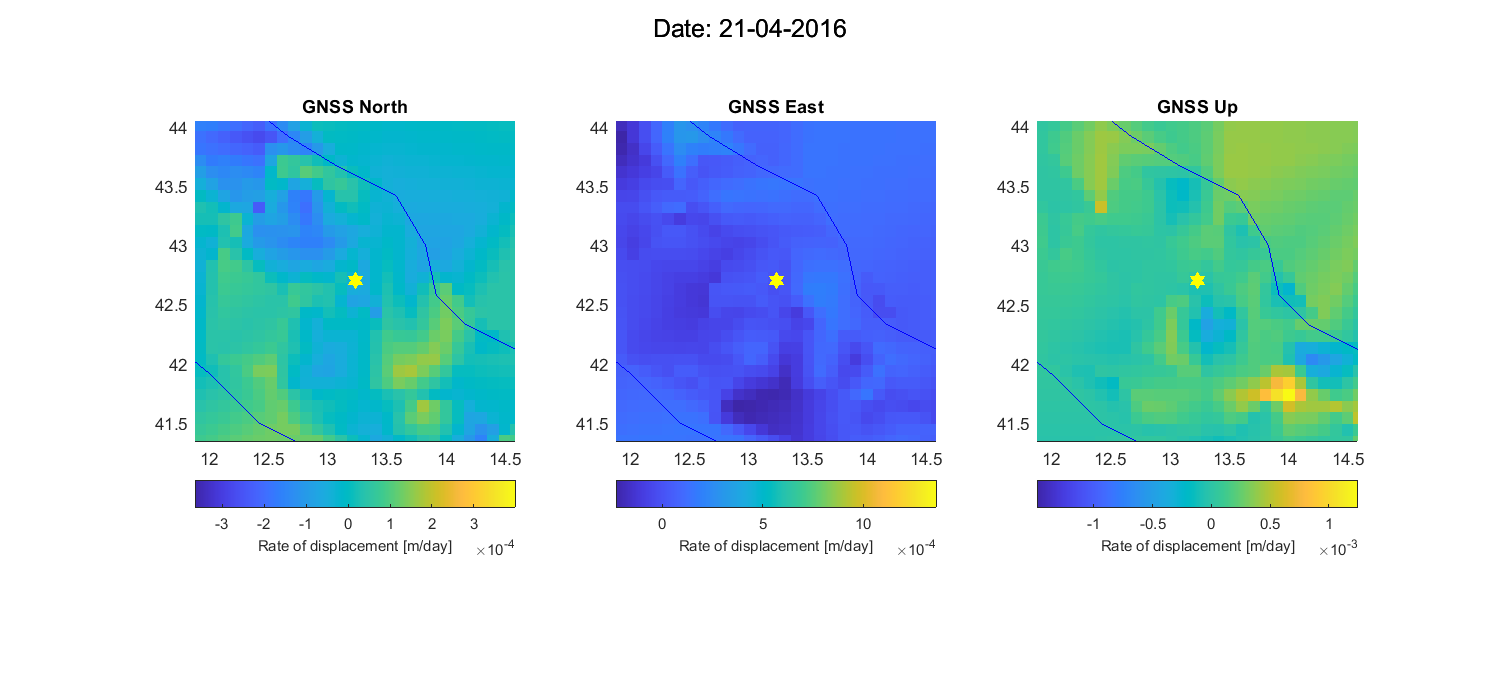

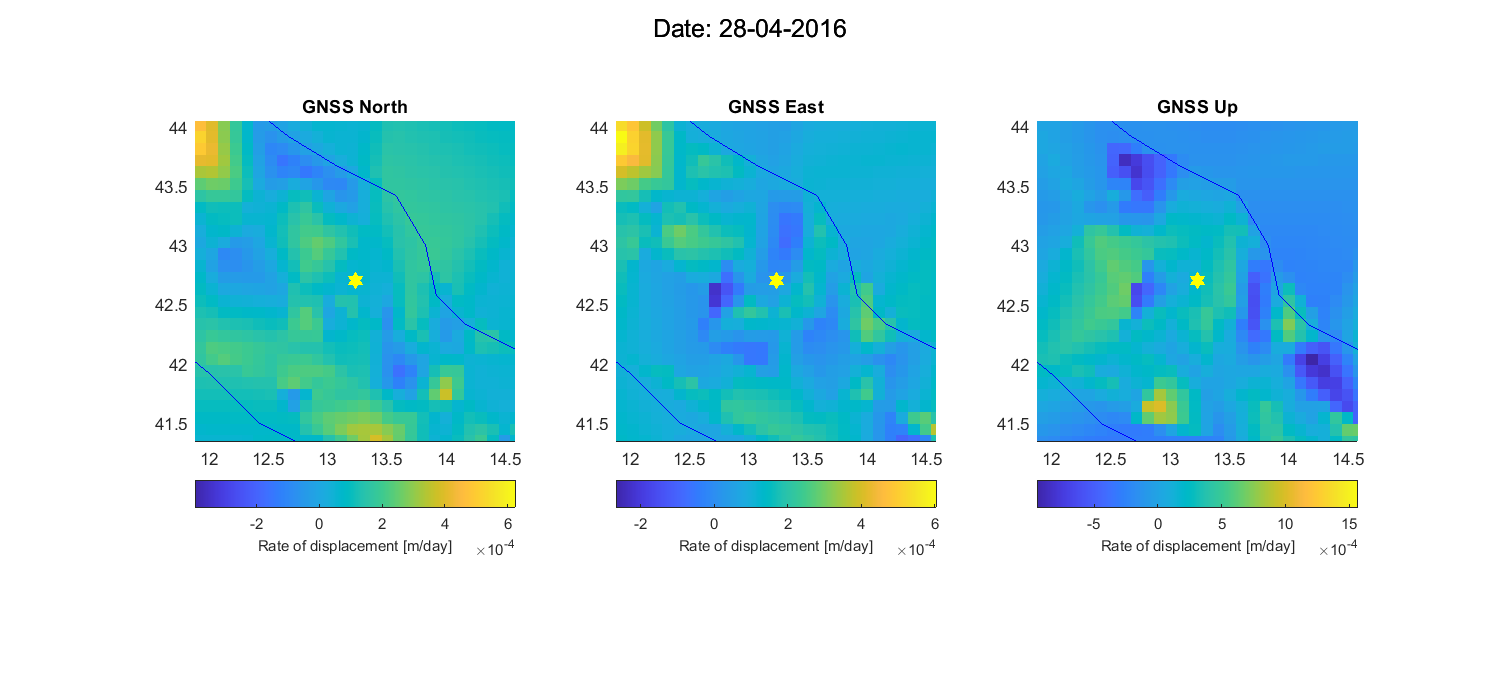

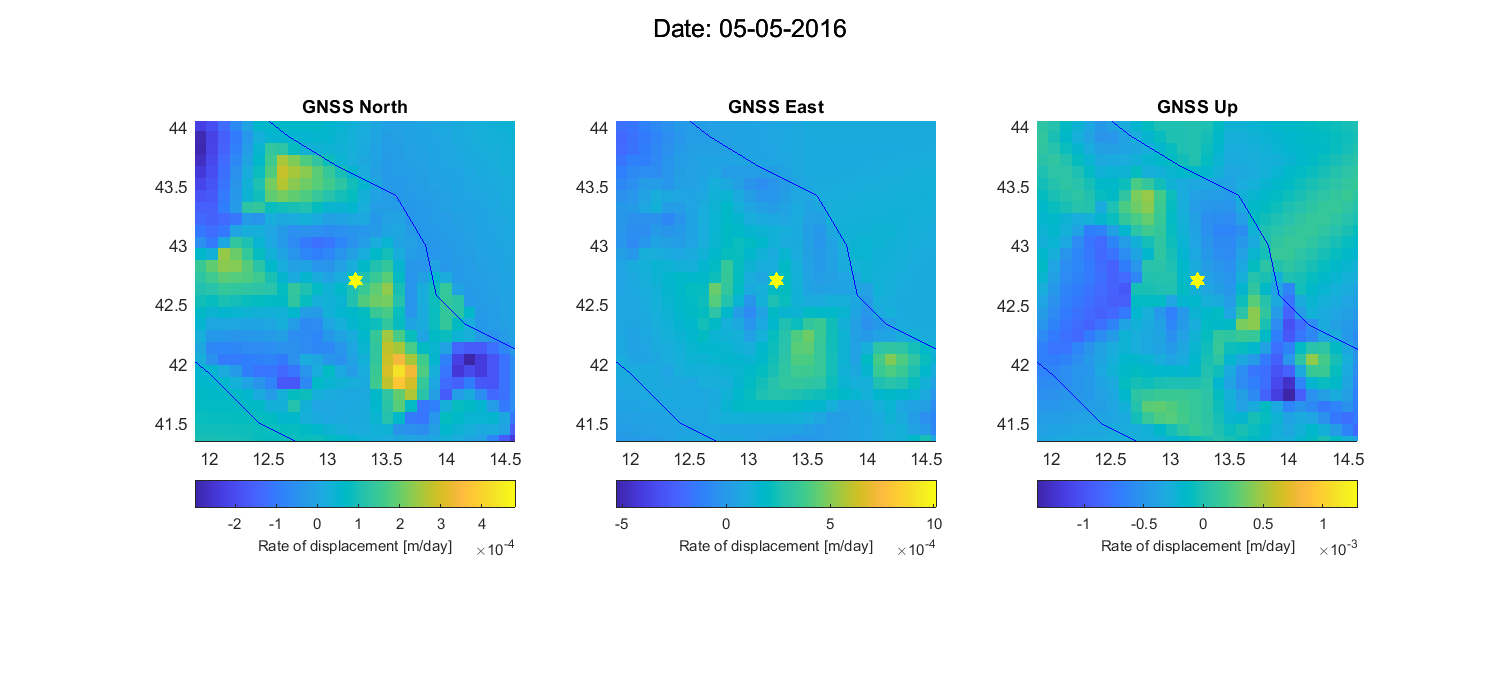

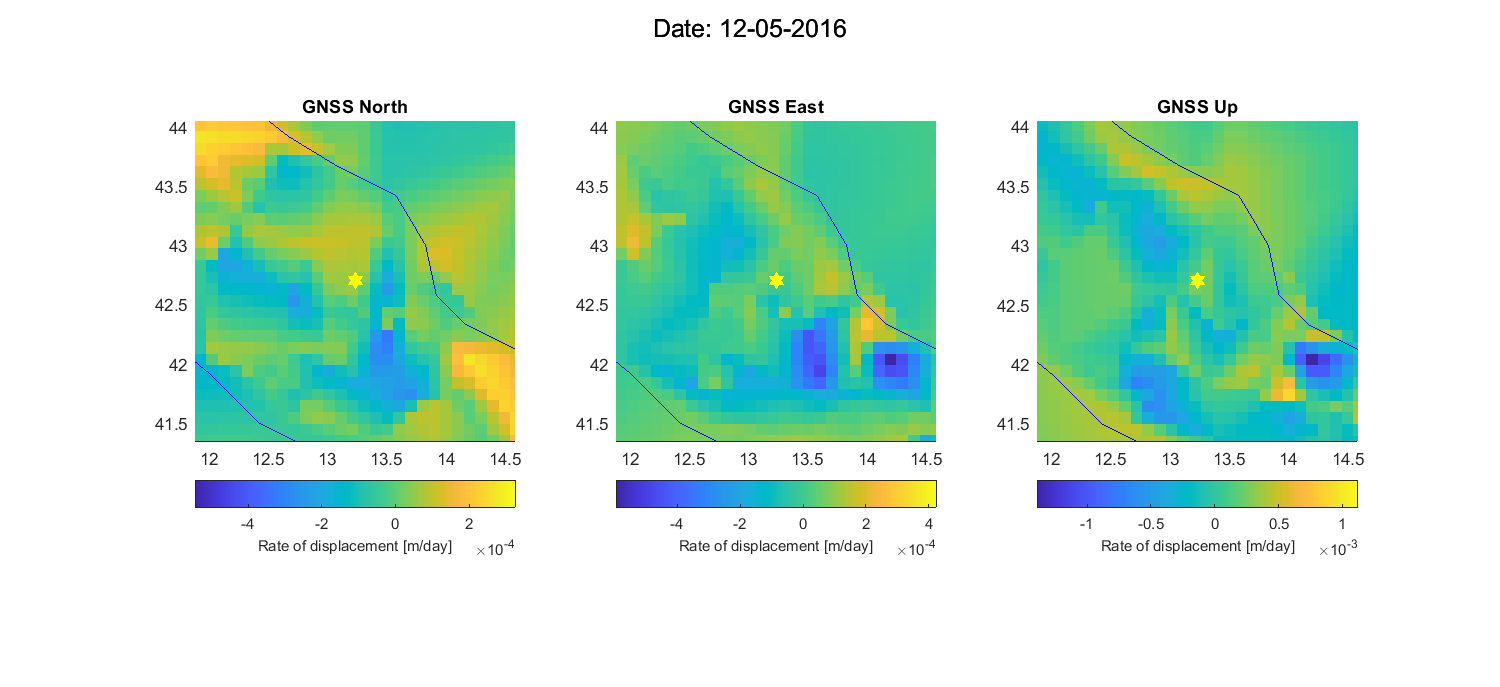

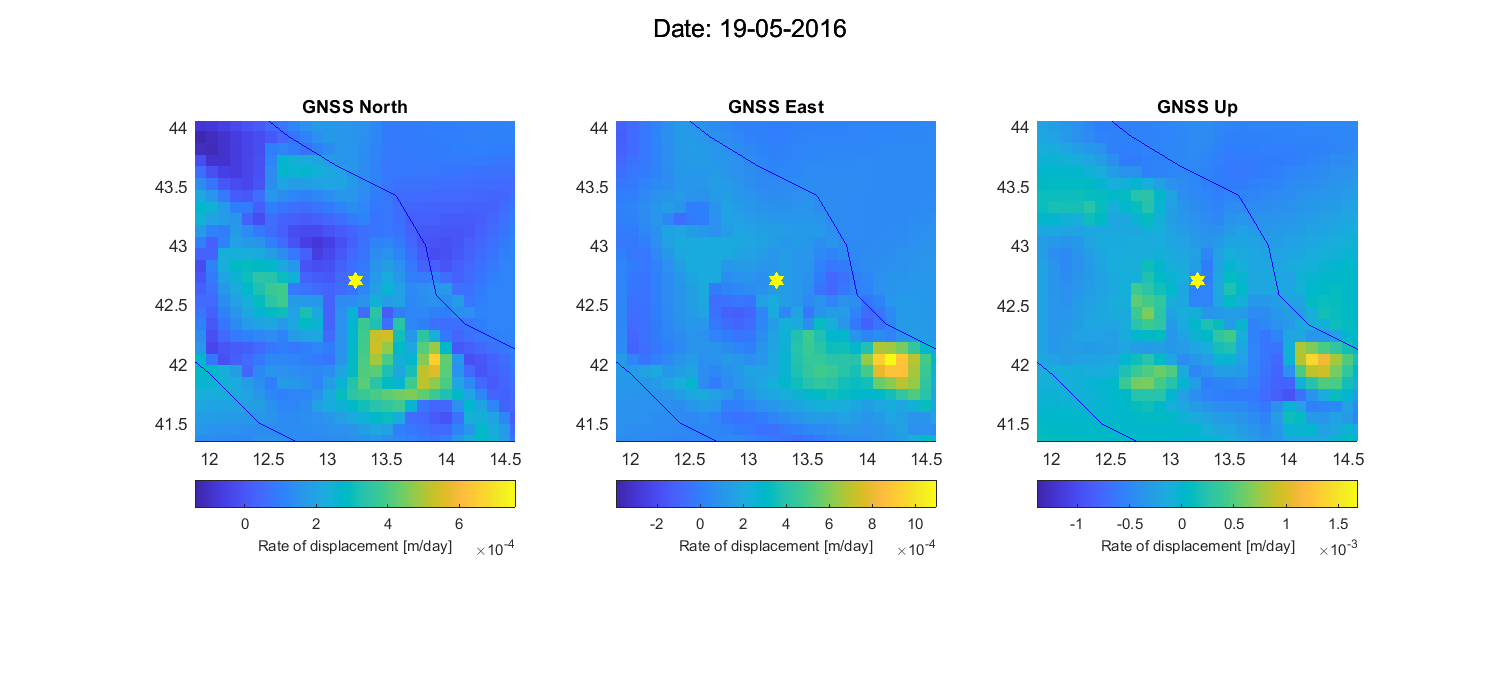

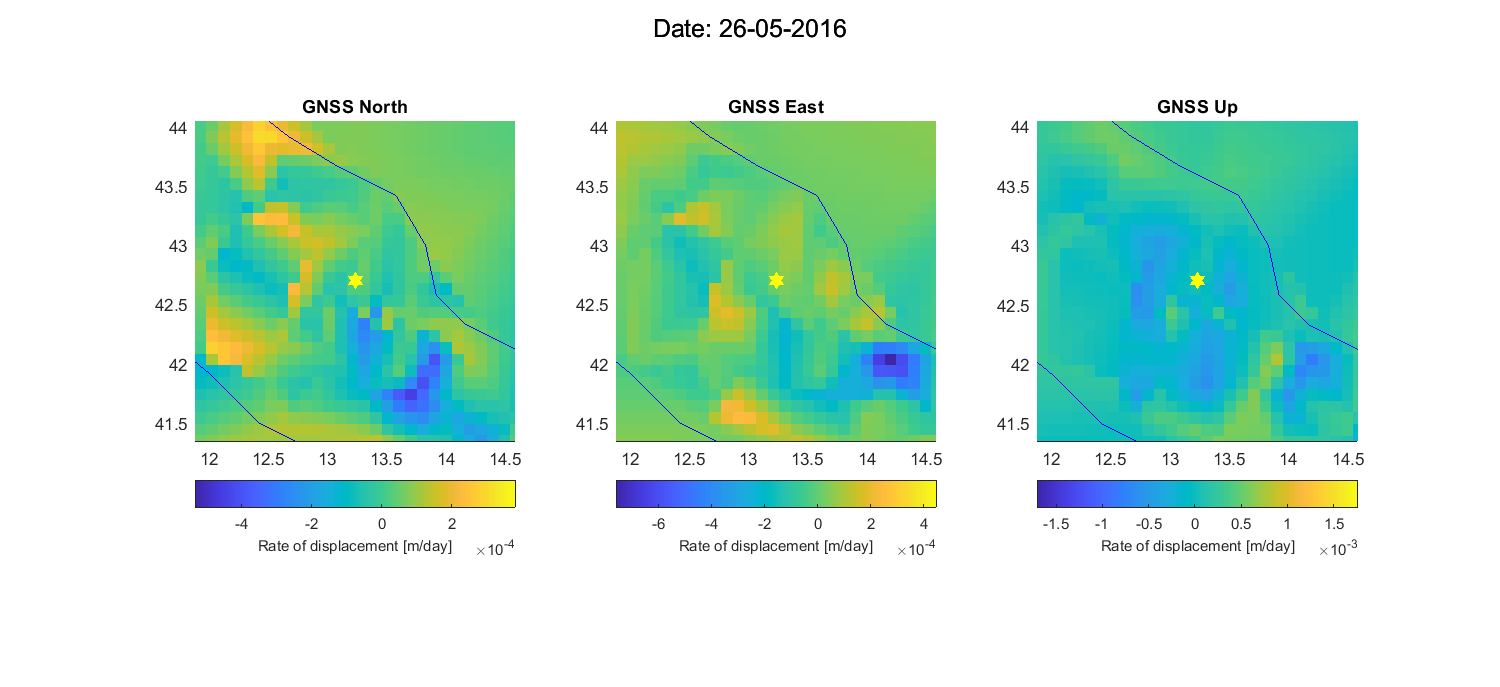

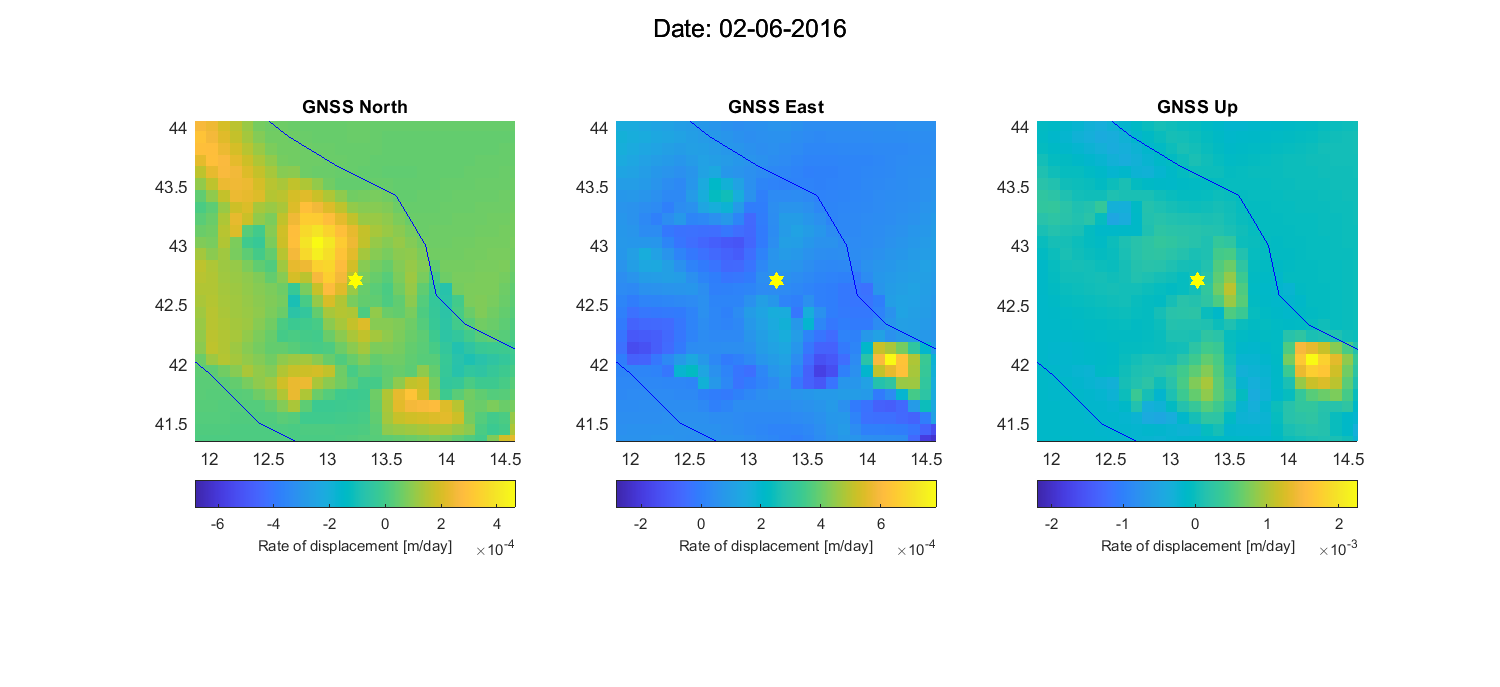

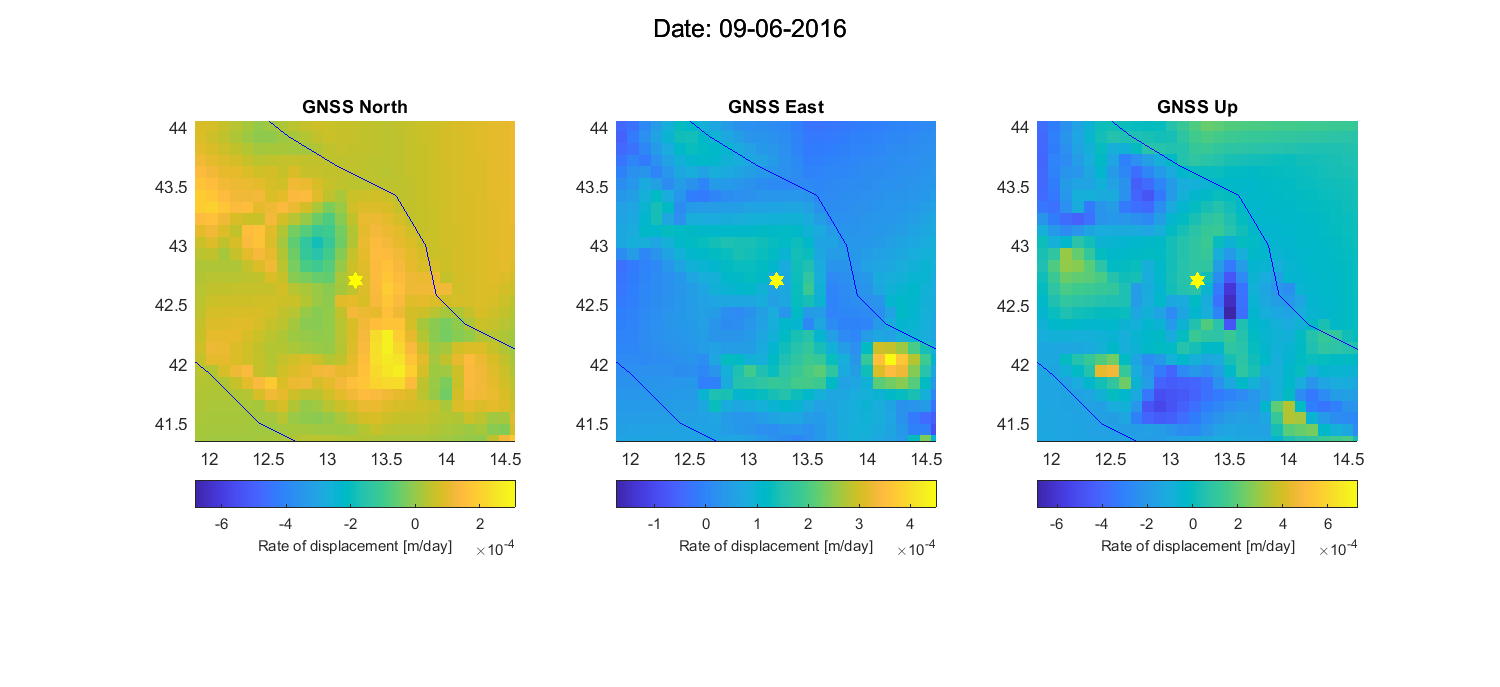

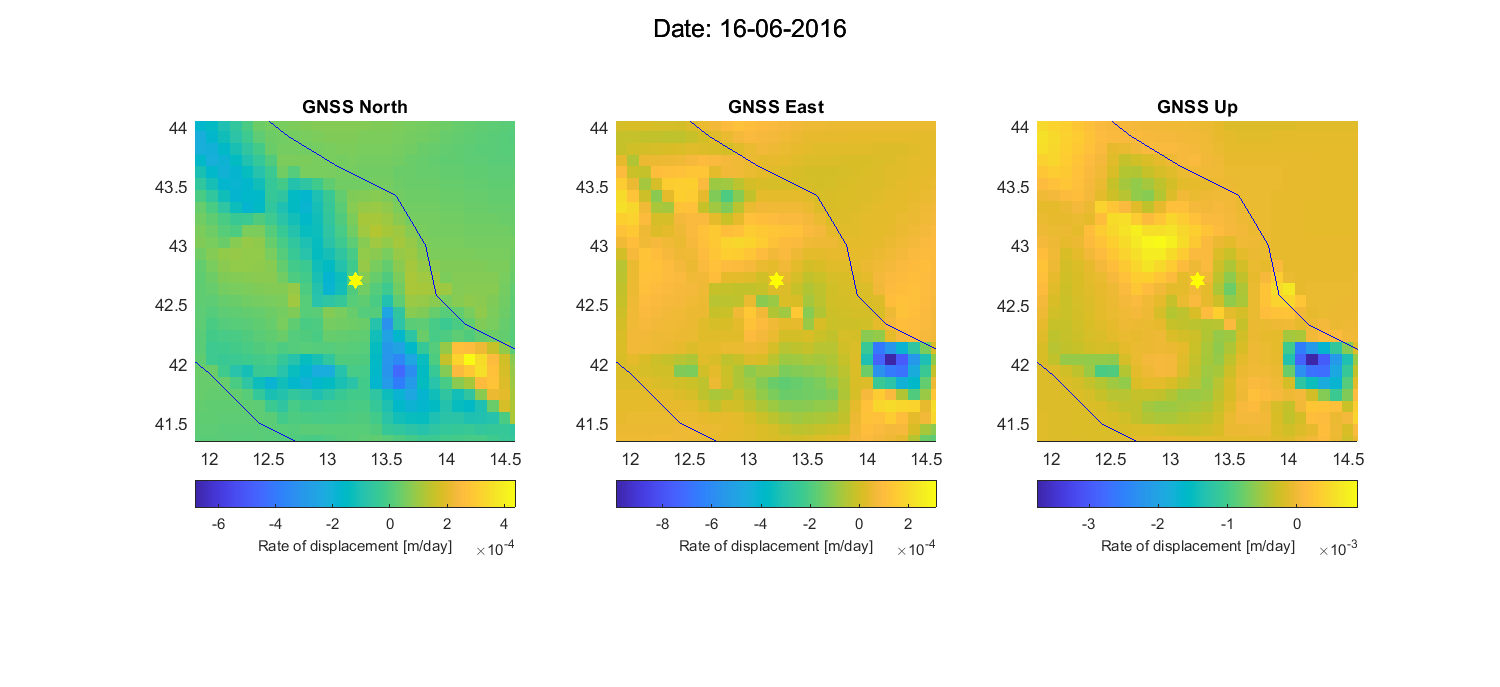

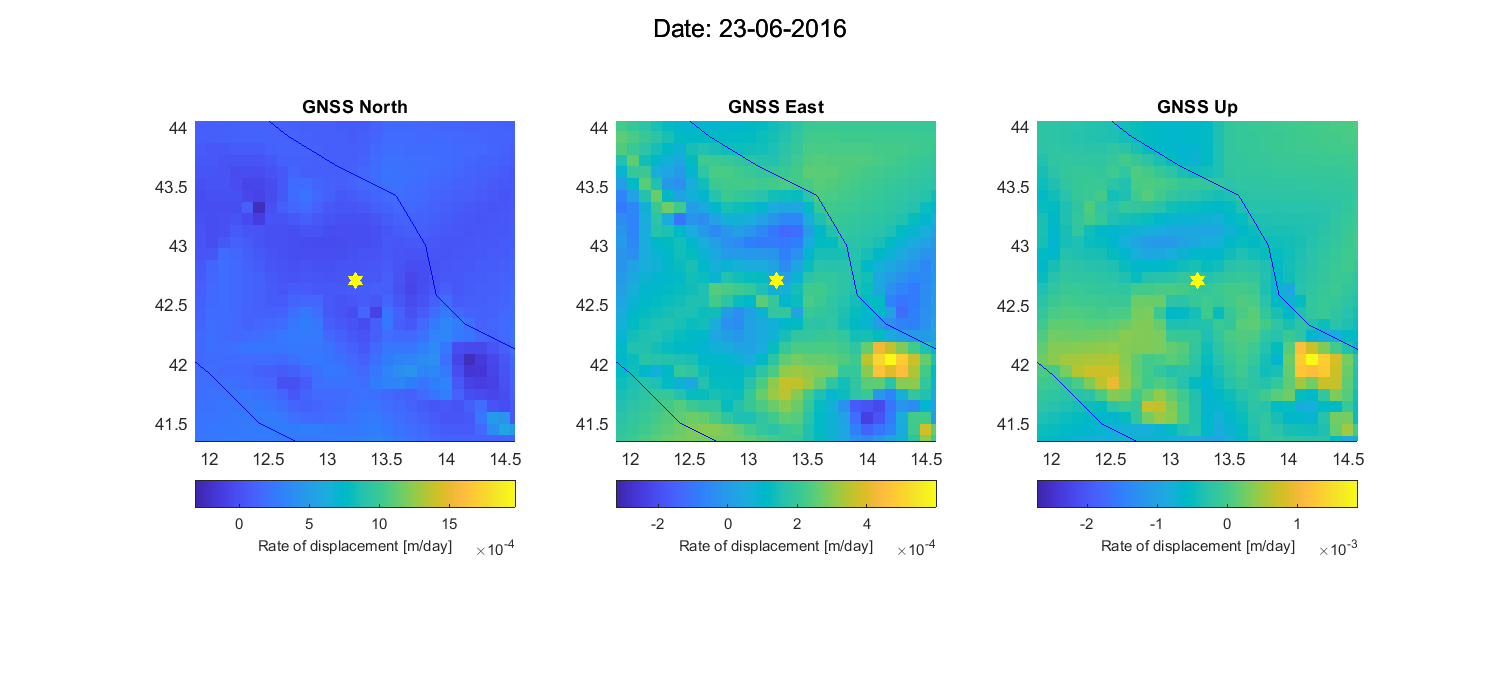

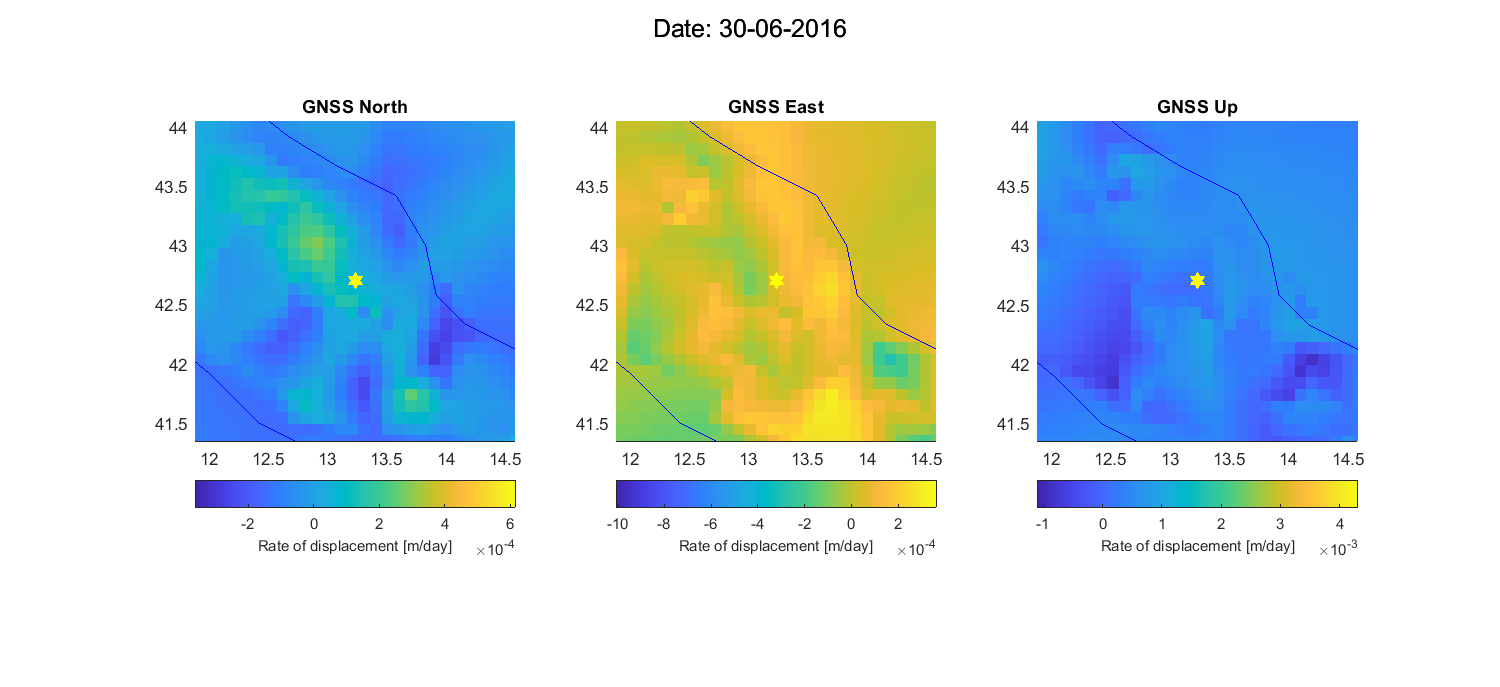

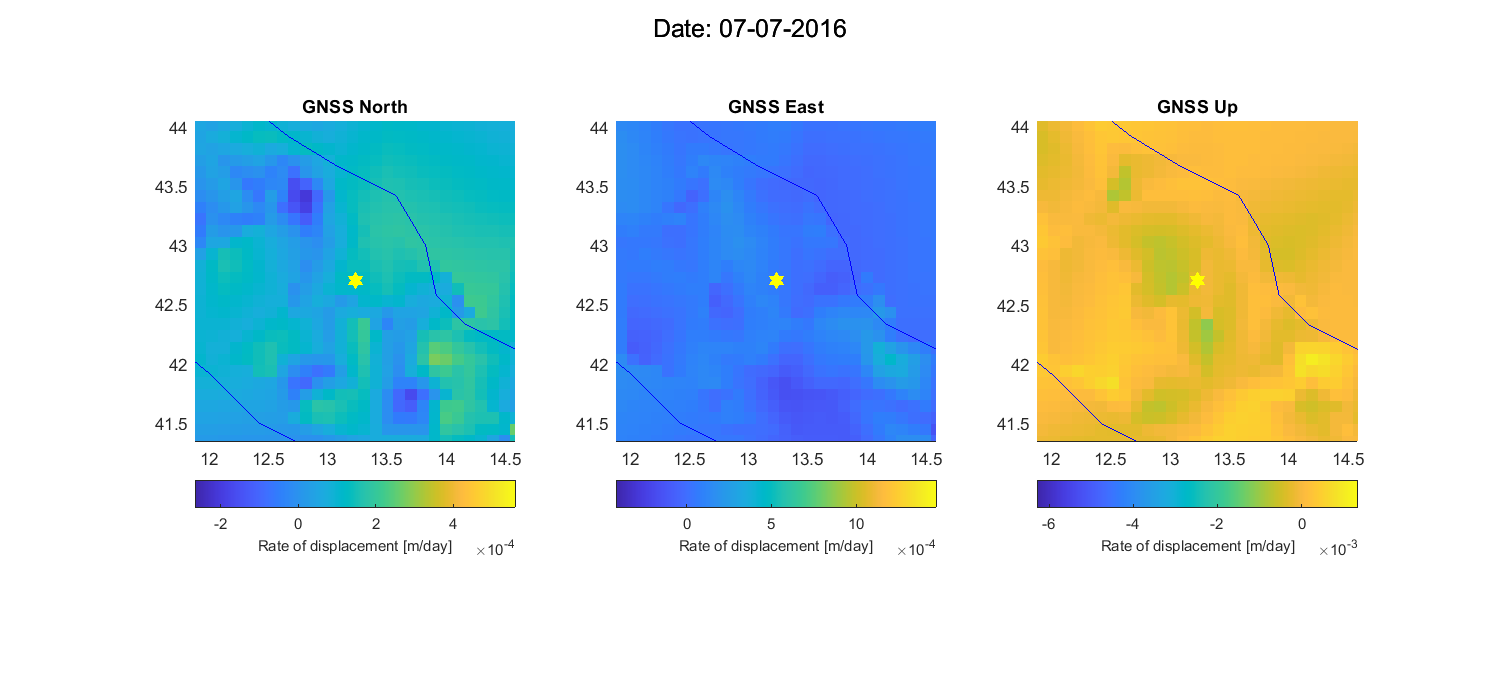

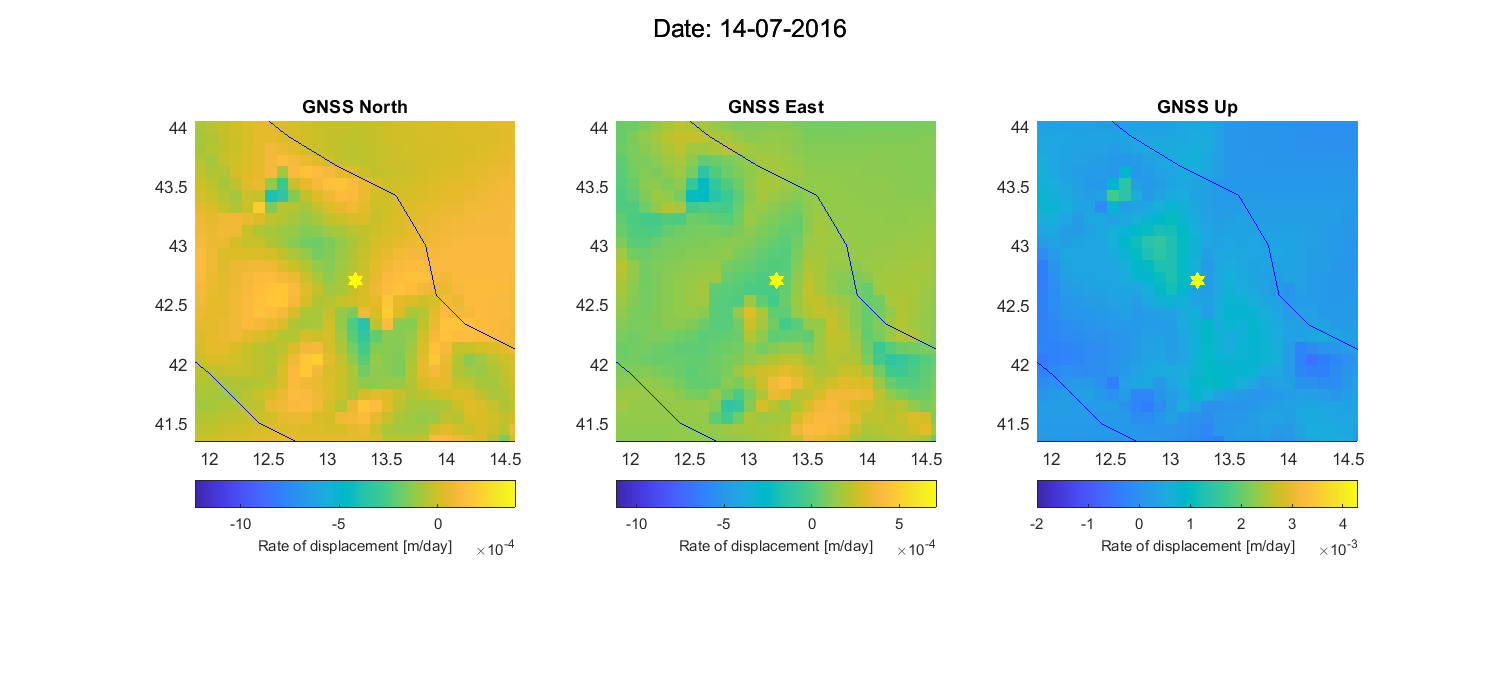

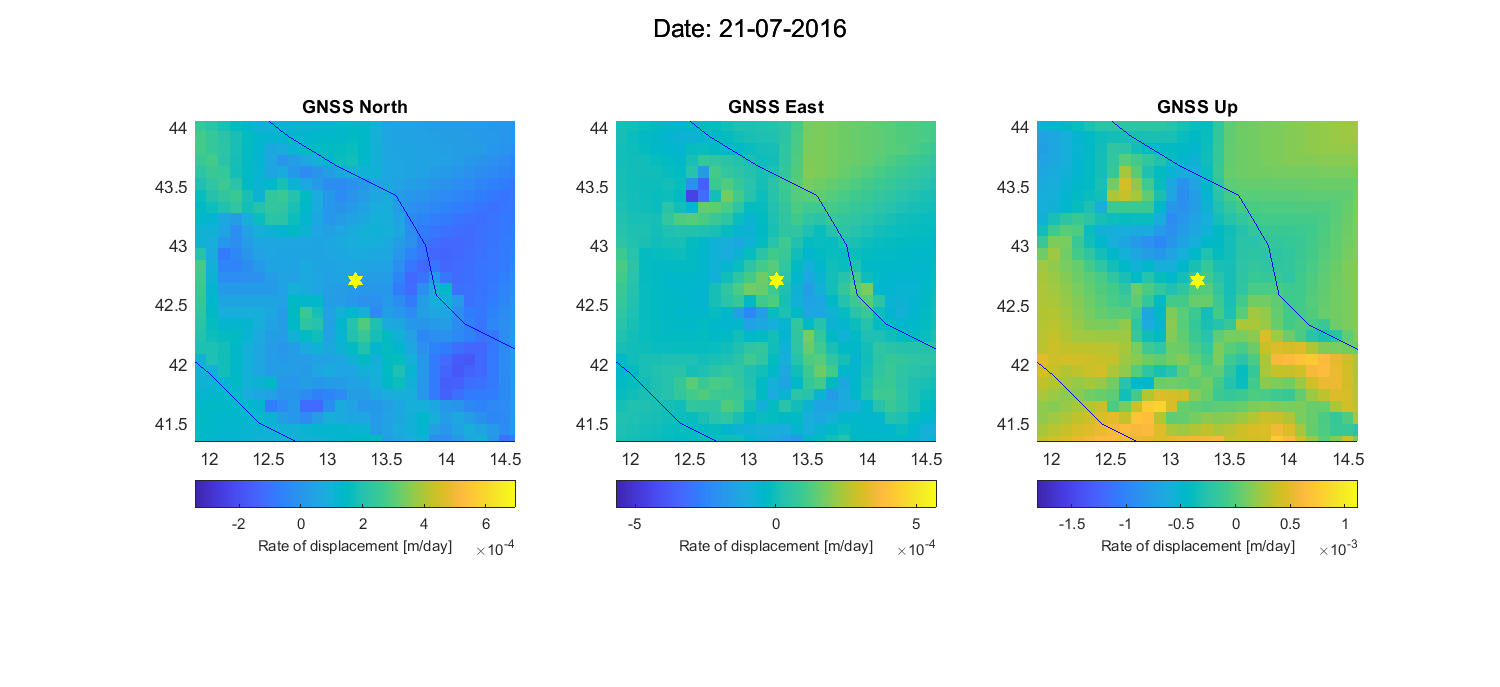

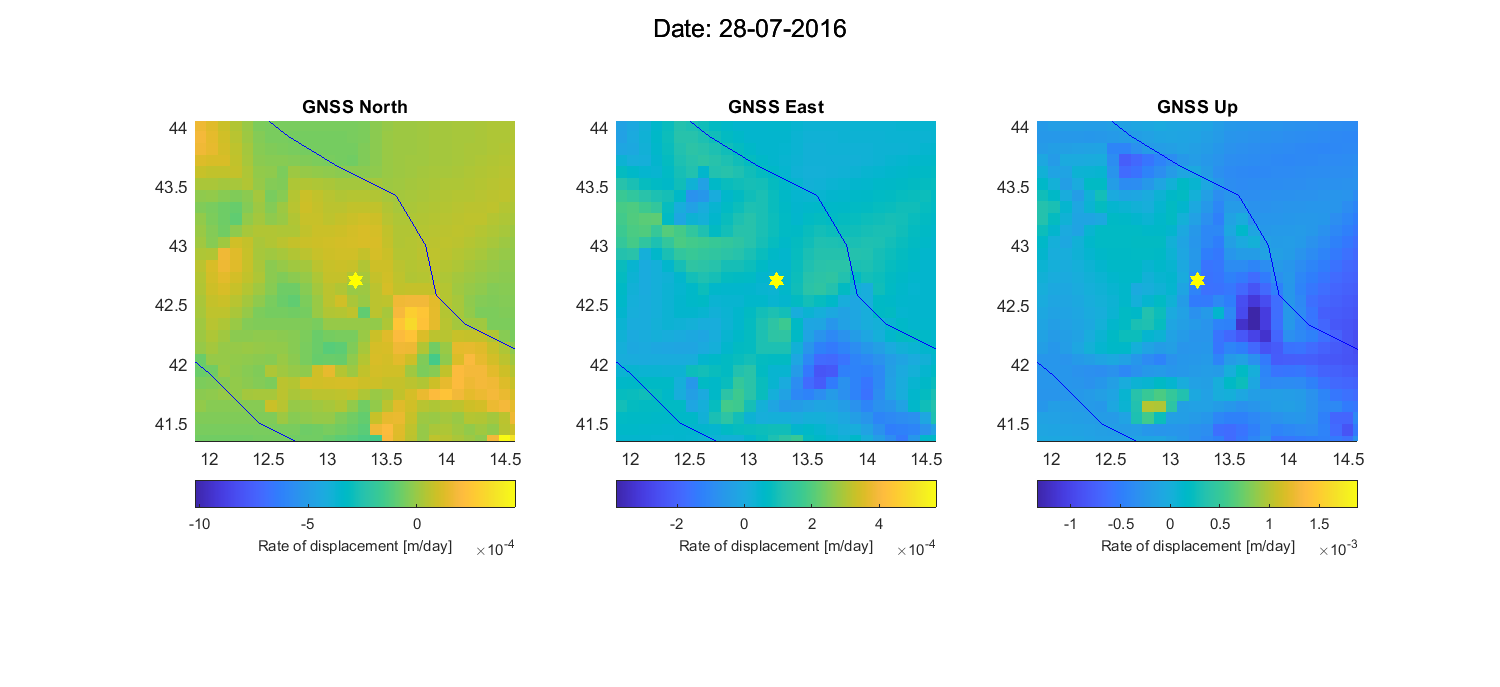

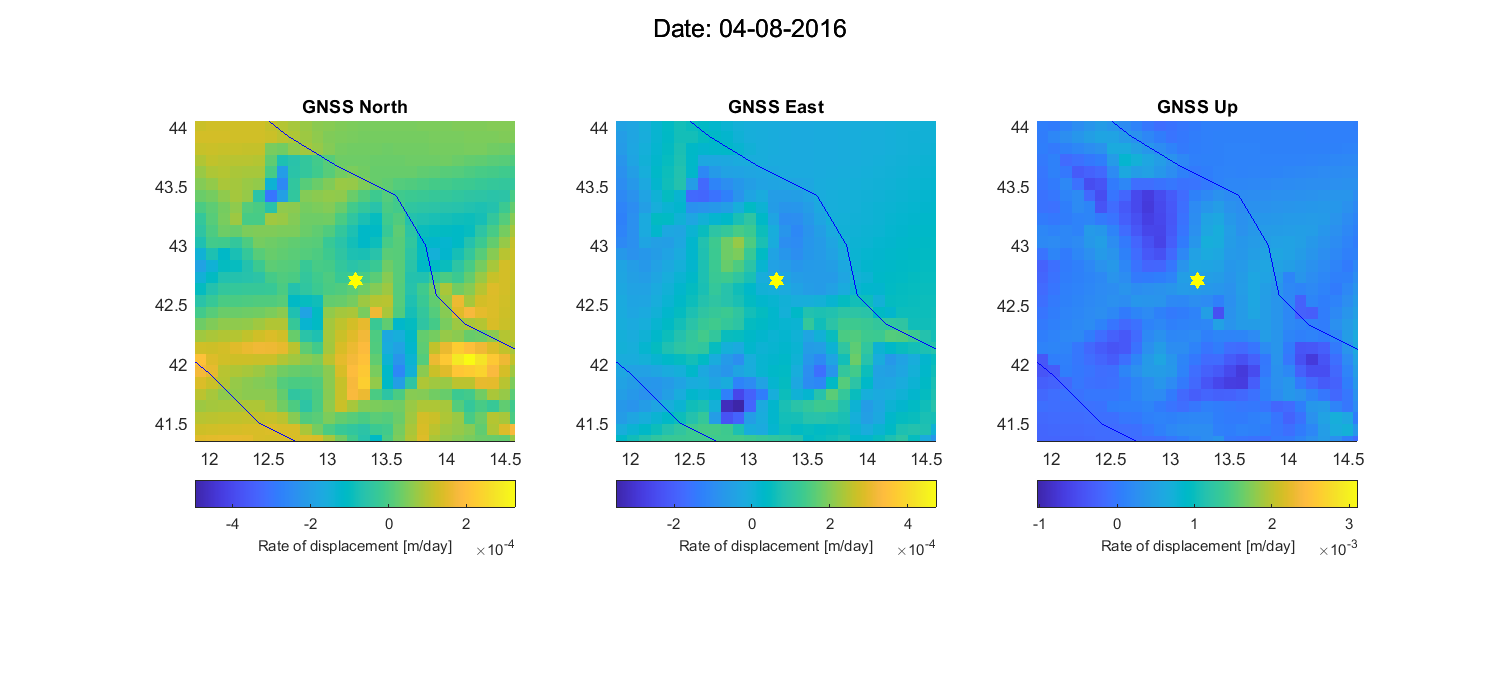

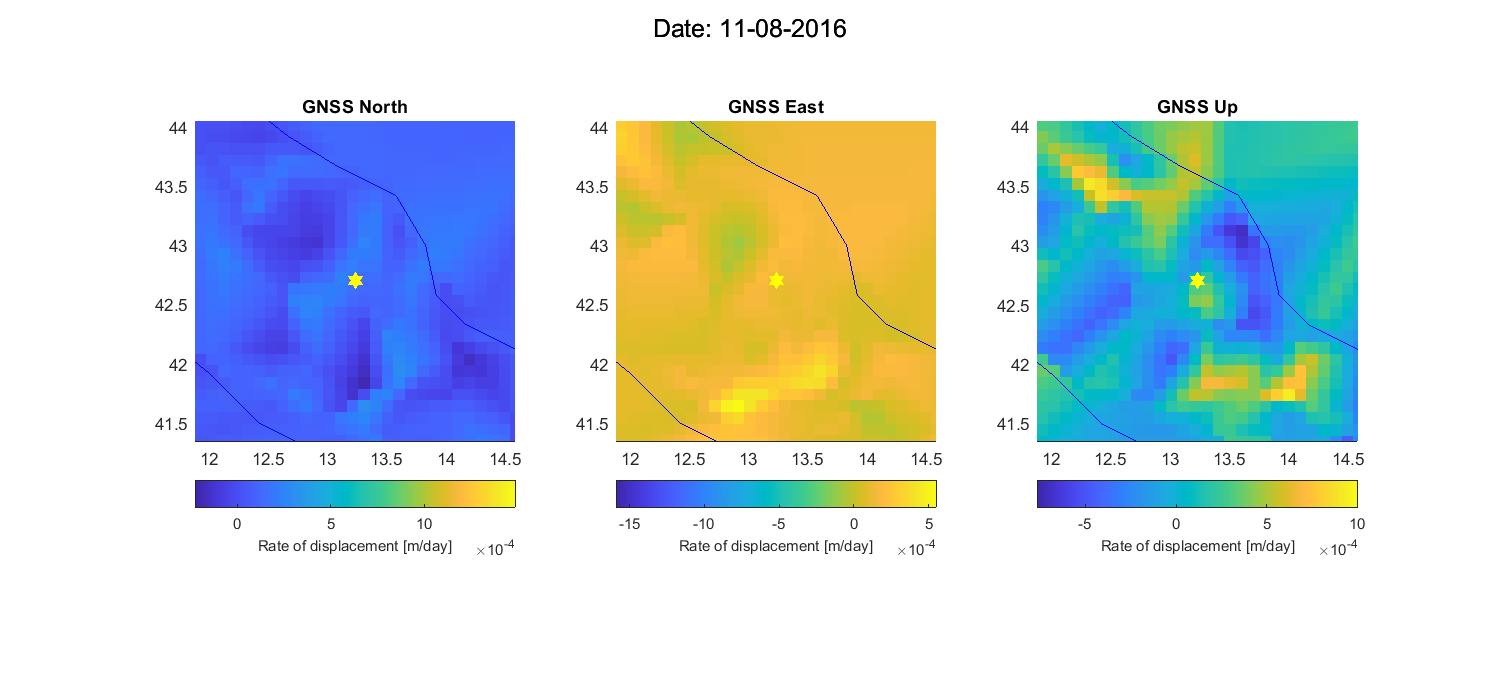

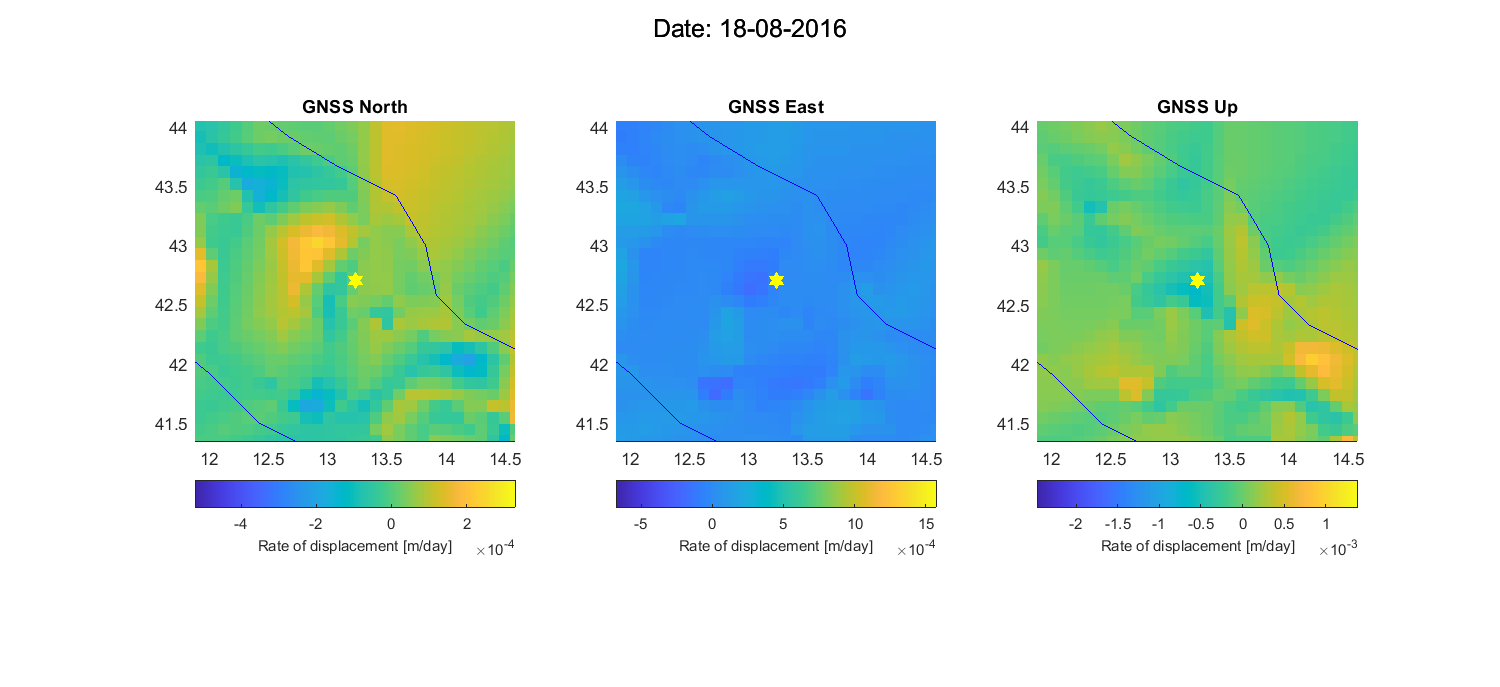

In [50]:
% Organization of the time of acquisition of the GNSS data inside the vector  GNSS_timestamp
GNSS_timestamp = nan(size(data_from_GNSS, 1)*30,1);
k = 1;
for i = 1:size(data_from_GNSS, 1)
    timestamp_1 = data_from_GNSS{i}.data(:,1);
    GNSS_timestamp(k:k+size(timestamp_1,1)-1) = timestamp_1;
    k = k + size(timestamp_1,1);
end
GNSS_timestamp = GNSS_timestamp(1:k-1);
%Extraction and order of the available time steps, considering only the unique ones.
GNSS_timestamp = unique(GNSS_timestamp);

% Preparation of the tensor that stores the data from all the stations at all times.
% Dimensions are: time, stations, components
GNSS_all_data = nan(size(GNSS_timestamp,1), size(data_from_GNSS, 1), 3);
for i = 1:size(data_from_GNSS,1)
    GNSS_station_1 = data_from_GNSS{i}.data;
    time_stamp_station = GNSS_station_1(:,1);
    for k = 1:size(GNSS_timestamp,1)
        data_to_be_assigned = GNSS_station_1(time_stamp_station == GNSS_timestamp(k),2:4);
        if size(data_to_be_assigned,1)>0
            GNSS_all_data(k,i,:) =data_to_be_assigned;
        end
    end
end

% filling missing values with interpolated values
% The first step is the selection of good stations.
station_good = nan(size(data_from_GNSS,1), 1);
station_coordinates = nan(size(data_from_GNSS,1), 2);
for i = 1:size(data_from_GNSS,1)
    if sum(isnan(GNSS_all_data(:,i,1)) | GNSS_all_data(:,i,1) == 0) >= size(GNSS_all_data,1) - 1
        station_good(i,1) = 0;
    else
        station_good(i,1) = 1;
    end
    station_coordinates(i,1:2) = data_from_GNSS{i}.coordinates;
end
GNSS_all_data = GNSS_all_data(:, station_good == 1, :);
station_coordinates = station_coordinates(station_good == 1, :);

% Linear interpolation of the values among the time axis
for i = 1:size(GNSS_all_data,2)
    for j = 1:3
        data_to_be_analysed = GNSS_all_data(:,i,j);
        time_of_data_to_be_analysed = GNSS_timestamp(isfinite(data_to_be_analysed));
        data_to_be_analysed = data_to_be_analysed(isfinite(data_to_be_analysed));
        data_interpolated = interp1(time_of_data_to_be_analysed, data_to_be_analysed, GNSS_timestamp, 'linear');
        GNSS_all_data(:,i,j) = data_interpolated;
    end
end

% Geographical edges of the stations with good data 
min_lat_GNSS = min(station_coordinates(:,2));
max_lat_GNSS = max(station_coordinates(:,2));
min_lon_GNSS = min(station_coordinates(:,1));
max_lon_GNSS = max(station_coordinates(:,1));

resolution_GNSS = 0.1; %Resolution of maps from GNSS data, achieved by spatial interpolation

% Preparation of elements for spatial interpolation
lon_vector = min_lon_GNSS:resolution_GNSS:max_lon_GNSS;
lat_vector = min_lat_GNSS:resolution_GNSS:max_lat_GNSS;
[grid_LAT, grid_LON] = meshgrid(lat_vector, lon_vector);

%Load of coastline data
load coastlines;

% Calculus of differences of GNSS values for the displacement rate
GNSS_all_data_diff = diff(GNSS_all_data, 1, 1);
%Calculus of differences of time
GNSS_timestamp_diff = GNSS_timestamp(1:end-1)/2 + GNSS_timestamp(2:end)/2;
for i = 1:size(GNSS_all_data_diff,1)
    % Calculus of the displacement rate as the first order derivative. 
    GNSS_all_data_diff(i,:,:) = GNSS_all_data_diff(i,:,:) ./ (GNSS_timestamp(i+1)-GNSS_timestamp(i));
    % Preparation of data for spatial interpolation
    data_for_map = reshape(GNSS_all_data_diff(i,:,:), size(GNSS_all_data_diff, 2), size(GNSS_all_data_diff, 3));
    station_coordinates_p = station_coordinates(isfinite(data_for_map(:,1)), :);
    data_for_map = data_for_map(isfinite(data_for_map(:,1)), :);
    % Interpolation of scattered data into a regular grid defined by resolution_GNSS
    F_N = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,1));
    F_E = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,2));
    F_U = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,3));
    interpolated_data_N = F_N(grid_LAT, grid_LON);
    interpolated_data_E = F_E(grid_LAT, grid_LON);
    interpolated_data_U = F_U(grid_LAT, grid_LON);
    %Preparation of the figure map for the specific time interval for each GNSS component
    figure('Position', [1 1 1200 550])
    subplot(1,3,1)
    % Plot of the map of GNSS North rate of displacement
    geoshow(grid_LAT, grid_LON, interpolated_data_N, 'DisplayType', 'texturemap');
    hold on
    plot(coastlon, coastlat, '-b'); % Overplot of coastlines
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y'); % Overplot of epicentre position by a yellow star
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); % Set of map limits
    title('GNSS North');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    subplot(1,3,2)
    % Plot of the map of GNSS East rate of displacement
    geoshow(grid_LAT, grid_LON, interpolated_data_E, 'DisplayType', 'texturemap');
    hold on;
    plot(coastlon, coastlat, '-b'); % Overplot of coastlines
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y'); % Overplot of epicentre position by a yellow star
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); % Set of map limits
    title('GNSS East');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    subplot(1,3,3)
    % Plot of the map of GNSS Up rate of displacement
    geoshow(grid_LAT, grid_LON, interpolated_data_U, 'DisplayType', 'texturemap');
    hold on
    plot(coastlon, coastlat, '-b'); % Overplot of coastlines
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y'); % Overplot of epicentre position by a yellow star
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); % Set of map limits
    title('GNSS Up');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    sgtitle(['Date: ', datestr(GNSS_timestamp_diff(i), 'dd-mm-yyyy')]);
    % Save the figure map in the Output folder
    saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_GNSS_map', datestr(GNSS_timestamp_diff(i), 'dd-mm-yyyy'), '.png']), "png");
    saveas(gcf, fullfile(Output_folder, ['Lithosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_GNSS_map', datestr(GNSS_timestamp_diff(i), 'dd-mm-yyyy'),'.fig']), "fig");
end


## Atmospheric analysis

The atmospheric analysis uses a method called MEANS (*Marchetti et al., 2020*), which is a variation of the CAPRI (*Piscini et al., 2017*) algorithm. MEANS stays for *"MErra-2 ANalysis to search Seismic precursors"* and CAPRI for *"Climatological Analysis for seismic PRecursor Identification"*. A full description of the methods can be found in:  
1. Piscini, A.; De Santis, A.; Marchetti, D.; Cianchini, G. A Multi-Parametric Climatological Approach to Study the 2016 Amatrice–Norcia (Central Italy) Earthquake Preparatory Phase. Pure Appl. Geophys. 2017, 174, 3673–3688. <a href="https://doi.org/10.1007/s00024-017-1597-8">doi:10.1007/s00024-017-1597-8</a>.
2. Marchetti, D.; De Santis, A.; Shen, X.; Campuzano, S.A.; Perrone, L.; Piscini, A.; Di Giovambattista, R.; Jin, S.; Ippolito, A.; Cianchini, G.; et al. Possible Lithosphere-Atmosphere-Ionosphere Coupling Effects Prior to the 2018 Mw = 7.5 Indonesia Earthquake from Seismic, Atmospheric and Ionospheric Data. J. Asian Earth Sci. 2020, 188, 104097. <a href="https://doi.org/10.1016/j.jseaes.2019.104097">doi:10.1016/j.jseaes.2019.104097</a>.


The atmospheric analysis uses the MERRA2 climatological archive data from NASA (doi: <a href="https://doi.org/10.5067/KLICLTZ8EM9D"> 10.5067/KLICLTZ8EM9D</a>).  
This version of the VRE uses data that were downloaded and pre-processed. If you want to automatic download other data or change the global parameters, please, use the specific notebook `Download_data_for_SEISMO-VRE_Matlab_v1.0.ipynb` inside the `data` subfolder.  

The pre-processed data are inside the file `Atmospheric_data_for_Norcia.mat`. However, if you retrieve your own data you need to comment the load line of this file and uncomment the line of loading `Atmospheric_data_from_MERRA2.mat`.  

The following cell processes the data using the MEANS algorithm.  



number_of_analysed_days =    241

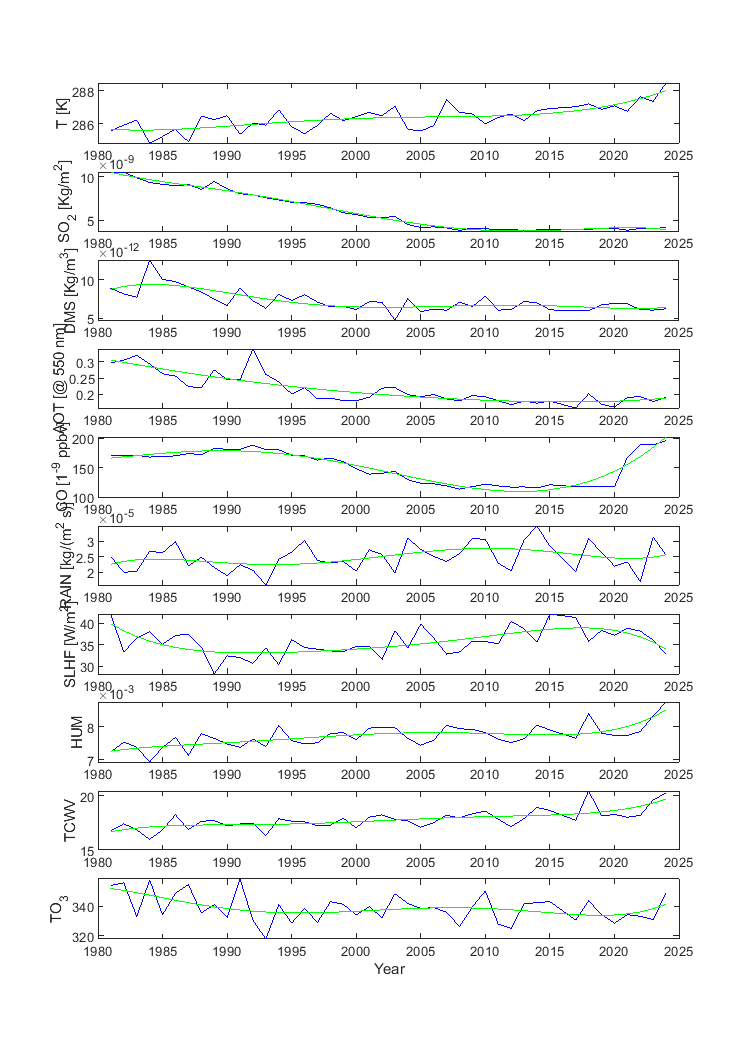

In [51]:
% Processing of atmospheric data

% Define the folder for the output products of the VRE
Output_folder = "Outputs";

% load the data. The file Atmospheric_data_for_Norcia.mat is the example data for Amatrice-Norcia 2016 EQ;
% otherwise, the file Atmospheric_data_from_MERRA2.mat is the data downloaded before.
 load("data/Atmospheric_data_for_Norcia.mat");
% load('data/Atmospheric_data_from_MERRA2.mat');
% Set the parameter of global warming. This is the degree of the polynomial that is subtracted from multi-years trend of atmospheric data.
% global_warming_correction = 0 means no correction for global warming. global_warming_correction = 1 means linear trend is removed.
global_warming_correction = 5;
% Calculus of time and space constraints for the atmospheric analysis 
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
number_of_analysed_days = time_end - time_start + 1
[year_end1, month_end1, day_end1] = datevec(time_end);
% Set the last year for the atmospheric analysis which is basically the previous year, except the earthquake occurred in the present year.
[year_end, ~] = datevec(now); % For example, 2025;
if EQ_year < year_end
    year_end = year_end -1; %Stop the analysis the year before the present one.
end

% Set the starting year of the atmospheric analysis, considering that the dataset started in 1980.
% If the period would exceed the 1st January 1980, the starting year is shifted to 1981.
if (datenum([1980 month_end1 day_end1]) - number_of_analysed_days) < datenum([1980 1 1])
    year_start = 1981;
else
    year_start = 1980;
end
% Calculate the total number of analysed years
number_of_years_to_be_analysed = year_end-year_start;
% Setup the variables necessary for the preliminary historical average of each atmospheric parameter
mean_SO2 = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_DMS = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_AOT = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_CO = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_SAT = nan(number_of_analysed_days, number_of_years_to_be_analysed);
mean_HUM = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_SLHF = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_RAIN = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_TCWV = nan(number_of_analysed_days,number_of_years_to_be_analysed);
mean_TO3 = nan(number_of_analysed_days,number_of_years_to_be_analysed);
% setup the variables with the values recorded in the year of the earthquake occurrence.
mean_SO2_EQ_year = zeros(number_of_analysed_days, 1);
mean_DMS_EQ_year  = zeros(number_of_analysed_days, 1);
mean_AOT_EQ_year  = zeros(number_of_analysed_days, 1);
mean_CO_EQ_year  = zeros(number_of_analysed_days, 1);
mean_SAT_EQ_year  = zeros(number_of_analysed_days, 1);
mean_HUM_EQ_year  = zeros(number_of_analysed_days, 1);
mean_SLHF_EQ_year  = zeros(number_of_analysed_days, 1);
mean_RAIN_EQ_year  = zeros(number_of_analysed_days, 1);
mean_TCWV_EQ_year  = zeros(number_of_analysed_days, 1);
mean_TO3_EQ_year  = zeros(number_of_analysed_days, 1);

% transferring the atmospheric variables from the stored files to the ones used in the following calculus 
SO2_EQ = SO2;
DMS_EQ = DMS;
AOT_EQ = AOT;
CO_EQ = CO;
SAT_EQ = SAT;
HUM_EQ = HUM;
SLHF_EQ = SLHF;
RAIN_EQ = RAIN;
TCWV_EQ = TCWV;
TO3_EQ = TO3;
% Despite each atmospheric parameter having its time, only one is preserved as all the parameters are retrieved for the same time interval
time_atmospheric_data = SO2_time;

% variable that counts the year in the historical mean. It excludes the year of the earthquake
index_year_historic = 1;
% Cicle on all the years of the time series
for year_i=number_of_years_to_be_analysed:-1:0 
    % Calculate the year under investigation (year_to_be_analysed)
    year_to_be_analysed = year_end-year_i;
    end_date = datenum([year_to_be_analysed EQ_month EQ_day]);
    start_date = end_date - number_of_analysed_days+1;
    % The following lines of code are necessary to afford the bysestile
    % year. In fact, the number of analysed year must be the same and in
    % case an year include the 29 February this day must be excluded from
    % the time series. In the same time the automatic calculus of the
    % start_date must be checked to anticipate of one day if the year under
    % the analysis contains the 29 February
    if EQ_month == 1 || (EQ_month == 2 && EQ_day < 29)
        %the year to be checked is the one interested in the time series, for example, 8 months before the Mw=6.0 24 August 2016 (Central Italy earthquake) is the same year
        year_to_be_checked_for_leap = year_to_be_analysed - 1;
    else
        year_to_be_checked_for_leap = year_to_be_analysed;
    end
    Leap_day = datenum([year_to_be_checked_for_leap 2 29]);
    [~, ~, day_check] = datevec(Leap_day);
    if day_check == 29 && start_date <= Leap_day && end_date >= Leap_day
        % In case the time window of the analysis contain the 29 February the analysis start one day before becuase 29 February is then excluded.
        start_date = start_date - 1;
    end
    
    index_day_tba = 1;
    
    for i=start_date:end_date
        [~, mese_p, giorno_p] = datevec(i);
        %Search for the index of the original data corresponding to the one to be analysed
        index_data = find(time_atmospheric_data == i);
        % Exclude the 29 February from the analysis (if present)
        if not(mese_p == 2 && giorno_p == 29)

            % At this section the extract data for each parameter are stored in a vector for the earthquake year 
            % (for example: mean_SO2_EQ_year)that has only one dimension of the day or stored in a two-dimension vector 
            % (for example: mean_SO2) with row-index for day and column-index for year. 
            % This second array is the one necessary for calculating the historical mean
            if year_to_be_analysed == EQ_year
                mean_SO2_EQ_year(index_day_tba,1) = SO2_EQ(index_data);
                mean_DMS_EQ_year(index_day_tba,1) = DMS_EQ(index_data);
                mean_AOT_EQ_year(index_day_tba,1) = AOT_EQ(index_data);
                mean_CO_EQ_year(index_day_tba,1) = CO_EQ(index_data);
                mean_SAT_EQ_year(index_day_tba,1) = SAT_EQ(index_data);
                mean_RAIN_EQ_year(index_day_tba,1) = RAIN_EQ(index_data);
                mean_SLHF_EQ_year(index_day_tba,1) = SLHF_EQ(index_data);
                mean_HUM_EQ_year(index_day_tba,1) = HUM_EQ(index_data);
                mean_TCWV_EQ_year(index_day_tba,1) = TCWV_EQ(index_data);
                mean_TO3_EQ_year(index_day_tba,1) = TO3_EQ(index_data);
            else
                mean_SO2(index_day_tba,index_year_historic) = SO2_EQ(index_data);
                mean_DMS(index_day_tba,index_year_historic) = DMS_EQ(index_data);
                mean_AOT(index_day_tba,index_year_historic) = AOT_EQ(index_data);
                mean_CO(index_day_tba,index_year_historic) = CO_EQ(index_data);
                mean_SAT(index_day_tba,index_year_historic) = SAT_EQ(index_data);
                mean_RAIN(index_day_tba,index_year_historic) = RAIN_EQ(index_data);
                mean_SLHF(index_day_tba,index_year_historic) = SLHF_EQ(index_data);
                mean_HUM(index_day_tba,index_year_historic) = HUM_EQ(index_data);
                mean_TCWV(index_day_tba,index_year_historic) = TCWV_EQ(index_data);
                mean_TO3(index_day_tba,index_year_historic) = TO3_EQ(index_data);
            end
            % Increase the day index
            index_day_tba = index_day_tba + 1;
        end
    end
    if year_to_be_analysed ~= EQ_year
        % Increase the year index except for the year of the earhtquake to avoid gap in the two dimension array.
        index_year_historic = index_year_historic + 1;
    end
end
if global_warming_correction == 0
% In case global_warming_correction is set to zero only the temperature parameter is corrected with a linear trend
    %The mean temperature for each year is computed as mean on one of the two dimensions of the mean_SAT array
    yearly_SAT = (mean(mean_SAT,1))';
    yearly_SAT = yarly_SAT(1:end-1);
    % Calculate the year vector  
    year_considered = (year_start:year_end)';
    % Remove the year of the earhtquake from teh year vector
    year_considered = year_considered(year_considered ~= EQ_year);
    % Calculate the year linear fit over the whole analysied years excluding the one of the earhtquake
    fit_global_warming_SAT = polyfit(year_considered,yearly_SAT,1);
    % Correct the original data removing the trend obtained by the previous fit
    year_k = 1;
    for year_tbcorrected = year_start:year_end
        if year_tbcorrected ~= EQ_year
            mean_SAT(:,year_k) = mean_SAT(:,year_k) - fit_global_warming_SAT(1)*(year_tbcorrected - year_start);
        else
            mean_SAT_EQ_year = mean_SAT_EQ_year - fit_global_warming_SAT(1)*(year_tbcorrected - year_start);
        end
        year_k = year_k + 1;
    end
elseif global_warming_correction > 0
    % In case global_warming_correction > 0 all parameters are corrected for global warming by a polynomial of degree defined by "global_warming_correction"

    % Calculate the yearly mean for all parameters 
    yarly_SAT = (mean(mean_SAT,1))';
    yarly_SO2 = (mean(mean_SO2,1))';
    yarly_DMS = (mean(mean_DMS,1))';
    yarly_AOT = (mean(mean_AOT,1))';
    yarly_CO = (mean(mean_CO,1))';
    yarly_RAIN = (mean(mean_RAIN,1))';
    yarly_SLHF = (mean(mean_SLHF,1))';
    yarly_HUM = (mean(mean_HUM,1))';
    yearly_TCWV = (mean(mean_TCWV,1))';
    yearly_TO3 = (mean(mean_TO3,1))';
    year_considered = (year_start:year_end)';
    year_considered = year_considered(year_considered ~= EQ_year);

    % Calculate the polynomial fit of order global_warming_correction for each atmospheric parameter
    fit_global_warming_SAT = polyfit(year_considered,yarly_SAT,global_warming_correction);
    fit_global_warming_SO2 = polyfit(year_considered,yarly_SO2,global_warming_correction);
    fit_global_warming_DMS = polyfit(year_considered,yarly_DMS,global_warming_correction);
    fit_global_warming_AOT = polyfit(year_considered,yarly_AOT,global_warming_correction);
    fit_global_warming_CO = polyfit(year_considered,yarly_CO,global_warming_correction);
    fit_global_warming_RAIN = polyfit(year_considered,yarly_RAIN,global_warming_correction);
    fit_global_warming_SLHF = polyfit(year_considered,yarly_SLHF,global_warming_correction);
    fit_global_warming_HUM = polyfit(year_considered,yarly_HUM,global_warming_correction);
    fit_global_warming_TCWV = polyfit(year_considered,yearly_TCWV,global_warming_correction);
    fit_global_warming_TO3 = polyfit(year_considered,yearly_TO3,global_warming_correction);

    % Produce a figure to show the original trend and the calculated polynomial
    figure('Position', [1,1,600,1500])
    % Prepare a subplot for each of the 10 parameters
    subplot(10,1,1)
    % Plot the original temperature yearly values
    plot(year_considered,yarly_SAT, '-b');
    hold on;
    % Overplot the fit claculated before for temperature
    plot(year_considered,polyval(fit_global_warming_SAT, year_considered), '-g');
    ylabel('T [K]');
    % Repeat the plot in separate subpanel for each atmospheric parameter starting with SO2
    subplot(10,1,2)
    plot(year_considered,yarly_SO2, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_SO2, year_considered), '-g');
    ylabel('SO_2 [Kg/m^2]');
    subplot(10,1,3)
    plot(year_considered,yarly_DMS, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_DMS, year_considered), '-g');
    ylabel('DMS [Kg/m^3]');
    subplot(10,1,4)
    plot(year_considered,yarly_AOT, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_AOT, year_considered), '-g');
    ylabel('AOT [@ 550 nm]');
    subplot(10,1,5)
    plot(year_considered,yarly_CO, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_CO, year_considered), '-g');
    ylabel('CO [1^{-9} ppbv]');
    subplot(10,1,6)
    plot(year_considered,yarly_RAIN, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_RAIN, year_considered), '-g');
    ylabel('RAIN [kg/(m^2 s)]');
    subplot(10,1,7)
    plot(year_considered,yarly_SLHF, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_SLHF, year_considered), '-g');
    ylabel('SLHF [W/m^2]');
    subplot(10,1,8)
    plot(year_considered,yarly_HUM, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_HUM, year_considered), '-g');
    ylabel('HUM');
    subplot(10,1,9)
    plot(year_considered,yearly_TCWV, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_TCWV, year_considered), '-g');
    ylabel('TCWV');
    subplot(10,1,10)
    plot(year_considered,yearly_TO3, '-b');
    hold on;
    plot(year_considered,polyval(fit_global_warming_TO3, year_considered), '-g');
    ylabel('TO_3');
    xlabel('Year');
    % Save the figure with multi-year trends in the Output folder
    saveas(gcf, fullfile(Output_folder, ['Atmosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_multi_year_trend.png']), "png");
    saveas(gcf, fullfile(Output_folder, ['Atmosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_multi_year_trend.fig']), "fig");

    
    % Remove the trend calculated from the fit from all the atmospheric parameters
    year_k = 1;
    for year_tbcorrected = year_start:year_end
        if year_tbcorrected ~= EQ_year
            mean_SAT(:,year_k) = mean_SAT(:,year_k) - polyval(fit_global_warming_SAT, year_tbcorrected) + mean(mean_SAT(:,1));
            mean_SO2(:,year_k) = mean_SO2(:,year_k) - polyval(fit_global_warming_SO2, year_tbcorrected) + mean(mean_SO2(:,1));
            mean_DMS(:,year_k) = mean_DMS(:,year_k) - polyval(fit_global_warming_DMS, year_tbcorrected) + mean(mean_DMS(:,1));
            mean_AOT(:,year_k) = mean_AOT(:,year_k) - polyval(fit_global_warming_AOT, year_tbcorrected) + mean(mean_AOT(:,1));
            mean_CO(:,year_k) = mean_CO(:,year_k) - polyval(fit_global_warming_CO, year_tbcorrected) + mean(mean_CO(:,1));
            mean_RAIN(:,year_k) = mean_RAIN(:,year_k) - polyval(fit_global_warming_RAIN, year_tbcorrected) + mean(mean_RAIN(:,1));
            mean_SLHF(:,year_k) = mean_SLHF(:,year_k) - polyval(fit_global_warming_SLHF, year_tbcorrected) + mean(mean_SLHF(:,1));
            mean_HUM(:,year_k) = mean_HUM(:,year_k) - polyval(fit_global_warming_HUM, year_tbcorrected) + mean(mean_HUM(:,1));
            mean_TCWV(:,year_k) = mean_TCWV(:,year_k) - polyval(fit_global_warming_TCWV, year_tbcorrected) + mean(mean_TCWV(:,1));
            mean_TO3(:,year_k) = mean_TO3(:,year_k) - polyval(fit_global_warming_TO3, year_tbcorrected) + mean(mean_TO3(:,1));
            year_k = year_k + 1;
        else
            mean_SAT_EQ_year = mean_SAT_EQ_year - polyval(fit_global_warming_SAT, year_tbcorrected) + mean(mean_SAT(:,1));
            mean_SO2_EQ_year = mean_SO2_EQ_year - polyval(fit_global_warming_SO2, year_tbcorrected) + mean(mean_SO2(:,1));
            mean_DMS_EQ_year = mean_DMS_EQ_year - polyval(fit_global_warming_DMS, year_tbcorrected) + mean(mean_DMS(:,1));
            mean_AOT_EQ_year = mean_AOT_EQ_year - polyval(fit_global_warming_AOT, year_tbcorrected) + mean(mean_AOT(:,1));
            mean_CO_EQ_year = mean_CO_EQ_year - polyval(fit_global_warming_CO, year_tbcorrected) + mean(mean_CO(:,1));
            mean_RAIN_EQ_year = mean_RAIN_EQ_year - polyval(fit_global_warming_RAIN, year_tbcorrected) + mean(mean_RAIN(:,1));
            mean_SLHF_EQ_year = mean_SLHF_EQ_year - polyval(fit_global_warming_SLHF, year_tbcorrected) + mean(mean_SLHF(:,1));
            mean_HUM_EQ_year = mean_HUM_EQ_year - polyval(fit_global_warming_HUM, year_tbcorrected) + mean(mean_HUM(:,1));
            mean_TCWV_EQ_year = mean_TCWV_EQ_year - polyval(fit_global_warming_TCWV, year_tbcorrected) + mean(mean_TCWV(:,1));
            mean_TO3_EQ_year = mean_TO3_EQ_year - polyval(fit_global_warming_TO3, year_tbcorrected) + mean(mean_TO3(:,1));
        end
        
    end
end

%Calculate the standard deviation for each parameter
sd_SO2 = nanstd(mean_SO2, 0, 2);
sd_DMS = nanstd(mean_DMS, 0, 2);
sd_AOT = nanstd(mean_AOT, 0, 2);
sd_CO = nanstd(mean_CO, 0, 2);
sd_SAT = nanstd(mean_SAT, 0, 2);
sd_RAIN = nanstd(mean_RAIN, 0, 2);
sd_SLHF = nanstd(mean_SLHF, 0, 2);
sd_HUM = nanstd(mean_HUM, 0, 2);
sd_TCWV = nanstd(mean_TCWV, 0, 2);
sd_TO3 = nanstd(mean_TO3, 0, 2);

% Calculate a threshold to identify eventual very anomalous year, i.e., one with a data outside 10 standard deviations of typical values. 
threshold_SO2 = median(nanmedian(mean_SO2, 2)) + 10*median(sd_SO2);
threshold_DMS = median(nanmedian(mean_DMS, 2)) + 10*median(sd_DMS);
threshold_AOT = median(nanmedian(mean_AOT, 2)) + 10*median(sd_AOT);
threshold_CO = median(nanmedian(mean_CO, 2)) + 10*median(sd_CO);
threshold_SAT = median(nanmedian(mean_SAT, 2)) + 10*median(sd_SAT);
threshold_RAIN = median(nanmedian(mean_RAIN, 2)) + 10*median(sd_RAIN);
threshold_SLHF = median(nanmedian(mean_SLHF, 2)) + 10*median(sd_SLHF);
threshold_HUM = median(nanmedian(mean_SAT, 2)) + 10*median(sd_HUM);
threshold_TCWV = median(nanmedian(mean_TCWV, 2)) + 10*median(sd_TCWV);
threshold_TO3 = median(nanmedian(mean_TO3, 2)) + 10*median(sd_TO3);

% new vector (for example, mean_SO2h) to store the good year for historical mean
mean_SO2h = []; 
mean_DMSh = [];
mean_AOTh = [];
mean_COh = [];
mean_SATh = [];
mean_RAINh = [];
mean_SLHFh = [];
mean_HUMh = [];
mean_TCWVh = [];
mean_TO3h = [];

% List of the excluded years. THis is not used in the VRE, but it's very important for tracing the analysis and further discussion
excluded_years_SO2 = [];
excluded_years_DMS = [];
excluded_years_AOT = [];
excluded_years_CO = [];
excluded_years_SAT = [];
excluded_years_RAIN = [];
excluded_years_SLHF = [];
excluded_years_HUM = [];
excluded_years_TCWV = [];
excluded_years_TO3 = [];

% In the following lines, we store the data that are within the threshold in the new array (for example, mean_SO2h)
w=1;
for i=1:size(mean_SO2,2)
    % Check if all days of the year to be tested are within the threshold
    if max(mean_SO2(:,i)) < threshold_SO2
        %In case all the values are okay, the year is used for the analysis
        mean_SO2h = [mean_SO2h, mean_SO2(:,i)];
    else
        % Otherwise the year is excluded but this information is kept in the list array excluded_years_SO2
        excluded_years_SO2 = [excluded_years_SO2; year_start-1+i];
    end
    mean_DMSh = [mean_DMSh, mean_DMS(:,i)];
    if max(mean_AOT(:,i)) < threshold_AOT %% max(mean_DMS(:,i)) < threshold_DMS &&
        mean_AOTh = [mean_AOTh, mean_AOT(:,i)];
    else
        excluded_years_AOT = [excluded_years_AOT; year_start-1+i];
    end
    if max(mean_CO(:,i)) < threshold_CO % && max(mean_AOT(:,i)) < threshold_AOT %% max(mean_DMS(:,i)) < threshold_DMS &&
        mean_COh = [mean_COh, mean_CO(:,i)];
    else
        excluded_years_CO = [excluded_years_CO; year_start-1+i];
    end
    if max(mean_SAT(:,i)) < threshold_SAT
        mean_SATh = [mean_SATh, mean_SAT(:,i)];
    else
        excluded_years_SAT = [excluded_years_SAT; year_start-1+i];
    end
    % For RAIN, SLHF and HUM parameters, the check is not performed, and all values are always kept.
    mean_RAINh = [mean_RAINh, mean_RAIN(:,i)];
    mean_SLHFh = [mean_SLHFh, mean_SLHF(:,i)];
    mean_HUMh = [mean_HUMh, mean_HUM(:,i)];
    if max(mean_TCWV(:,i)) < threshold_TCWV
        mean_TCWVh = [mean_TCWVh, mean_TCWV(:,i)];
    else
        excluded_years_TCWV = [excluded_years_TCWV; year_start-1+i];
    end
    if max(mean_TO3(:,i)) < threshold_TO3
        mean_TO3h = [mean_TO3h, mean_TO3(:,i)];
    else
        excluded_years_TO3 = [excluded_years_TO3; year_start-1+i];
    end
end

% The final historical typical values (mean and standard deviation are computed using the new arrays.
% Standard deviation and mean for SO2
sd_SO2 = nanstd(mean_SO2h, 0, 2);
mean_SO2 = nanmean(mean_SO2h, 2);
% Standard deviation and mean for Dymethil Sulphide
sd_DMS = nanstd(mean_DMSh, 0, 2);
mean_DMS = nanmean(mean_DMSh, 2);
% Standard deviation and mean for Aerosol
sd_AOT = nanstd(mean_AOTh, 0, 2);
mean_AOT = nanmean(mean_AOTh, 2);
% Standard deviation and mean for CO
sd_CO = nanstd(mean_COh, 0, 2);
mean_CO = nanmean(mean_COh, 2);
% Standard deviation and mean for Surface Air Temperature
sd_SAT = nanstd(mean_SATh, 0, 2);
mean_SAT = nanmean(mean_SATh, 2);
% Standard deviation and mean for RAIN
sd_RAIN = nanstd(mean_RAINh, 0, 2);
mean_RAIN = nanmean(mean_RAINh, 2);
% Standard deviation and mean for Surface Latent Heat Flux
sd_SLHF = nanstd(mean_SLHFh, 0, 2);
mean_SLHF = nanmean(mean_SLHFh, 2);
% Standard deviation and mean for humidity
sd_HUM = nanstd(mean_HUMh, 0, 2);
mean_HUM = nanmean(mean_HUMh, 2);
% Standard deviation and mean for Total Column Water Vapour
sd_TCWV = nanstd(mean_TCWVh, 0, 2);
mean_TCWV = nanmean(mean_TCWVh, 2);
% Standard deviation and mean for Total Column Ozone
sd_TO3 = nanstd(mean_TO3h, 0, 2);
mean_TO3 = nanmean(mean_TO3h, 2);

% A vector is prepared to store the detected anomalies
% A number corresponding to the specific anomalous parameter is stored according to the following table:
% # ID     Parameter
%   1      SO2
%   2      DMS
%   3      AOT
%   4      CO
%   5      SAT (Temperature)
%   6      SLHF
%   7      HUM 
%   8      TCWV
%   9      TO3

atmospheric_anomalies = []; 
for i=1:size(mean_SO2, 1)
    % Check if the specific day of the year of the earthquake exceed the typical values (mean+2standard deviations) of that day.
    if (mean_SO2_EQ_year(i) > (mean_SO2(i) + 2 * sd_SO2(i)))
        % In case, it execeeded it's stored in anomalous values for the atmosphere
        atmospheric_anomalies = [atmospheric_anomalies; i, 1];
    end
    % The same check is performed for all the other atmospheric parameters.
    if (mean_DMS_EQ_year(i) > (mean_DMS(i) + 2 * sd_DMS(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 2];
    end
    if (mean_AOT_EQ_year(i) > (mean_AOT(i) + 2 * sd_AOT(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 3];
    end
    if (mean_CO_EQ_year(i) > (mean_CO(i) + 2 * sd_CO(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 4];
    end
    if (mean_SAT_EQ_year(i) > (mean_SAT(i) + 2 * sd_SAT(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 5];
    end
    if (mean_SLHF_EQ_year(i) > (mean_SLHF(i) + 2 * sd_SLHF(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 6];
    end
    if (mean_HUM_EQ_year(i) < (mean_HUM(i) - 2 * sd_HUM(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 7];
    end
    if (mean_TCWV_EQ_year(i) < (mean_TCWV(i) - 2 * sd_TCWV(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 8];
    end
    if (mean_TO3_EQ_year(i) < (mean_TO3(i) - 2 * sd_TO3(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 9];
    end
end

% Save the list of atmospheric anomalies in the output folder
save(fullfile(Output_folder, ['Atmospheric_anomaly_list_for_EQ_catalogue_target_EQ_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '.txt']), "atmospheric_anomalies", '-ascii');

% RAIN parameter is stored to check its value to identify atmospheric anomalies due to weather perturbations.

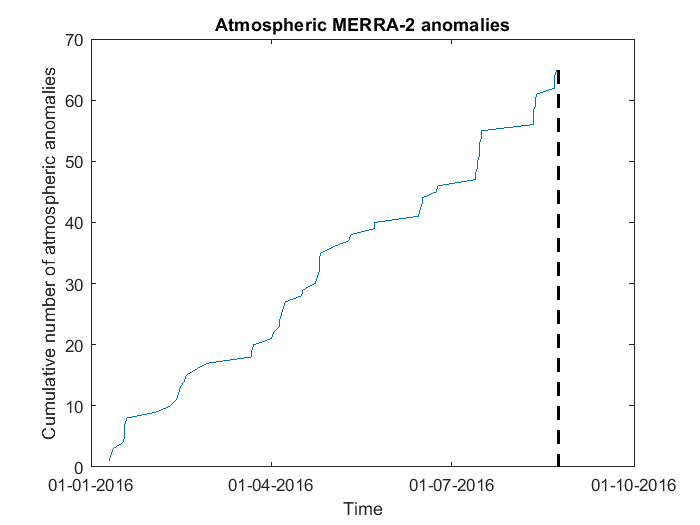

In [52]:
% Plot of the cumulative graph of the identified anomalies
figure
% Sort the atmospheric anomalies for time of occurrence (column 1)
atmospheric_anomalies = sortrows(atmospheric_anomalies,1);
%Create a vector with incremental numbers up to the number of detected anomalies.
cumulate_atmosphere = (1:size(atmospheric_anomalies, 1))';
% Plot the cumulate of atmospheric anomalies 
plot(time_start-1+atmospheric_anomalies(:,1), cumulate_atmosphere)
% Plot a vertical black dashed line for time of earthquake 
line([EQ_time, EQ_time], [0 cumulate_atmosphere(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
% COmplete the plot with the proper formatting of time and inserting labels 
datetick('x', 'dd-mm-yyyy');
xlabel('Time');
ylabel('Cumulative number of atmospheric anomalies');
title('Atmospheric MERRA-2 anomalies');
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Atmosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_cumulative_anomalies_vs_time.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Atmosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_cumulative_anomalies_vs_time.fig']), "fig");


## Ionospheric analysis
In this session, the magnetic data from Swarm three-identical satellites are analysed.

A full description of the method used for this analysis can be found in the following papers:
1. De Santis, A.; Balasis, G.; Pavón-Carrasco, F.J.; Cianchini, G.; Mandea, M. Potential earthquake precursory pattern from space: The 2015 Nepal event as seen by magnetic Swarm satellites. Earth Planet. Sci. Lett. 2017, 461, 119–126. <a href="http://doi.org/10.1016/j.epsl.2016.12.037"> doi:10.1016/j.epsl.2016.12.037</a>.
2. De Santis, A.; Marchetti, D.; Pavón-Carrasco, F.J.; Cianchini, G.; Perrone, L.; Abbattista, C.; Alfonsi, L.; Amoruso, L.; Campuzano, S.A.; Carbone, M.; et al. Precursory worldwide signatures of earthquake occurrences on Swarm satellite data. Sci. Rep. 2019, 9, 20287. <a href="http://doi.org/10.1038/s41598-019-56599-1">doi:10.1038/s41598-019-56599-1</a>.  
3. Marchetti, D.; De Santis, A.; Campuzano, S.A.; Zhu, K.; Soldani, M.; D’Arcangelo, S.; Orlando, M.; Wang, T.; Cianchini, G.; Di Mauro, D.; et al. Worldwide Statistical Correlation of Eight Years of Swarm Satellite Data with M5.5+ Earthquakes: New Hints about the Preseismic Phenomena from Space. Remote Sens. 2022, 14, 2649. <a href="https://doi.org/10.3390/rs14112649">doi:10.3390/rs14112649</a>.


The first part of the following code selects the data in the time range defined for the analysis of the earthquake.

In [53]:
% Define a threshold to identify Swarm magnetic anomalies
threshold = 4;
% Define the length of the latitudinal window to search for anomalies
width_window = 3; %

% Define the folder for the output products of the VRE
Output_folder = "Outputs";

% Calculate the earthquake origin time, time constraints for the analysis and Dobrovolsky's radious 
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;

### Here we defined some functions that are necessary to properly exectute the code that processes the Swarm satellite magnetic data
The following cell defines a function called *"geograph2geomag"* that permits to transform (i.e., rotate) the geographic coordinates of longitude and latitude in geomagnetic coordinates (i.e., geomagnetic latitude and longitude).  
The conversion is performed using the coordinates of the magnetic pole provided in the file `polos_igrf_swarm.dat` into the data folder.

In [54]:
function [mlat,mlong]=geograph2geomag(lat,long,time)
%lat, lon = geographic latitude and longitude
%time expressed in year. For example if you have 30/01/2016 time must be only 2016
format long
polo=load(fullfile("data", "polos_igrf_swarm.dat"));
fact=pi/180;
%latitude and longitude of magnetic pole in the year "time" (according to IGRF).
Dlat = polo(polo(:,1)==time,2)*fact; %latitude of geoamgentic pole
Dlong = (360+polo(polo(:,1)==time,3))*fact;%Geomagnetic longitude of the pole
%program
glong=long*fact;
glat=lat*fact;
x=cos(glat).*cos(glong);
y=cos(glat).*sin(glong);
z=sin(glat);
dato=[x,y,z];
%first rotation of the equator plane from the Greenwich meridian to the pole meridian.
M1=[cos(Dlong) sin(Dlong) 0;-sin(Dlong) cos(Dlong) 0;0 0 1];
S1=M1*dato';
%second rotation in the plane of the current meridian from the geographic pole to the magnetic pole.
M2=[cos(pi/2-Dlat) 0 -sin(pi/2-Dlat);0 1 0;sin(pi/2-Dlat) 0 cos(pi/2-Dlat)];
S2=M2*S1;
S2=S2';
%The last transformation
mlat=atan(S2(:,3)./sqrt(S2(:,1).^2+S2(:,2).^2));
mlat=mlat/fact;
mlong=atan(S2(:,2)./S2(:,1));
mlong=mlong/fact;
return

The following cell defines a function called *"geomagnetic_indexes"* that extracts the Dst and ap geomagnetic indexes at the time of interest  


In [55]:
function [dst,ap]=geomagnetic_indexes(z,a,b)
a1=a(a(:,1)==z(1) & a(:,2)==z(2) & a(:,3)==z(3),4:end);
b1=b(b(:,1)==z(1) & b(:,2)==z(2) & b(:,3)==z(3),4:end);
dst=a1(1, round(z(4))+1);
ap=b1(1, round(z(4))+1);
return

The following code extracts the Swarm magnetic data inside the Dobrovolsky's area and stores in struct variable **"tracks"** for further processing.  
Total number of extracted tracks is shown as i_tr

The following section calculated the magnetic residual along the tracks. The residual of the magnetic field in this case is the part of data that may contain eventual non-ordinary signals, i.e. eventual earthquake-induced signals.  
Total number of extracted residual tracks is shown as i_res

In [56]:
format compact
% load the geomagnetic indexes Dst and ap 
idst=load(fullfile("data", "dst_index2.dat"));
iap=load(fullfile("data", "ap_index2.dat"));

% Calculate Dobrovolsky's radius to define the research area  
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
directory_to_read_Swarm_tracks = fullfile("data", "Swarm_tracks");
% Read the directory to list all files that contain Swarm data in the proper folder
list_of_Swarm_files = dir(fullfile(directory_to_read_Swarm_tracks, "Swarm_track*.mat"));
list_of_Swarm_files = {list_of_Swarm_files.name}';

% Read the Swarm data and store it in the struct called "tracks" 
tracks = {};
i_tr = 1;
for i=1:size(list_of_Swarm_files, 1)
    % Get one-by-one each file
    file_to_be_read = list_of_Swarm_files{i};
    % Load the data from the specific file
    load(fullfile(directory_to_read_Swarm_tracks, file_to_be_read));
    % Store the data in the tracks struct.
    tracks{i_tr} = y;
    i_tr = i_tr + 1;
end

% Reserve a struct "residuals" to store the residual track data in order to search for anomalies in the followings cells.
residuals = {};
i_res = 1;
for i=1:size(tracks,2)
    y = tracks{i};
    % Store in p1 the real track number in the specific data
    p1=y(1,8):y(end,8);
    for j=1:length(p1)
        % Extract in z array the data of the specific track  in order to select only the data from this specific track
        z=y(y(:,8)==p1(j),:);
        if size(z,1)>10 %if the track is longer than 10 data, further process it
            % Extract Dst and ap geomagnetic indexes at the time of the Swarm track
            [dst,ap]=geomagnetic_indexes(z(1,2:5),idst,iap);
            % Order the data for latitude (column 9)
            z=sortrows(z,9);
            % Calculate the UTC TIME in decimal hours for the track
            tt1=z(abs(z(:,9)-epilat)<radius_Dobrovolsky,5)+z(abs(z(:,9)-epilat)<radius_Dobrovolsky,6)/60+z(abs(z(:,9)-epilat)<radius_Dobrovolsky,7)/3600;
            % Calculate the UT time as a vector (separated hour, minute and second)
            tt1_v=datevec(mean(tt1)/24);
            % Select only the samples acquired in good flags (columns 13, 14 and 15)
            z = z(z(:,13) <= 9 & z(:,14) <= 18 & z(:,15) <= 1, :);
            %The difference with A, B and C is not correct because in ASM burst mode for all the satellites, these parameters need to be considered
            if size(z,1)>1000
                % Calculus of the geomagnetic latitude.
                latmag=geograph2geomag(z(:,9),z(:,10),z(1,2));
                % Extract in D1 the Y-East component for the following analyses.
                D1=z(:,end-2);
                % Calculate the differences sample-by-sample of the data od D1
                d=diff(D1);
                % Create the vector tt1 with the time in seconds to calculate the difference between two consecutive samples.
                tt1s = z(:,5)*3600+z(:,6)*60+z(:,7);
                % Divided the previous difference for the time interval between two specific consecutive samples
                for tem=1:size(d, 1)
                    d(tem) = d(tem) / (tt1s(tem+1) - tt1s(tem));
                end
                % Calculate the geomagnetic latitude at intermediate points (N-1 points) 
                latmag = latmag(1:end-1)/2 + latmag(2:end)/2;
                % Calculus of a spline fit to remove residual trend from baseline 
                if size(d,1)>50
                    % If there are enough samples (more than 50), the knot points of the spline are selected every 20 points
                    spline_fit = fit(latmag, d, 'smoothingspline', 'SmoothingParam', 20/size(d,1));
                else
                    % If there are few samples in the track (less or equal to 50), the knot points of the spline are selected every 10 points
                    spline_fit = fit(latmag, d, 'smoothingspline', 'SmoothingParam', 10/size(d,1));
                end
                % Evaluate the spline fit over the track points (in geomagnetic latitude coordinates)
                fitted_value = feval(spline_fit, latmag);
                % Calculate the residual "val" as difference of the previous data minus the fitted curve. 
                % "val" is the residual for further processing (e.g., researching anomalies).
                val = d - fitted_value;
                % Cut the track at +/-50 degrees of geomagnetic latitude. This is not performed before to avoid the edge error of the previous fit.
                val = val(abs(latmag) <= 50);
                % z vector is recomputed with N-1 samples (due to the derivate operation)
                z = z(1:end-1,:)/2 + z(2:end,:)/2;
                % z and latmag vectors are cut at the same geomagnetic latitude constraints
                z = z(abs(latmag) <= 50, :);
                latmag = latmag(abs(latmag) <= 50);
                % The obtained residual track with all teh corresponding information is stored 
                % in a struct called residuals with one element for each track
                residuals{i_res}.residual = val;
                residuals{i_res}.latmag = latmag;
                residuals{i_res}.track = z;
                residuals{i_res}.geomag_index = [dst, ap];
                i_res = i_res + 1;
            end
        end
    end
end

% Print of the total number of residual track that are provided for the following analyses
disp("Number of available residual Swarm magnetic track for further analyses:")
i_res

Number of available residual Swarm magnetic track for further analyses:


i_res =         2536

The following code plots 10 tracks selcted randomically among all the selected data.

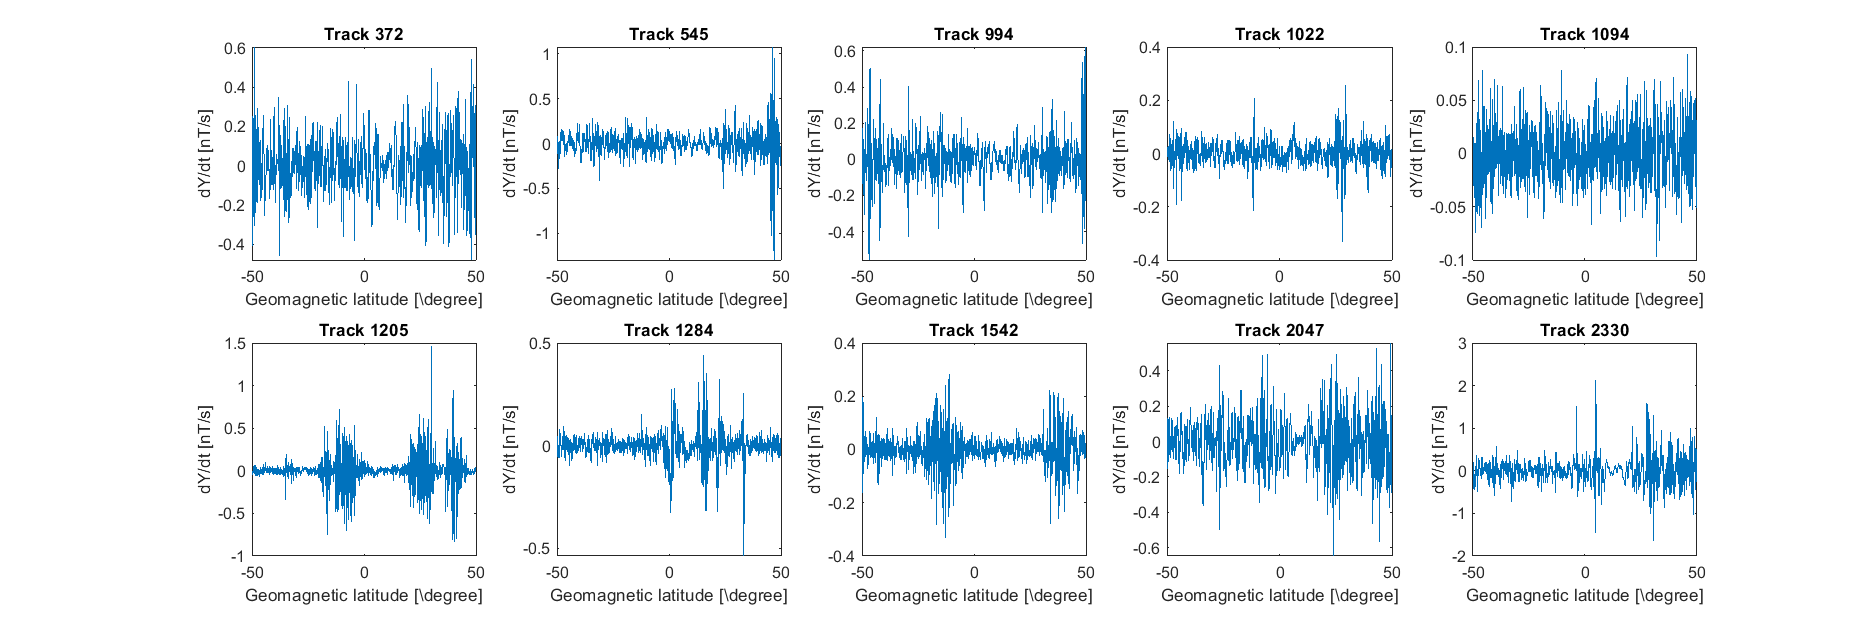

In [57]:
% Extraction of 10 integer number that are the indexes of the tracks randomly selected to be plotted for user check.
figure_index = fix(1+rand(10,1)*size(residuals,2));
% Sort the index in ascending order
figure_index = sortrows(figure_index);
% Create one figure
figure('Position', [1, 1, 1500, 500])
for i=1:size(figure_index,1)
    % Retrieve the geomagnetic latitude (latmag) and values (val) for the i-th track to be plotted
    latmag = residuals{figure_index(i)}.latmag;
    val = residuals{figure_index(i)}.residual;
    % Create a sublot of 2 rows and 5 columns
    subplot(2,5,i)
    % Plot the specific track residual
    plot(latmag, val)
    % Place the labels of the x and y axes
    ylabel('dY/dt [nT/s]');
    xlabel('Geomagnetic latitude [\degree]', 'Interpreter', 'latex');
    % print the title with the indication of which track has been shown
    title(['Track ', num2str(figure_index(i), '%d')]);
end

% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Ionosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_Swarm_residual_tracks.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Ionosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_Swarm_residual_tracks.fig']), "fig");


The following section extracted the anomalous magnetic signal from the previous selected tracs. 

In [58]:
% Set the geomagnetic index limits. Only tracks with ap <= than max_ap and absolute value of Dst no more than max_DSt 
% will be considered to search for any anomalies 
max_dst = 20;
max_ap = 10;

% Prepare an array to store the anomalous windows
anomalous_windows = {};
k_window = 1;
% Create an array to classify the track as anomalous or not.
% A track is classified as anomalous if it contains at least 1 anomlous window.
anomalous_track = nan(size(residuals,2), 9);
i_anom_track = 1;
for i=1:size(residuals,2)
    % Select the values (val) and geomagnetic latitude (latmag) of the track to be analysed
    latmag = residuals{i}.latmag;
    val = residuals{i}.residual;
    % Original data (z) of the track are also retrieved for other track information as the coordinates (longitude/latitude)
    z = residuals{i}.track;
    % Extract the geomagnetic indexes of the specific track
    geomag_indexes = residuals{i}.geomag_index;
    % Calculate the threshold to define an anomaly as the root mean square of the track multiplied by the threshold (defined above)
    track_threshold = threshold*nanstd(val);
    number_of_anomalous_windows = 0;
    % Explore the track by a moving window from geomag_lat_start to geomag_lat_end with step 
    geomag_lat_start = -50;
    geomag_lat_end = +50;
    step = width_window / 5;
    % start the first window as the beginning of the track
    window_center = geomag_lat_start;
    while window_center <= geomag_lat_end %The analysis continues up to teh end of the track
        % Calculate the root mean square of the window (rms)
        window_rms = nanstd(val(abs(latmag - window_center) <= width_window / 2));
        % If the rms is greater than the previously defined threshold and geomagnetic quiet conditions the window is classified as anomalous  
        if window_rms > track_threshold && abs(geomag_indexes(1)) <= max_dst && geomag_indexes(2) <= max_ap
            number_of_anomalous_windows = number_of_anomalous_windows + 1;
            anomalous_windows{k_window,1}.latmag = window_center;
            anomalous_windows{k_window,1}.latgeo = nanmean(z(abs(latmag - window_center) <= width_window / 2, 9));
            anomalous_windows{k_window,1}.longeo = nanmean(z(abs(latmag - window_center) <= width_window / 2, 10));
            anomalous_windows{k_window,1}.time = nanmean(datenum(z(abs(latmag - window_center) <= width_window / 2, 2:7)));
            k_window =  + 1;
        end
        window_center = window_center + step;
    end
    if number_of_anomalous_windows > 0
        
        [distance_windows_center_epicenter, index_sample] = min(abs(epilat - z(:,9))); %search the closest latitudinal sample to the epicenter
        % Check if the center of the closest window is inside Dobrovolsky's area
        if distance_windows_center_epicenter <= radius_Dobrovolsky
            % Store the track as anomalous one, with the relative parameters
            anomalous_track(i_anom_track,:) = [z(index_sample,2:7), z(1,1), z(index_sample,10), number_of_anomalous_windows];
            i_anom_track = i_anom_track + 1;
        end
    end
end
disp(["Anomalous detected tracks: ", num2str(i_anom_track -1)])

% Cut the array of anomalous track at the effective size of detected anomalous tracks.
anomalous_track = anomalous_track(1:i_anom_track-1,:);
% Sort the array of anomalous tracks for ascending order
anomalous_track = sortrows(anomalous_track);
% Save the list of Ionospheric anomalies in the output folder
save(fullfile(Output_folder, ['Ionospheric_Swarm_anomaly_list_for_EQ_catalogue_target_EQ_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '.txt']), "anomalous_track", '-ascii');


    "Anomalous detected tracks: "    "111"


### Visualization of the cumulative number of Swarm magnetic tracks

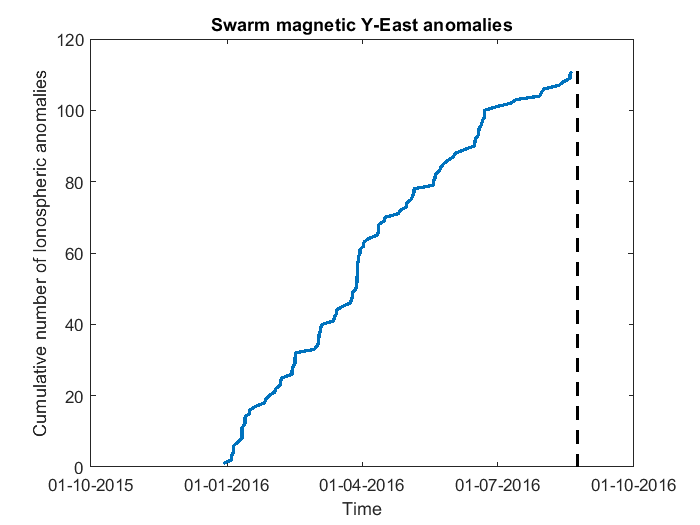

In [59]:
% Plot of the cumulative number of Swarm anomalous tracks
format compact
% Calculate the time of each anomalous track
time_Swarm_anomalies = datenum(anomalous_track(:,1:6));
% Prepare a vector with prossive numbers from 1 to total number of anomalous tracks
Cumulative_anomalies_Swarm = (1:size(anomalous_track,1))';
% Prepare the figure
figure
% Plot the cumulative number of anomalous track versus time
plot(time_Swarm_anomalies, Cumulative_anomalies_Swarm, 'LineWidth', 2)
% plot a black vertical dashed line to mark the earthquake time
line([EQ_time, EQ_time], [0 Cumulative_anomalies_Swarm(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
% Adapt the time to date format
datetick('x', 'dd-mm-yyyy');
% Place proper labels of the axes
xlabel('Time');
ylabel('Cumulative number of Ionospheric anomalies');
title('Swarm magnetic Y-East anomalies');
% Save the figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Ionosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_cumulative_anomalies_vs_time.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Ionosphere_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '_cumulative_anomalies_vs_time.fig']), "fig");


# Comparison of Lithosphere Atmosphere and Ionosphere analyses 

A final comparison of the analysed parameters is provided by the follwing code.  
The approach has been used in different earhtquake investigations in the World, as Mw = 7.5 Indonesia 2018, Mw = 7.7 Jamaica 2020, Mw = 7.1 Haiti 2021 or recent Mw = 6.8 Morocco 2023 earthquakes.  
**References:**
1. Marchetti, D. Observation of the Preparation Phase Associated with Mw = 7.2 Haiti Earthquake on 14 August 2021 from a Geophysical Data Point of View. Geosciences 2024, 14, 96. https://doi.org/10.3390/geosciences14040096

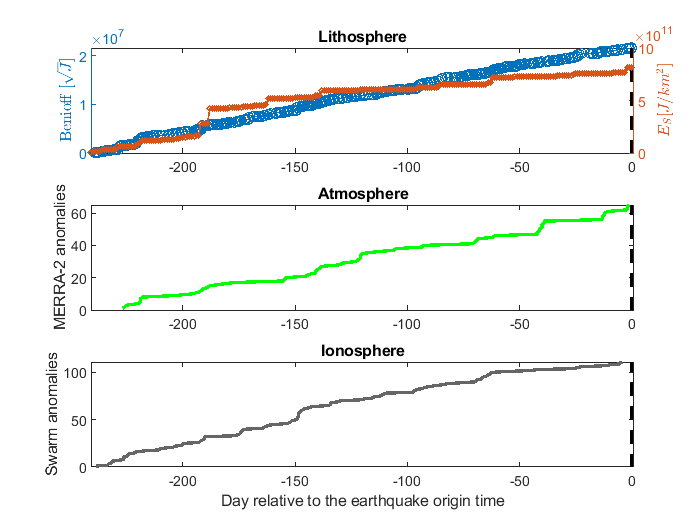

In [60]:
% Prepare a figure for the summary of lithosphere, atmosphere and ionosphere trends
figure
% Subplot for the Lithosphere
subplot(3,1,1)
% On the left axis the Cumulative Benioff strain is plotted
yyaxis left;
plot(time_EQ_sel - EQ_time, EQ_sqrt_energy, '-o');
% The vertical black dashed line of the earthquake origin time is marked
line([0, 0], [0 EQ_sqrt_energy(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
ylabel('Benioff [$\sqrt{J}$]', 'Interpreter', 'latex');
% On the right axis the Cumulative ES parameter is plotted
yyaxis right;
plot(cumulative_ES(:,1)- EQ_time, cumulative_ES(:,2), '-o', 'Linewidth', 1, 'MarkerSize', 2.5);
ylabel('$E_S [J/km^2]$', 'Interpreter', 'latex');
title(['Lithosphere']);
% Set the time interval to one day prior and after the analysed time to improve visualization
xlim([-day_before-1 day_after + 1]);
% Subplot for the Atmosphere
subplot(3,1,2)
% plot the cumulative trend of anomalies in the atmosphere
plot(time_start-1+atmospheric_anomalies(:,1)-EQ_time, cumulate_atmosphere, 'g', 'LineWidth', 2)
% The vertical black dashed line of the earthquake origin time is marked
line([0, 0], [0 cumulate_atmosphere(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
ylabel('MERRA-2 anomalies');
% Set the time interval to one day prior and after the analysed time to improve visualization
xlim([-day_before-1 day_after + 1]);
title('Atmosphere')
% Subplot for the Ionosphere
subplot(3,1,3)
% Plot the cumulative trend of Swarm magnetic anomalies
plot(time_Swarm_anomalies-EQ_time, Cumulative_anomalies_Swarm, 'Color', [0.4 0.4 0.4], 'LineWidth', 2)
% The vertical black dashed line of the earthquake origin time is marked
line([0, 0], [0 Cumulative_anomalies_Swarm(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Day relative to the earthquake origin time');
ylabel('Swarm anomalies');
title('Ionosphere')
% Set the time interval to one day prior and after the analysed time to improve visualization
xlim([-day_before-1 day_after + 1]);
% Save the summary figure in the Output folder
saveas(gcf, fullfile(Output_folder, ['Summary_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '.png']), "png");
saveas(gcf, fullfile(Output_folder, ['Summary_EQ_target_', num2str(epilat, '%03.3f'), '_', num2str(epilon, '%03.3f'), '.fig']), "fig");
